In [24]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random
import math
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
env = "Varinia"

In [25]:
if env == "Sky":
    data_path_1='../Expert_response/all_HIT_answer.csv'
    data_path_2='../Expert_response/master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'

else:
    data_path_1=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\all_HIT_answer.csv'
    data_path_2=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'
    data_path_3=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\gs_response_Jun-04-2023.csv'
    data_path_4=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\processed_result\winner_loser_avg.csv'
df_1= pd.read_csv(data_path_1)
df_2= pd.read_csv(data_path_2)
df_3= pd.read_csv(data_path_3)
df_4= pd.read_csv(data_path_4)

In [26]:
def process_data(df_1, df_2):
    # Remove all positive and negative attention checks, keep only 1 copy of the positive attention check
    all_test_q = df_1[(df_1['question_type'] != "neg_attention") & (df_1['question_type'] != "pos_attention_easy")].copy()
    pos_attention_q = df_1[df_1['question_type'] == "pos_attention_easy"].head(1).copy()

    # Concatenate the dataframes and reset the index
    all_q = pd.concat([all_test_q, pos_attention_q], ignore_index=True)
    all_q.reset_index(drop=True, inplace=True)

    # Select the desired columns and convert question_num to int
    all_q2 = all_q[['cow_L', 'cow_R', 'question_num', 'HIT']].copy()
    all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)

    # Select the columns for response dataframe
    all_q_col = [f"q{i}" for i in range(1, 13)]
    all_col = all_q_col.copy()
    all_col.append('HIT')

    # Get the response dataframe
    response = df_2[all_col].copy()

    return all_q2, response


In [27]:
def reshape_and_remove_nan(df):
    df_melted = df.melt(id_vars='HIT',
                        value_vars=['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12'],
                        var_name='question_num',
                        value_name='response')
    df_melted['question_num'] = df_melted['question_num'].str[1:].astype(int)
    df_melted = df_melted.dropna()
    return df_melted

In [28]:
def process_and_merge(df_1, df_2):
    all_q2, response = process_data(df_1, df_2)
    response_melted = reshape_and_remove_nan(response)
    merged_df = all_q2.merge(response_melted, on=['HIT', 'question_num'], how='inner')
    merged_df2 = merged_df[['cow_L', 'cow_R', 'response']]

    return merged_df2


In [29]:
def simple_responses(df):
    N=df.shape[0]
    matrix=[]
    for i in range(N):
        aux_df=df.iloc[[i]]
        cow_L=aux_df.at[i,'cow_L']
        cow_R=aux_df.at[i,'cow_R']
        response=aux_df.at[i,'response']
        if response==0:
            row=np.concatenate(([cow_L],[cow_R],[0]))
        elif response<0:
            row=np.concatenate(([cow_L],[cow_R],[-1]))
        else:
            row=np.concatenate(([cow_L],[cow_R],[1]))
        matrix.append(row.tolist())
    new_df=pd.DataFrame(matrix)
    new_df.columns=['cow_L', 'cow_R', 'response']

    return new_df

In [30]:
def list_cows(df):
    first_cow=df.loc[0,'cow_L']
    aux_df=df[df['cow_L']==first_cow]
    cows_1=list(aux_df['cow_R'])
    aux_df=df[df['cow_R']==first_cow]
    cows_2=list(aux_df['cow_L'])
    for i in cows_2:
        cows_1.append(i)
    cows_1.append(first_cow)
    return cows_1

In [31]:
def matrix_comparison(df):
    cow_order=list_cows(df)
    #print(cow_order)
    num_cows=len(cow_order)
    data_comp=np.zeros( (num_cows, num_cows) )
    for i in range(num_cows):
        for j in range(num_cows):
            if (i==j):
                data_comp[i][j]=np.nan
            else:
                aux=df[(df['cow_L']==cow_order[i])|(df['cow_R']==cow_order[i])]
                aux=aux[(aux['cow_L']==cow_order[j])|(aux['cow_R']==cow_order[j])]
                #print(aux)
                cow_L=aux['cow_L'].to_numpy()
                cow_R=aux['cow_R'].to_numpy()
                response=aux['response'].to_numpy()
                if(response[0]==0):
                    data_comp[i][j]=0
                else:
                    if(cow_L[0]==cow_order[i]):
                        if(response[0]<0):
                            data_comp[i][j]=1
                        else:
                            data_comp[i][j]=-1
                    else: #aux['cow_L']==cow_order[j]
                        if(response[0]<0):
                            data_comp[i][j]=-1
                        else:
                            data_comp[i][j]=1
    data_comp = pd.DataFrame(data_comp)
    #Rename rows and cols with cow names in original order
    row_dic= {i: str(num) for i, num in enumerate(cow_order)}
    col_name = [str(num) for num in cow_order]
    data_comp = data_comp.rename(index=row_dic)
    data_comp.columns = col_name
    # Randomize row order
    random_indices = np.random.permutation(data_comp.index)
    data_comp = data_comp.loc[random_indices, random_indices]
    #Change type to fit cow_order format
    new_cow_order = [int(x) for x in random_indices]
    #Re set row&col names
    new_indices = range(len(data_comp.index))
    data_comp = data_comp.rename(index=dict(zip(data_comp.index, new_indices)),
                                         columns=dict(zip(data_comp.columns, new_indices)))
    return data_comp, new_cow_order

In [32]:

def mergeSort(lst,comp,data_comparison):
    if len(lst) > 1:
        r = len(lst)//2
        L = lst[:r]
        M = lst[r:]
        L,comp=mergeSort(L,comp,data_comparison)
        M,comp=mergeSort(M,comp,data_comparison)
        lst=L+M
        i = j = k = 0

        while i < len(L) and j < len(M):
            comp += 1
            if data_comparison[L[i][0]][M[j][0]]==1 :
                lst[k] = L[i]
                i += 1
            else:
                lst[k] = M[j]
                j += 1
            k += 1

        while i < len(L):
            lst[k] = L[i]
            i += 1
            k += 1

        while j < len(M):
            lst[k] = M[j]
            j += 1
            k += 1
    return lst,comp


In [33]:
final_df = process_and_merge(df_1, df_2)
responses=simple_responses(final_df)
rankings=[]
rankings_simple=[]
num_ranks=1000
for j in range(num_ranks):
    data_comparison, new_cow_order = matrix_comparison(responses)
    #print(data_comparison)
    #print(new_cow_order)
    #Applying MG
    num_cows=len(new_cow_order)
    #print("Cow order in matrix is:")
    #print(new_cow_order)

    lst_mg = []
    for i in range(num_cows):
        inner_list = []
        inner_list.append(i)
        lst_mg.append(inner_list)

    #print("Basic array before mergesort:")
    #print(lst_mg)

    comp_mg=0
    lst_mg,comp_mg= mergeSort(lst_mg,comp_mg,data_comparison)
    #print("Basic array sorted after mergesort:")

    #print(lst_mg)
    single_list = [item for sublist in lst_mg for item in sublist]
    lst_mg_cows=[]
    while (len(lst_mg)>0):
        aux_len=len(lst_mg[0])
        aux_ties=[]
        for i in range(aux_len):
            aux_ties.append(new_cow_order[lst_mg[0][i]])
        lst_mg.pop(0)
        lst_mg_cows.append(aux_ties)
    #print("Sorted cows in ascending order is:")
    #print(lst_mg_cows)

    #print("Number of comparisons done in merge sort:")
    #print(comp_mg)
    # Making comparison with GS value
    mg_vs_GS = pd.DataFrame([item for sublist in lst_mg_cows for item in sublist], columns=['merge sorted'])
    N=mg_vs_GS.shape[0]
    aux=[]
    for i in range (N):
        cow=mg_vs_GS.at[i,'merge sorted']
        aux.append(list(df_3.loc[df_3['Cow']== cow,'GS'])[0])
    mg_vs_GS['GS'] = aux
    #Saving the rank
    rankings.append(list(mg_vs_GS['merge sorted']))
    rankings_simple.append(single_list)


C:\Users\varin\AppData\Local\Temp\ipykernel_18348\1855475665.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)


     cow_L  cow_R  response
0     6029   7138      -1.0
1     5087   4008      -3.0
2     6092   7114       0.0
3     6053   6088       1.0
4     4035   7060      -1.0
..     ...    ...       ...
430   5087   5064      -1.0
431   6046   4035       2.0
432   7109   7153      -1.0
433   6068   5118      -1.0
434   5087   6068      -1.0

[435 rows x 3 columns]
     winner   loser  degree   expert
0    4008.0  5118.0     1.0  avg_D_W
1    6088.0  4008.0     1.0  avg_D_W
2    4008.0  6092.0     0.5  avg_D_W
3    4008.0  7060.0     1.0  avg_D_W
4    4008.0  7109.0     0.5  avg_D_W
..      ...     ...     ...      ...
430  8083.0  7060.0     1.0  avg_D_W
431  8083.0  7109.0     0.0  avg_D_W
432  8083.0  7114.0     0.5  avg_D_W
433  7153.0  8083.0     0.5  avg_D_W
434  8083.0  7163.0     0.5  avg_D_W

[435 rows x 4 columns]
     cow_L  cow_R  response
0     6029   7138        -1
1     5087   4008        -1
2     6092   7114         0
3     6053   6088         1
4     4035   7060        -1
..  

In [34]:

# Initialize the counter dictionary
position_counts = Counter()

# Iterate through each list in the data
for lst in rankings:
    # Iterate through each position in the list
    for position, individual in enumerate(lst):
        # Increment the count for the individual at the current position
        position_counts[(individual, position)] += 1

# Initialize the individual_counts dictionary
individual_counts = {}

# Iterate through the items in the counter_info dictionary
for (individual, position), count in position_counts.items():
    if individual not in individual_counts:
        individual_counts[individual] = [0] * num_cows# Initialize the list for the individual
    individual_counts[individual][position] = count

print(individual_counts)

{6029: [99, 159, 167, 123, 81, 76, 56, 35, 23, 29, 22, 20, 13, 19, 16, 16, 11, 11, 10, 4, 3, 3, 0, 2, 2, 0, 0, 0, 0, 0], 7060: [198, 107, 83, 69, 59, 56, 46, 35, 26, 30, 33, 23, 35, 24, 21, 25, 12, 11, 27, 15, 17, 15, 8, 9, 8, 2, 4, 2, 0, 0], 6068: [11, 28, 48, 70, 66, 69, 85, 75, 86, 51, 37, 55, 41, 42, 37, 36, 24, 19, 22, 22, 23, 11, 15, 7, 12, 4, 4, 0, 0, 0], 7064: [1, 9, 8, 12, 20, 29, 38, 41, 44, 32, 52, 61, 73, 70, 67, 52, 60, 57, 40, 48, 46, 43, 37, 24, 12, 9, 11, 2, 2, 0], 7153: [30, 21, 21, 28, 28, 37, 38, 47, 47, 49, 47, 48, 52, 52, 48, 49, 45, 49, 40, 37, 34, 41, 31, 31, 20, 12, 7, 3, 4, 4], 7136: [2, 3, 20, 34, 42, 39, 44, 48, 49, 37, 52, 34, 49, 37, 42, 29, 35, 31, 31, 43, 42, 43, 42, 45, 48, 56, 18, 4, 1, 0], 6095: [2, 1, 0, 5, 10, 3, 13, 29, 31, 43, 50, 51, 42, 42, 52, 55, 65, 59, 64, 61, 58, 63, 55, 56, 35, 31, 14, 3, 5, 2], 6046: [166, 168, 117, 76, 52, 46, 25, 26, 32, 31, 19, 18, 29, 25, 21, 19, 23, 21, 19, 16, 10, 10, 5, 10, 7, 2, 4, 1, 2, 0], 6094: [4, 2, 14, 29, 27

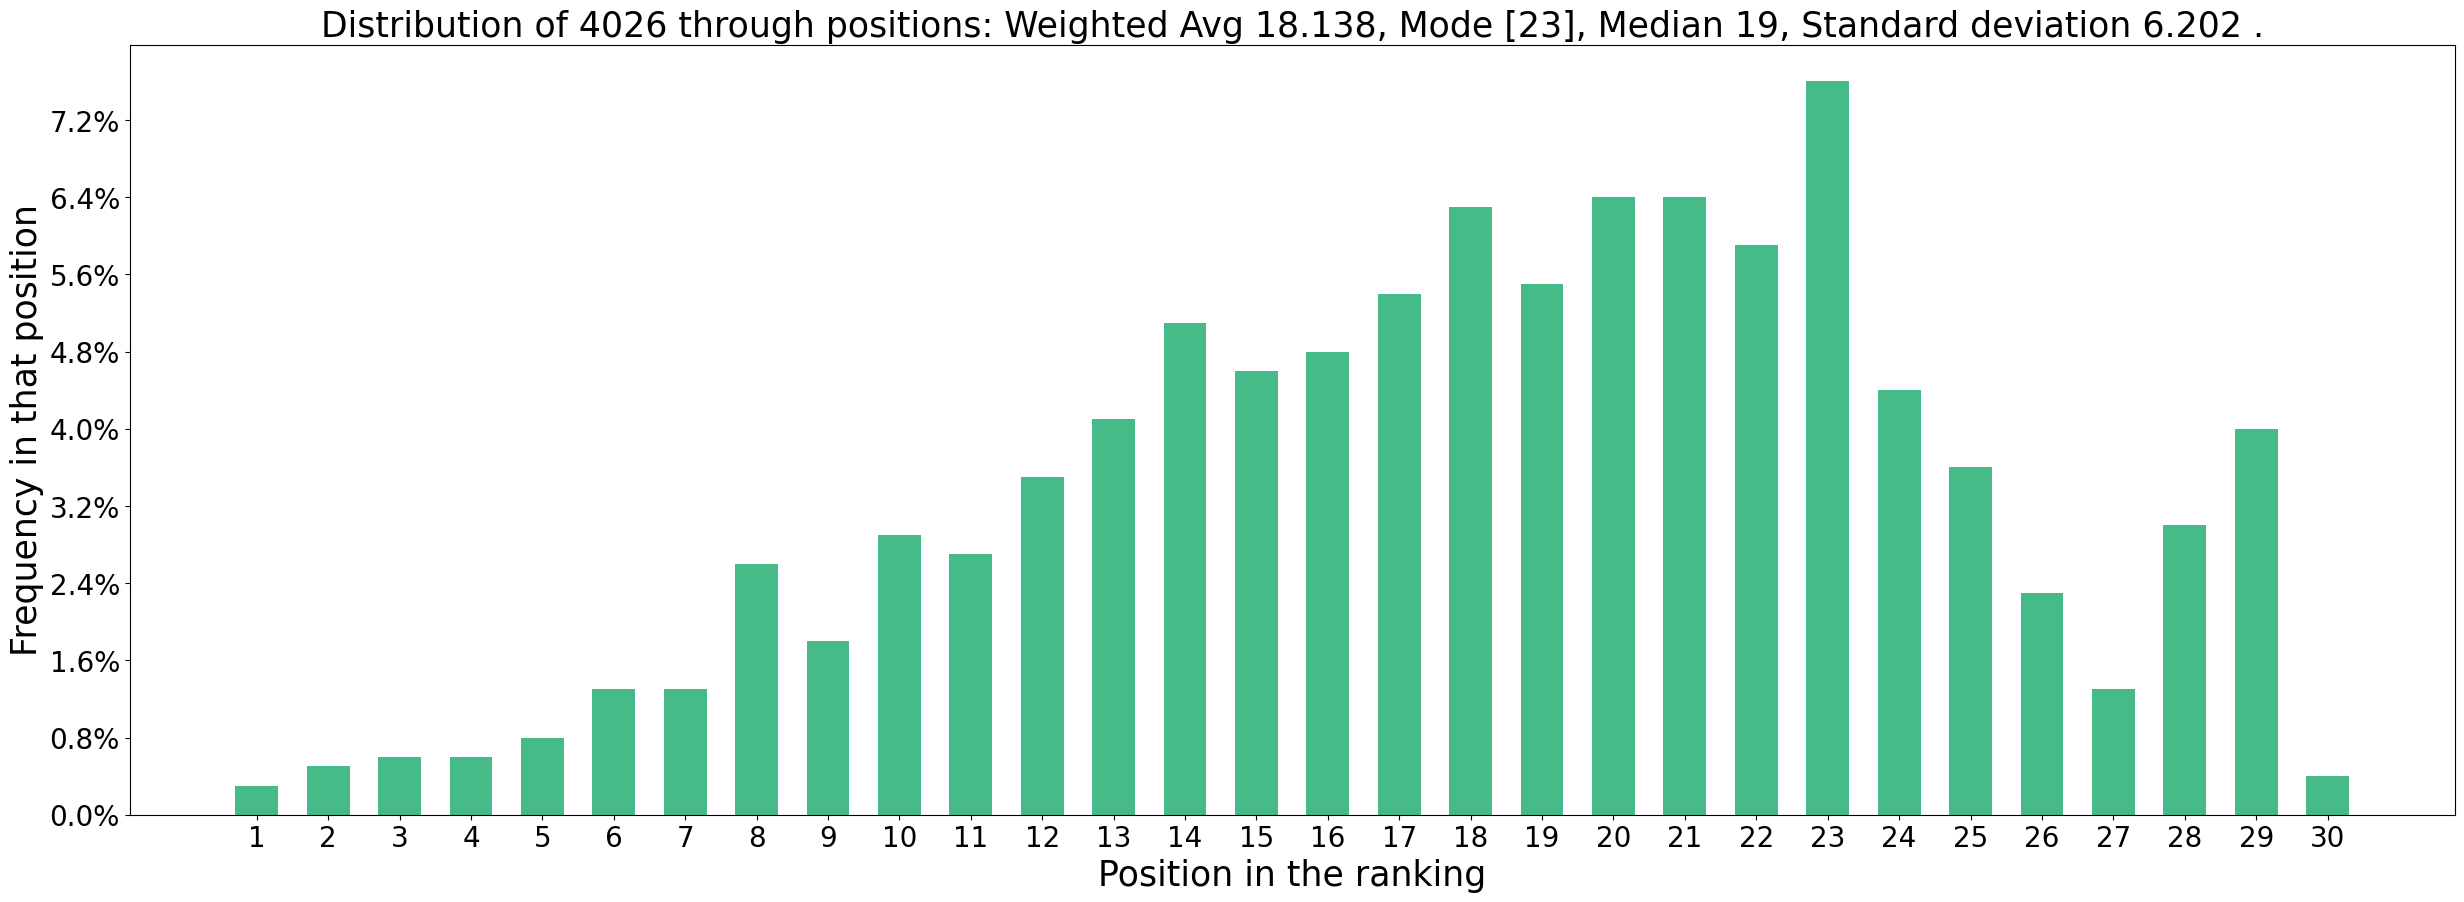

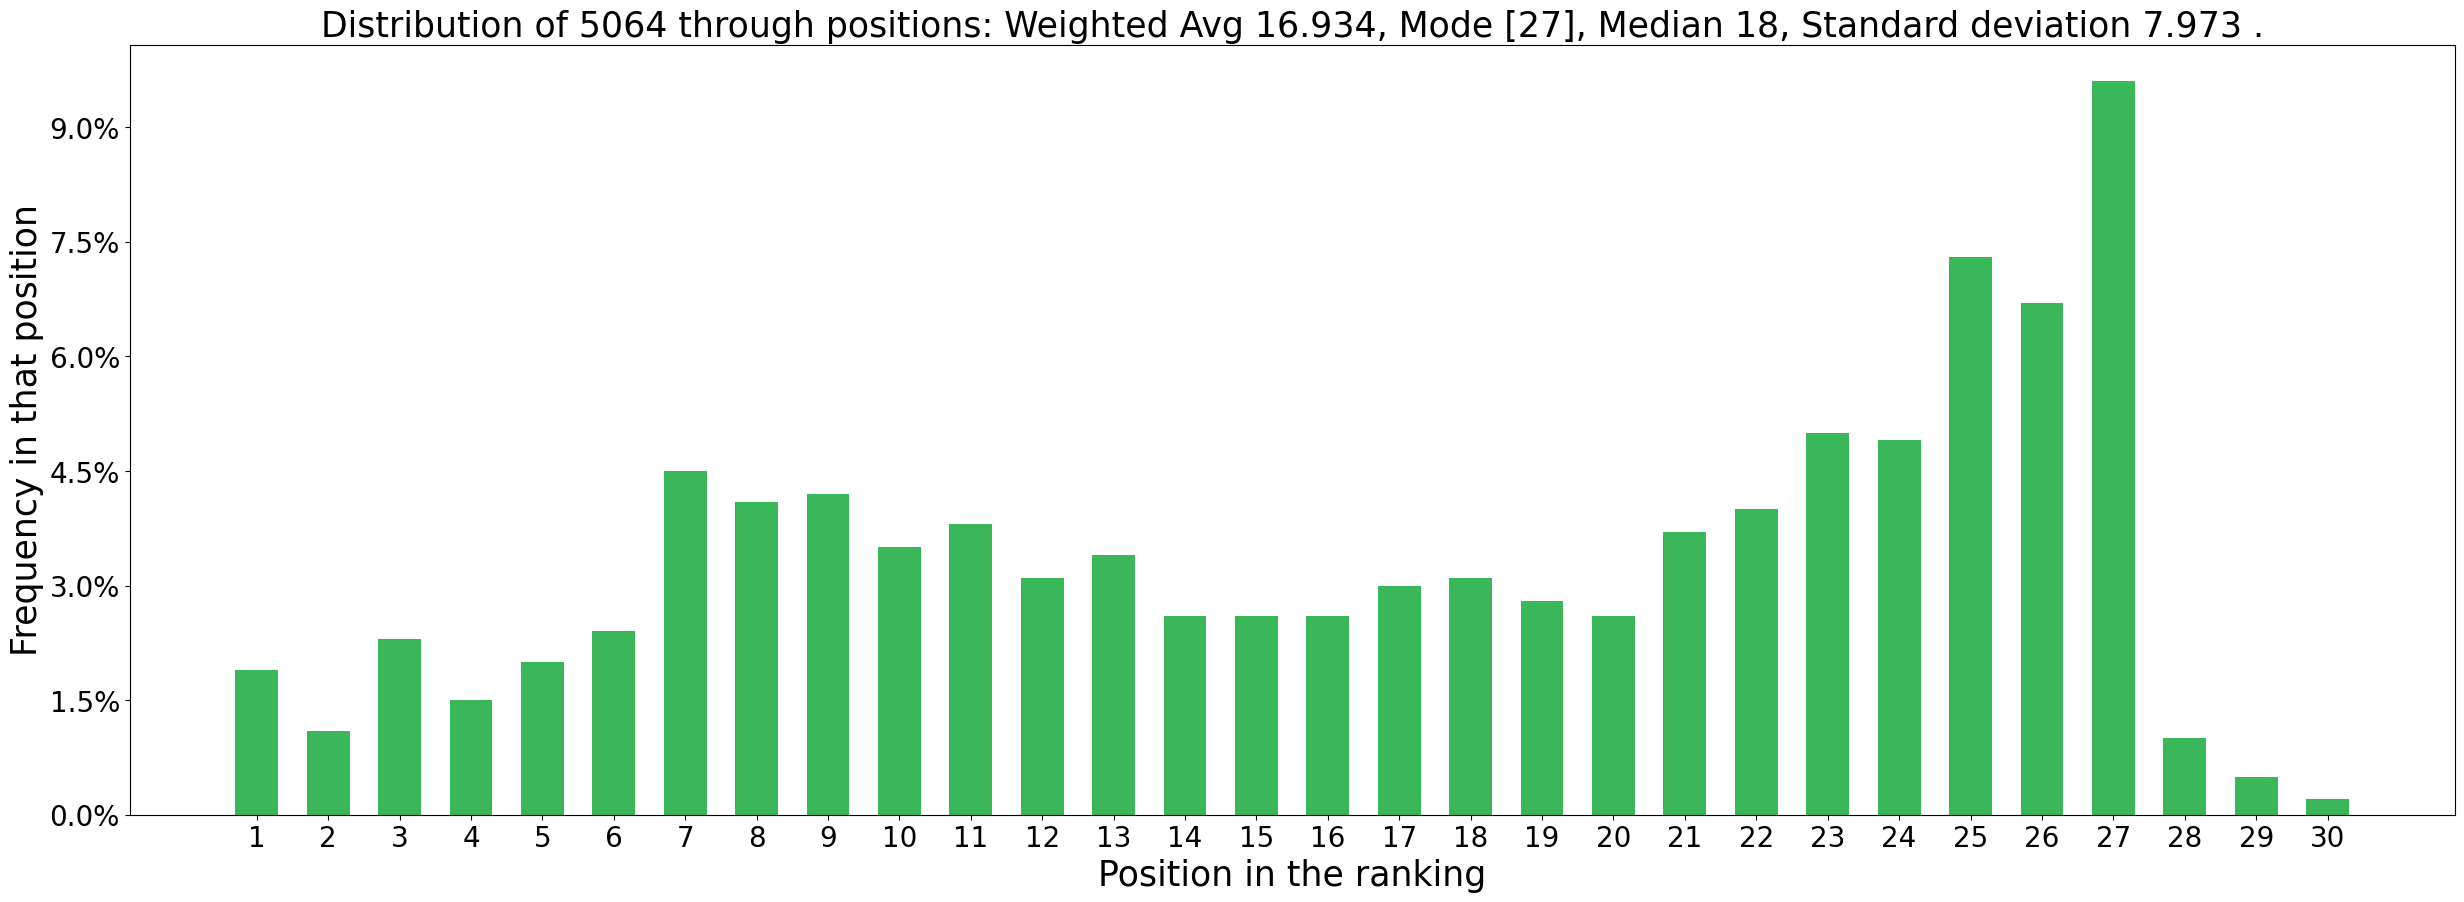

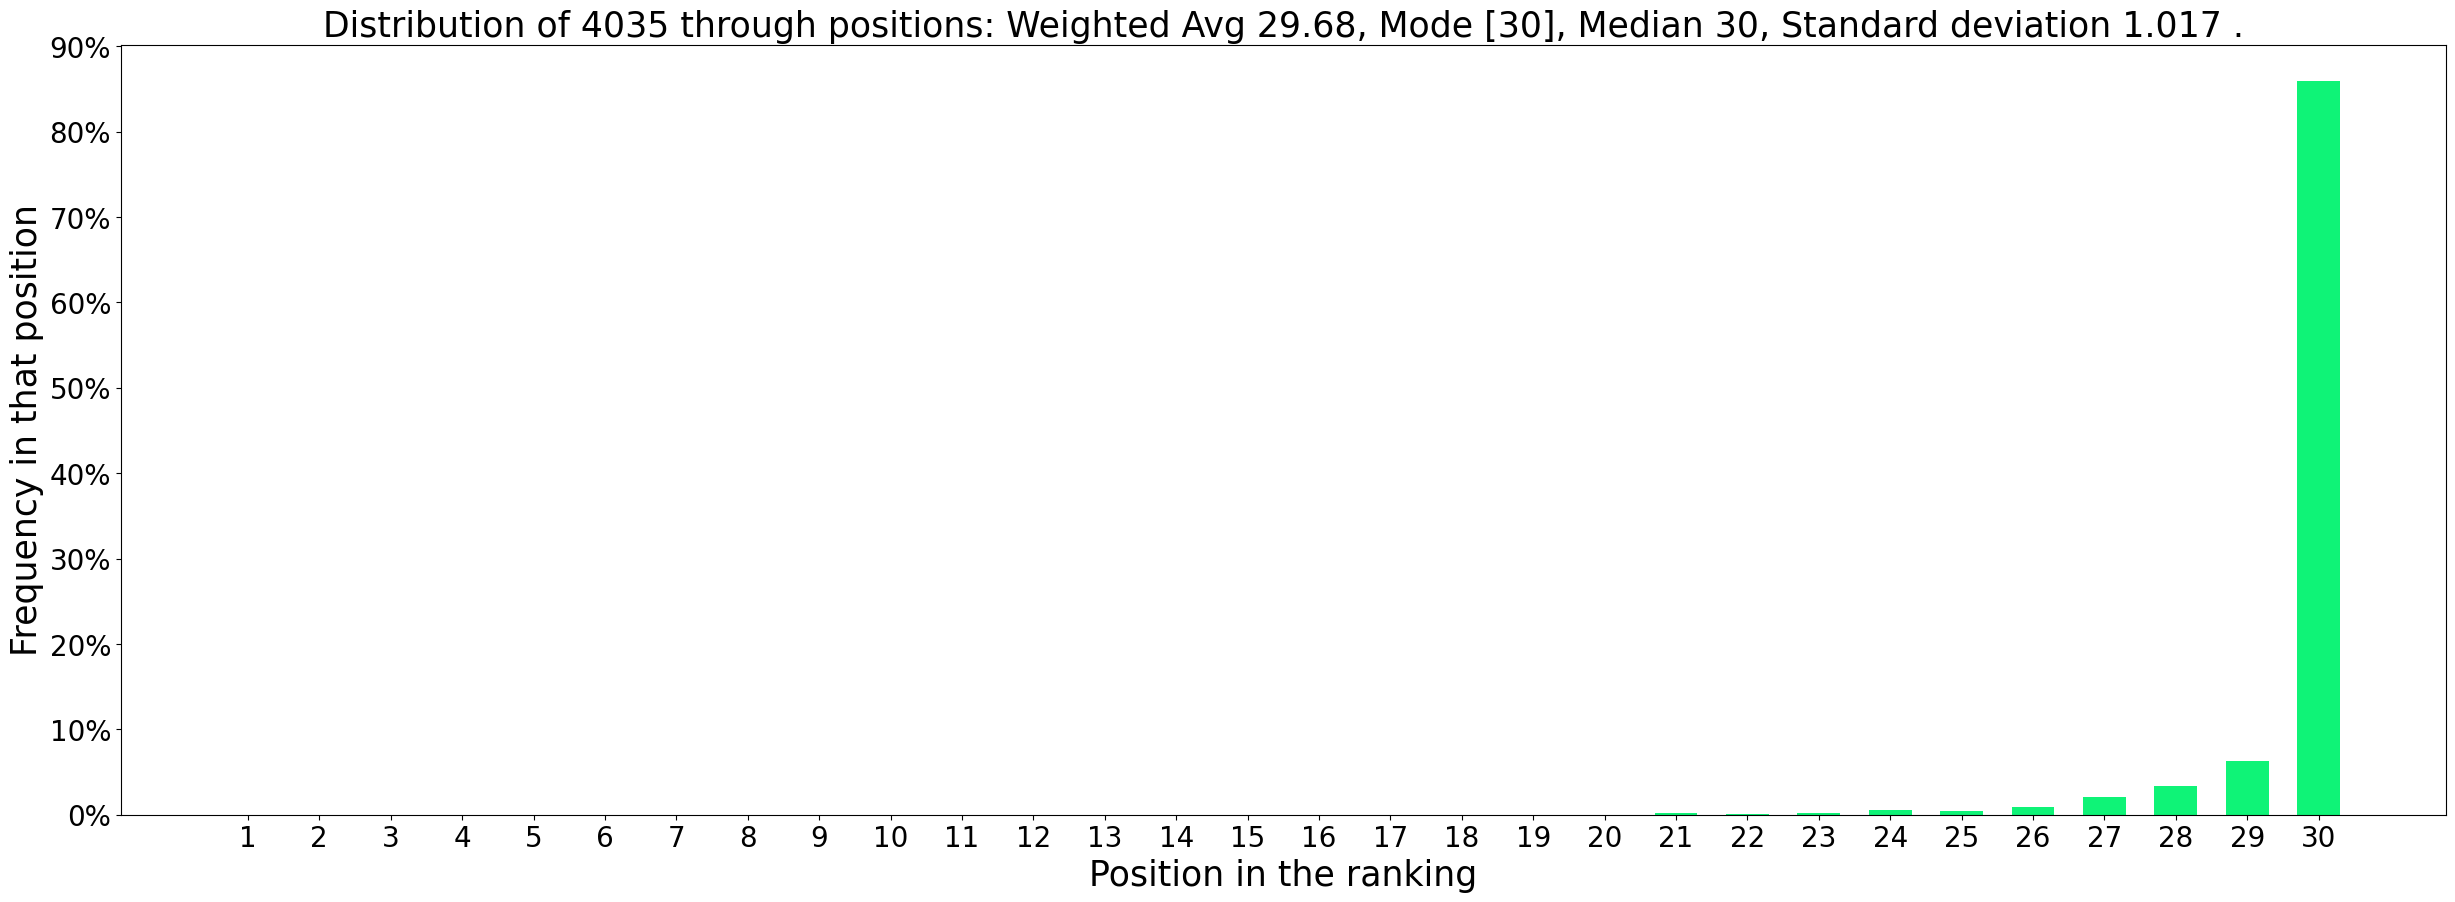

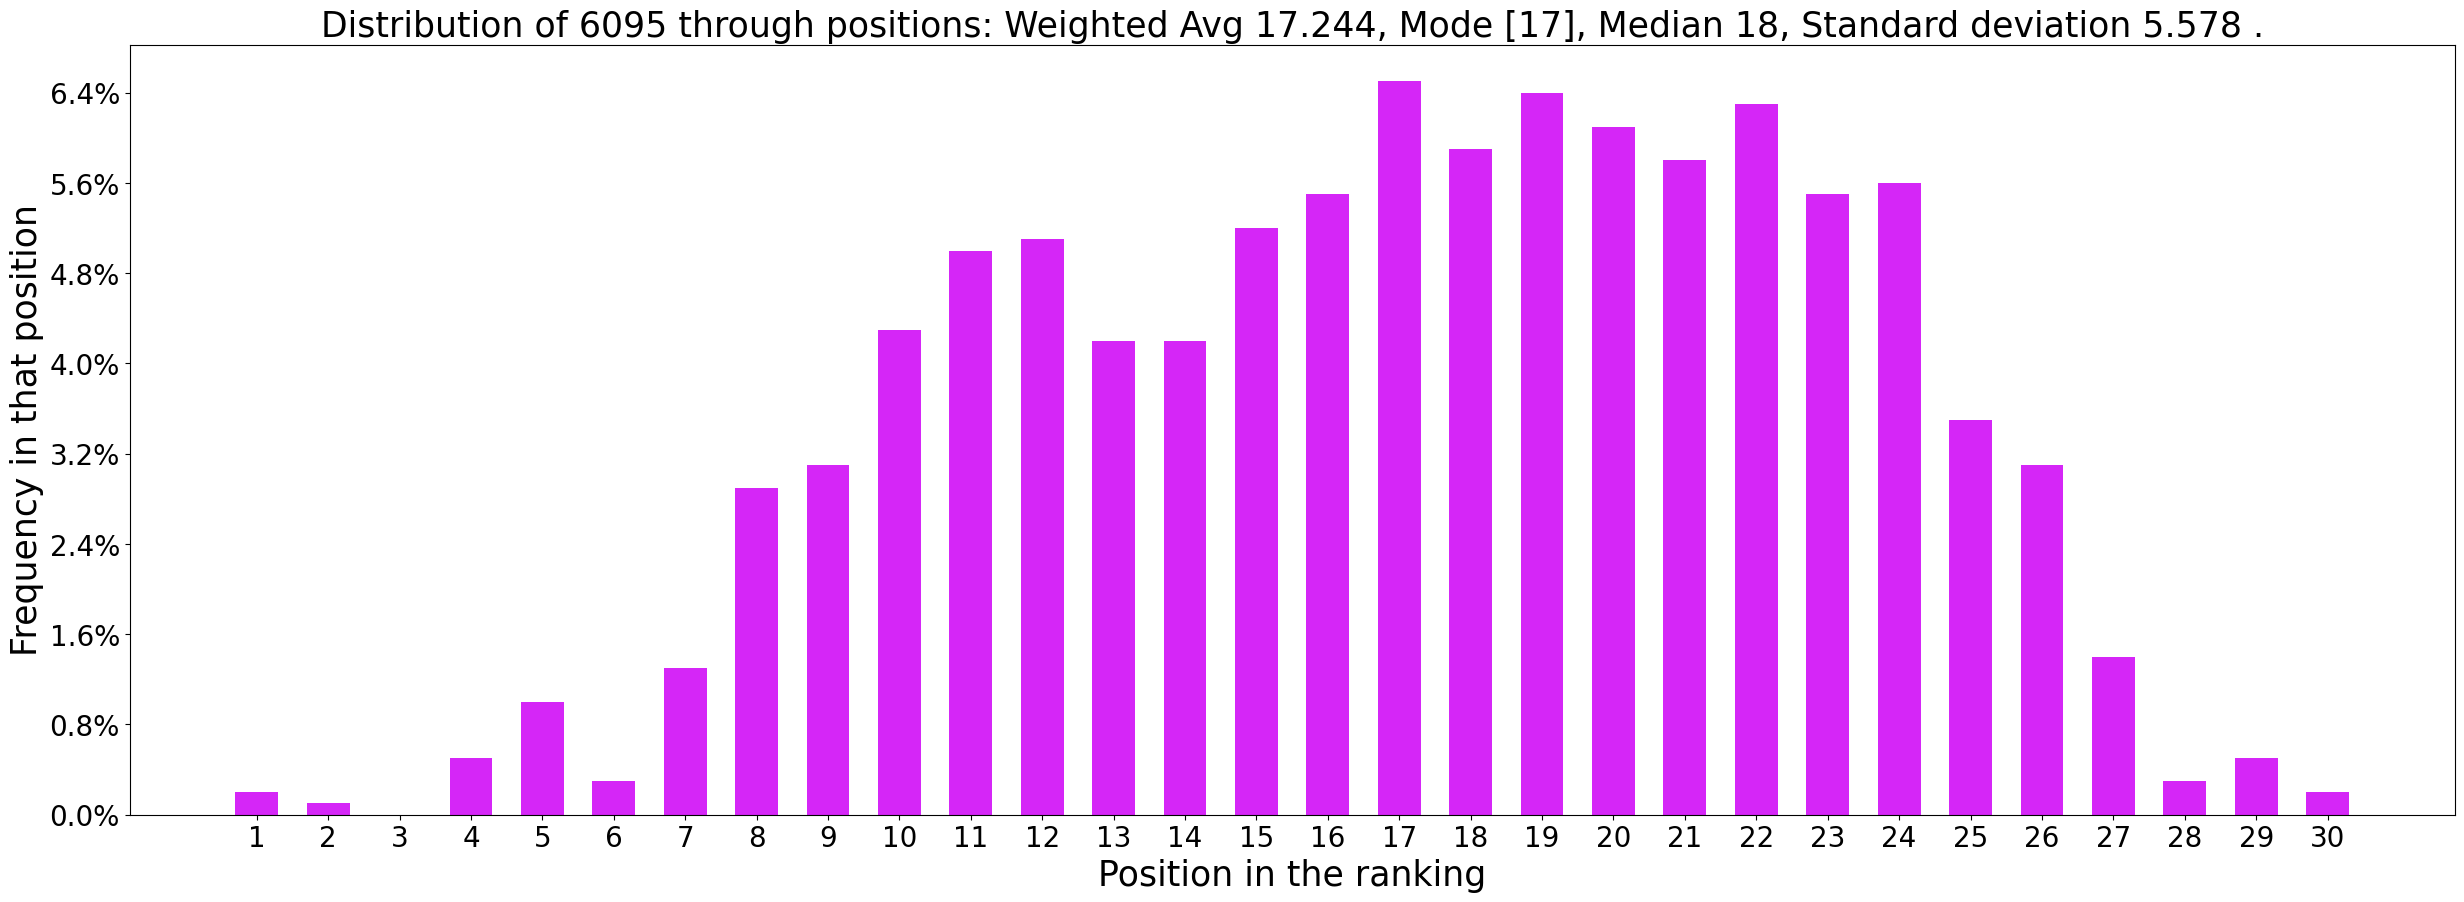

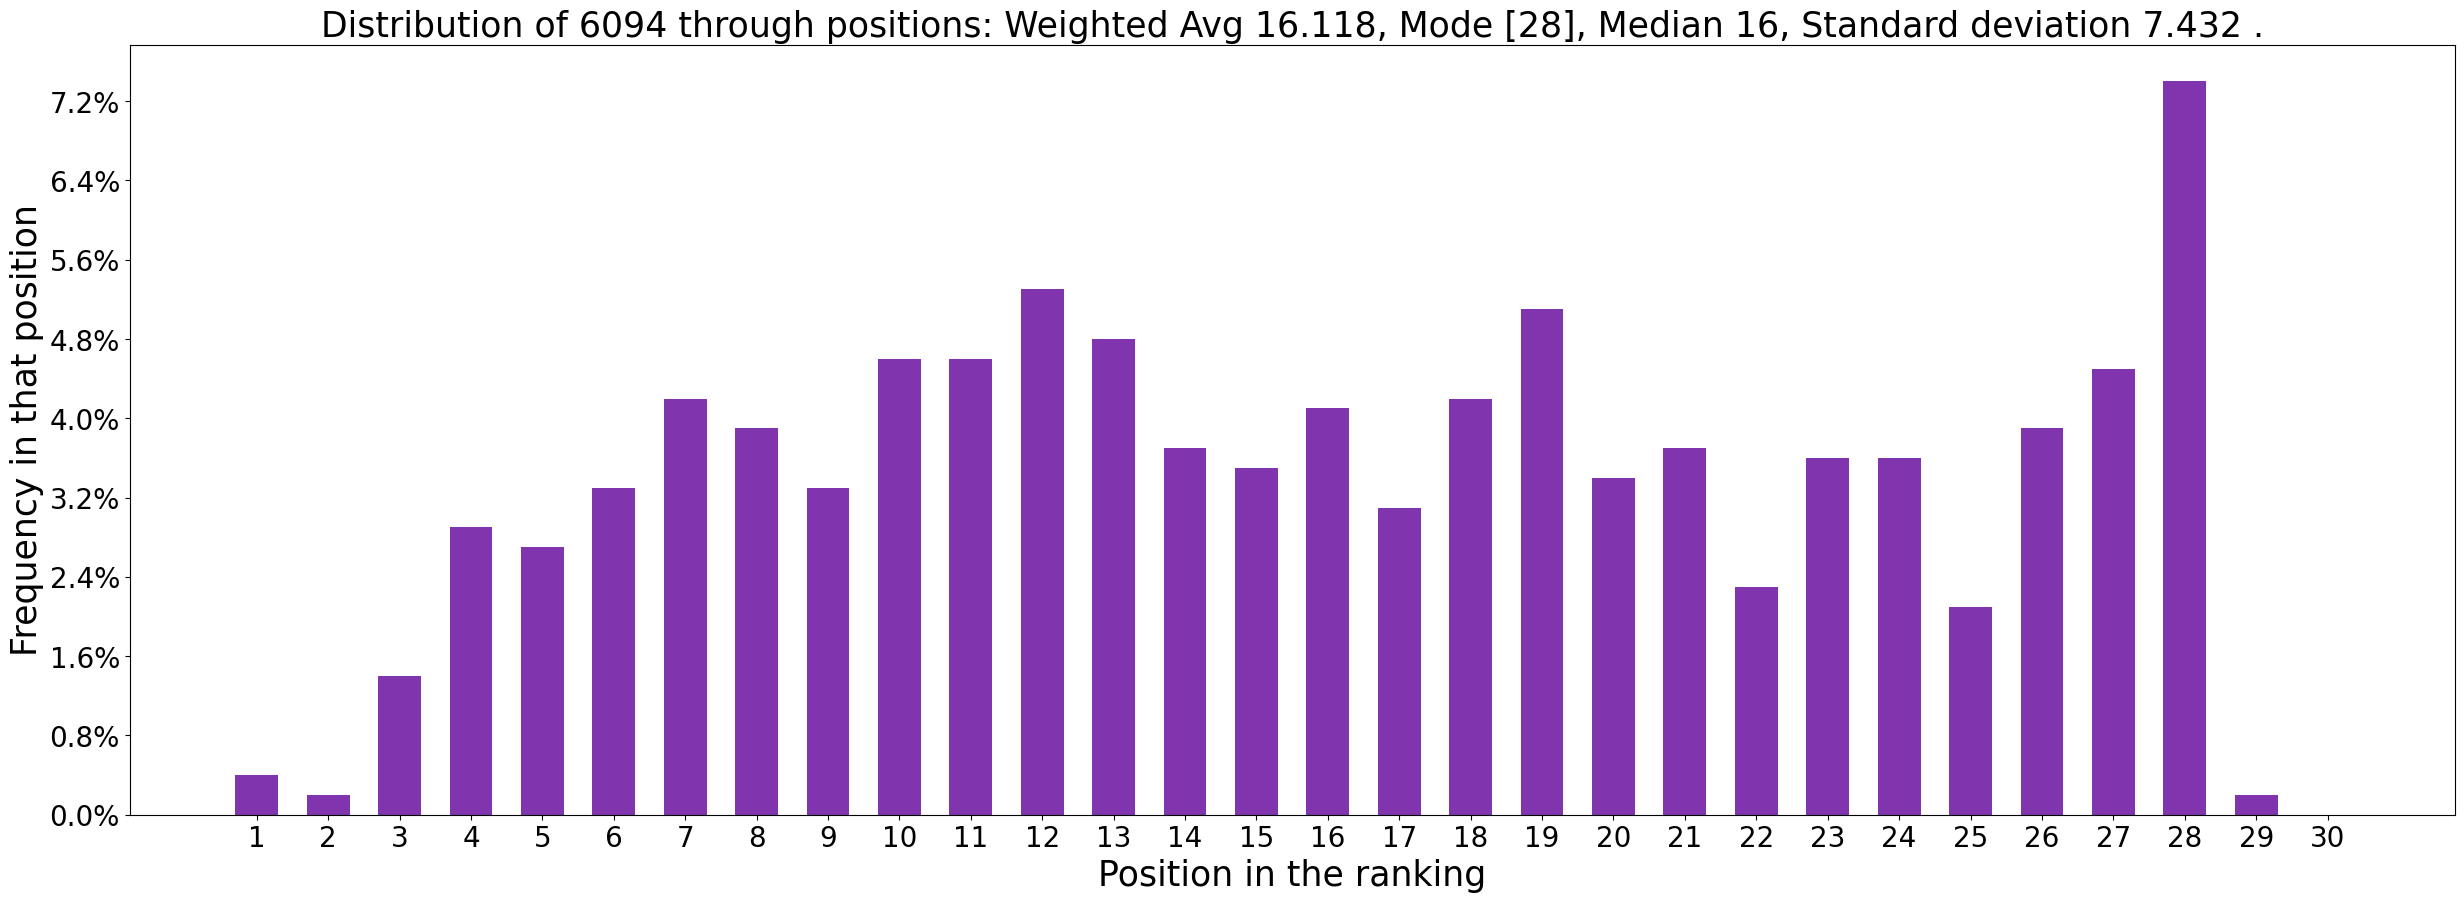

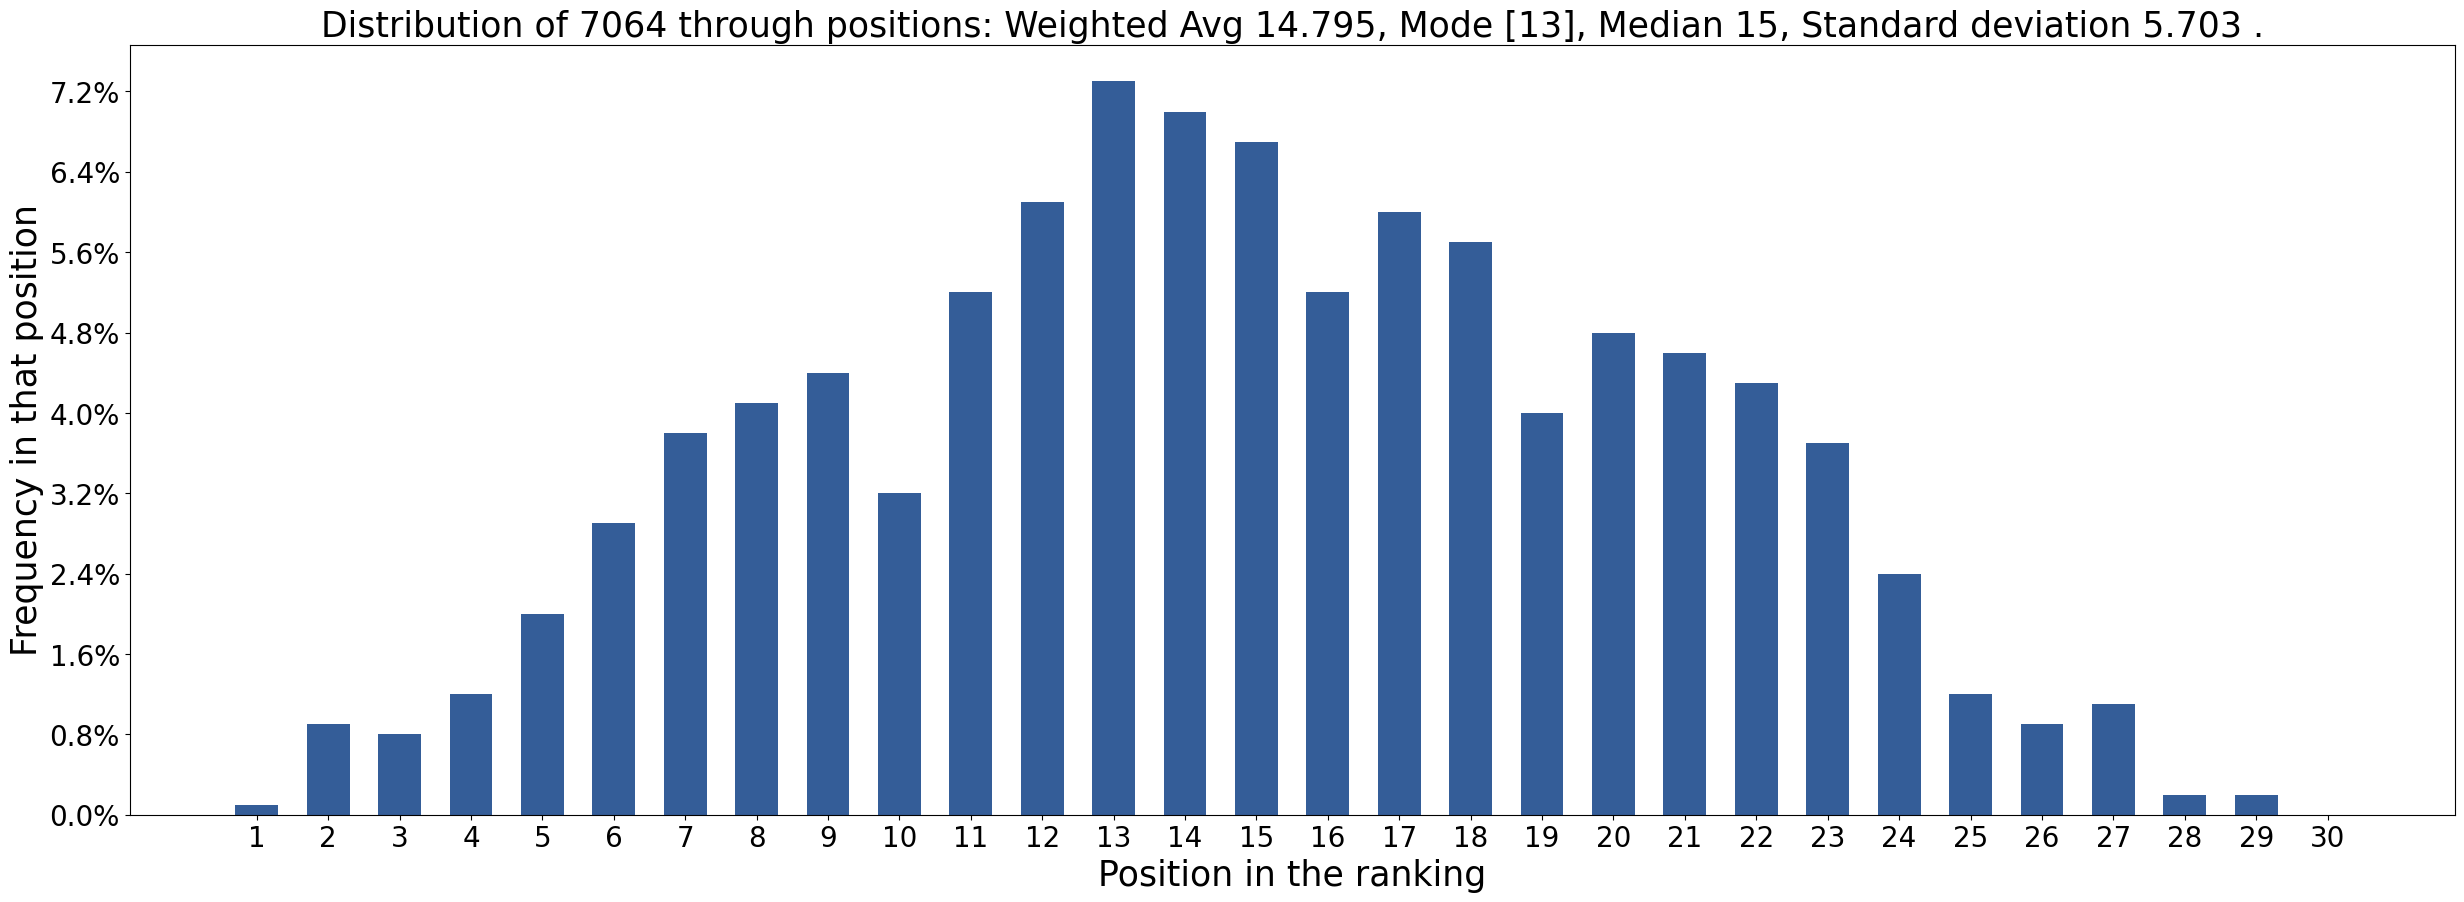

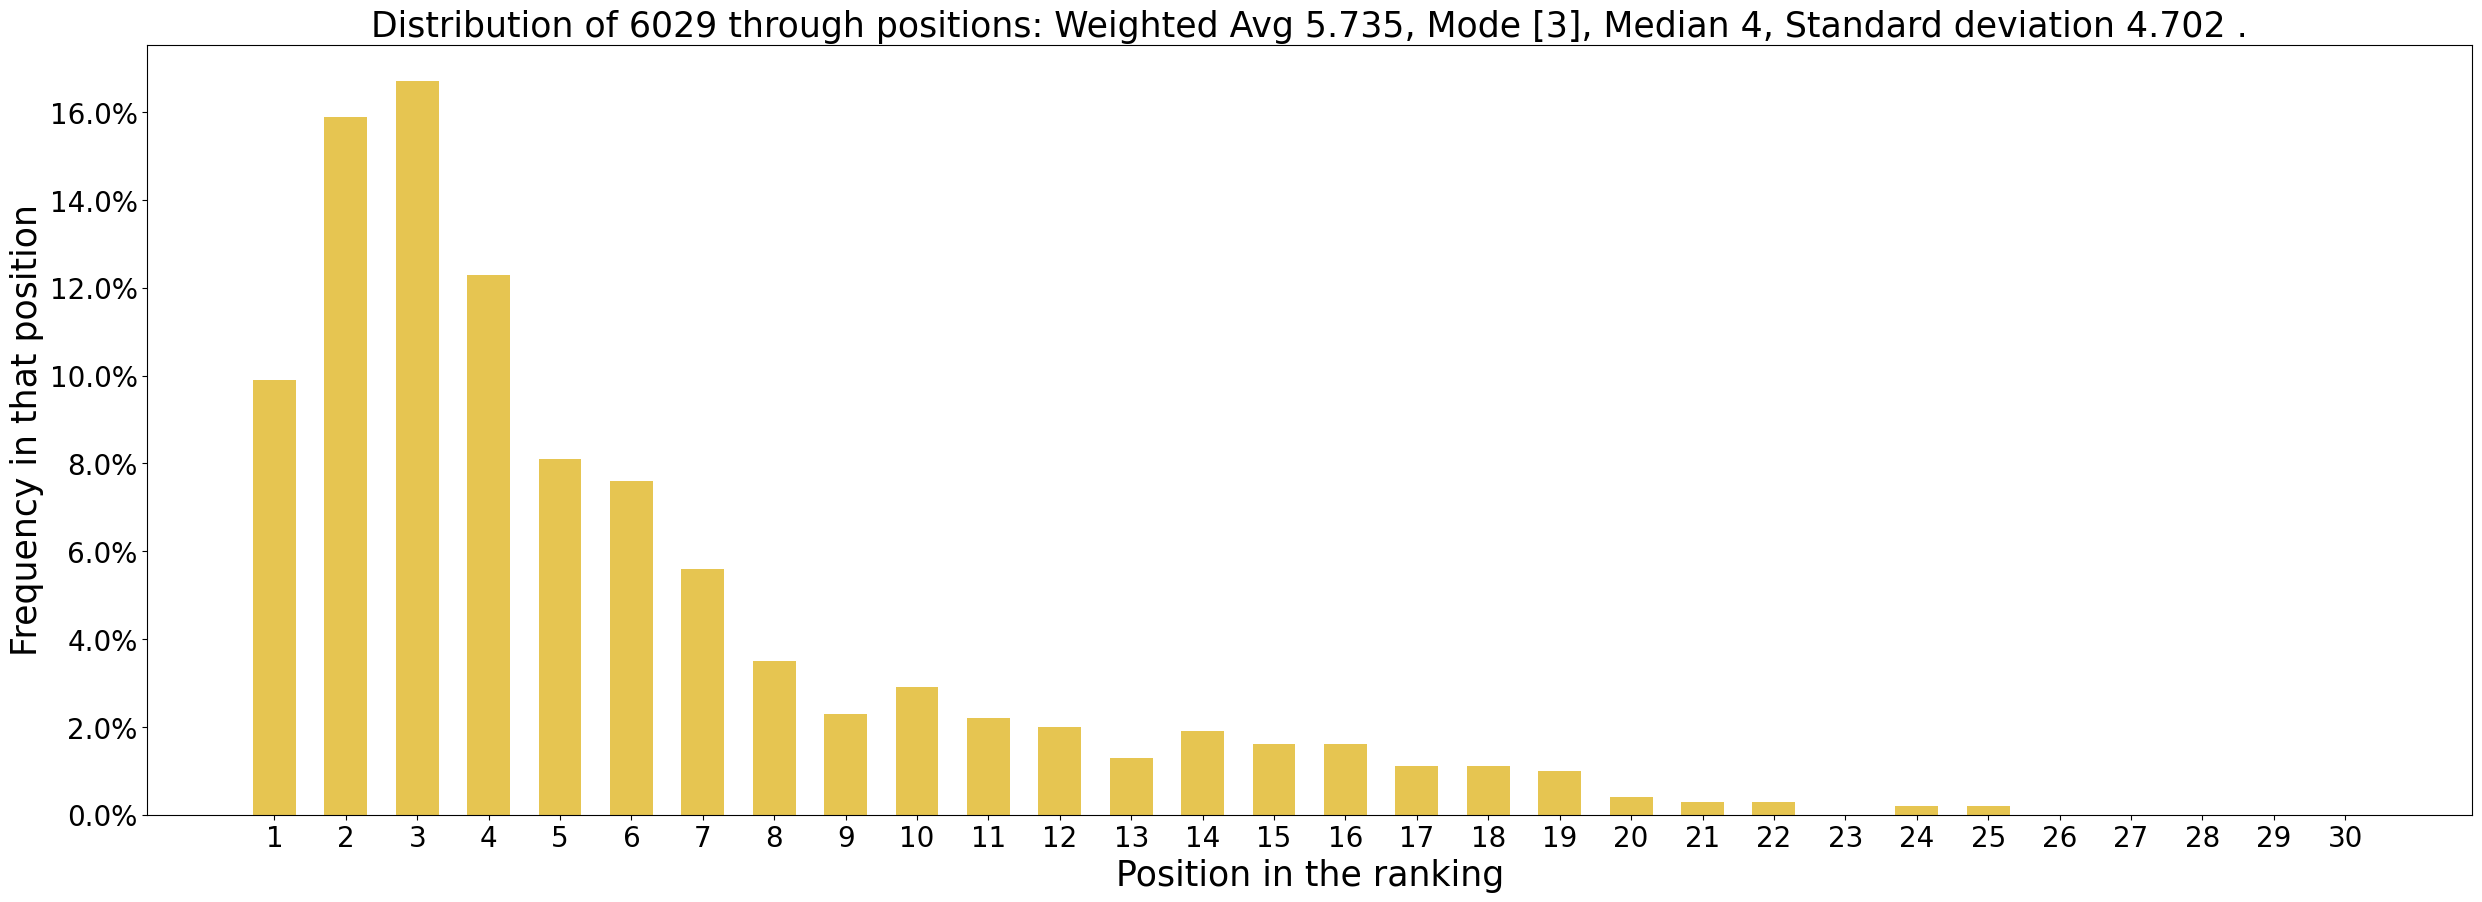

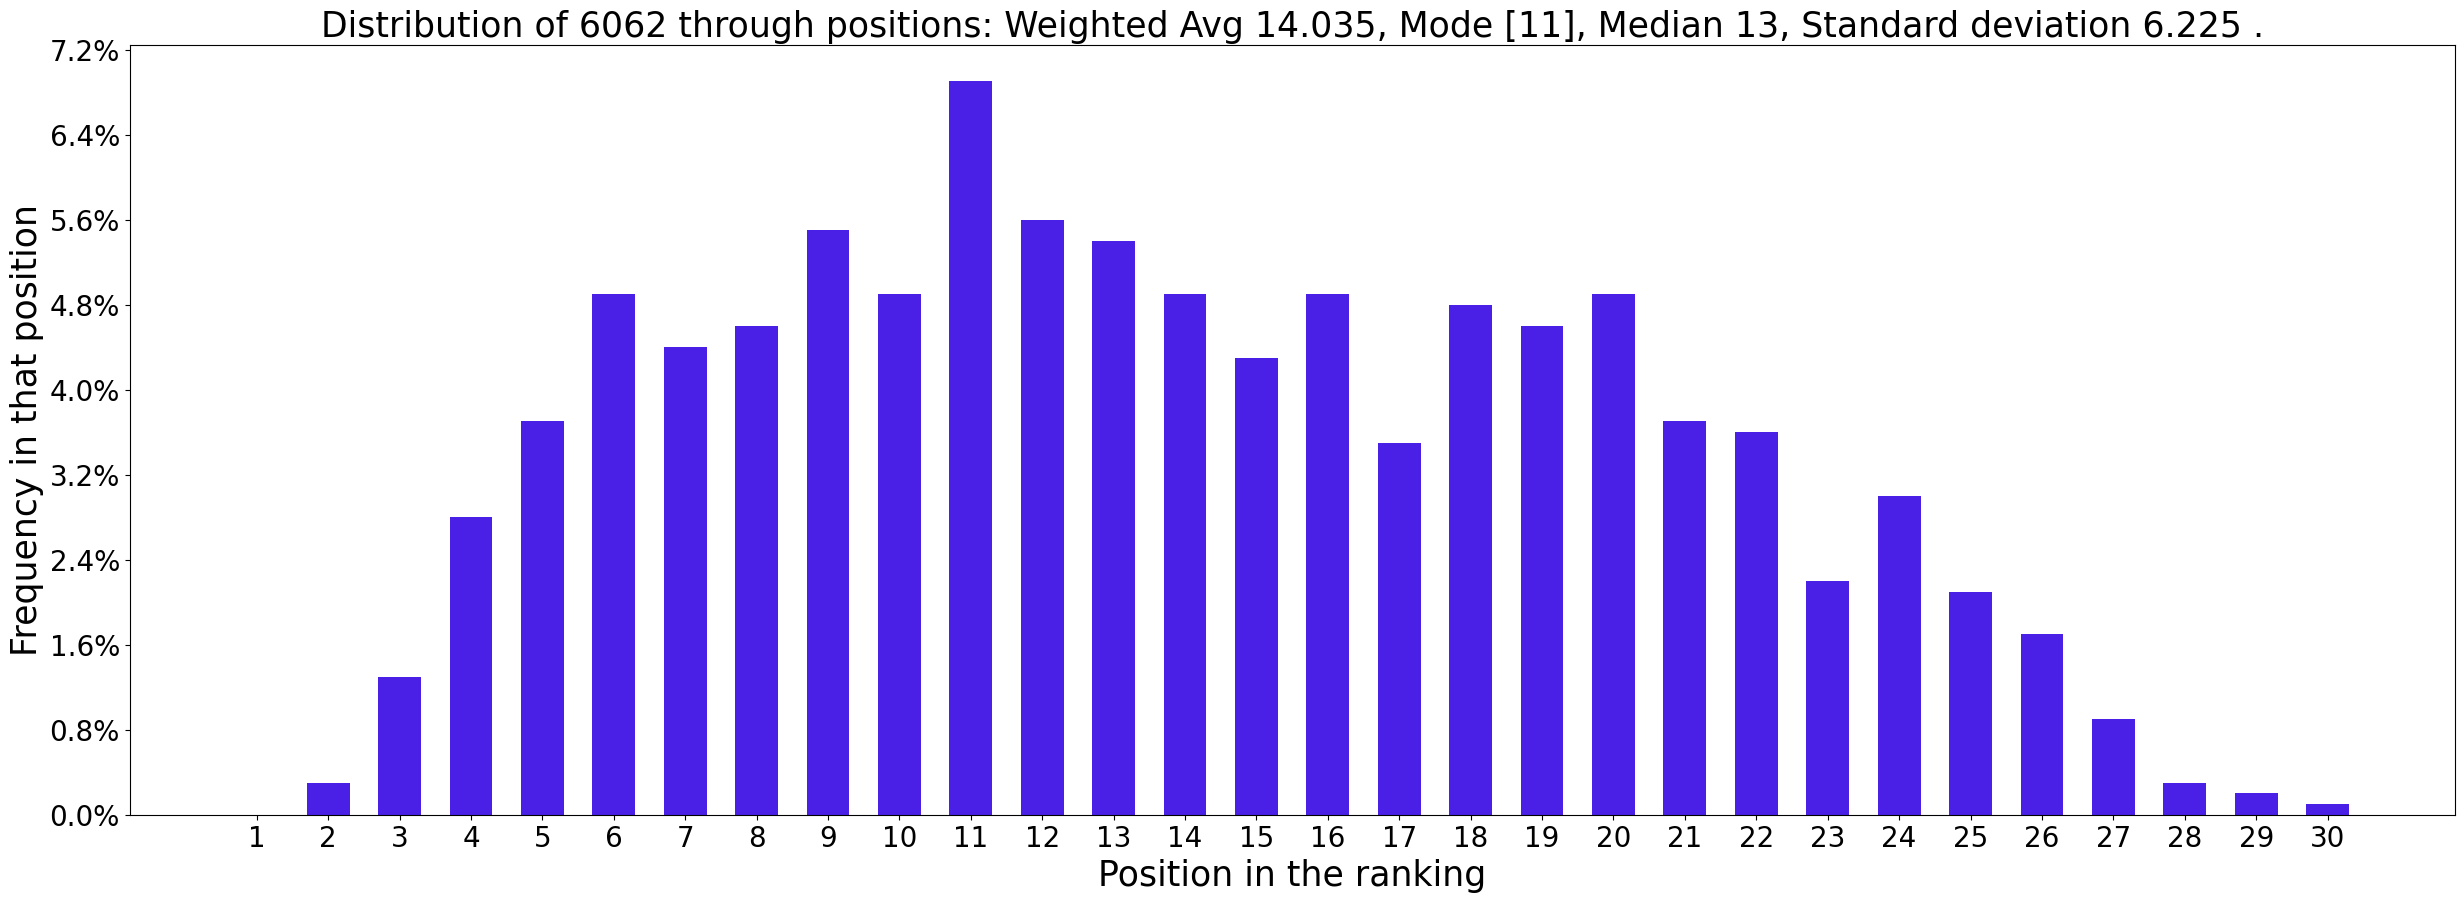

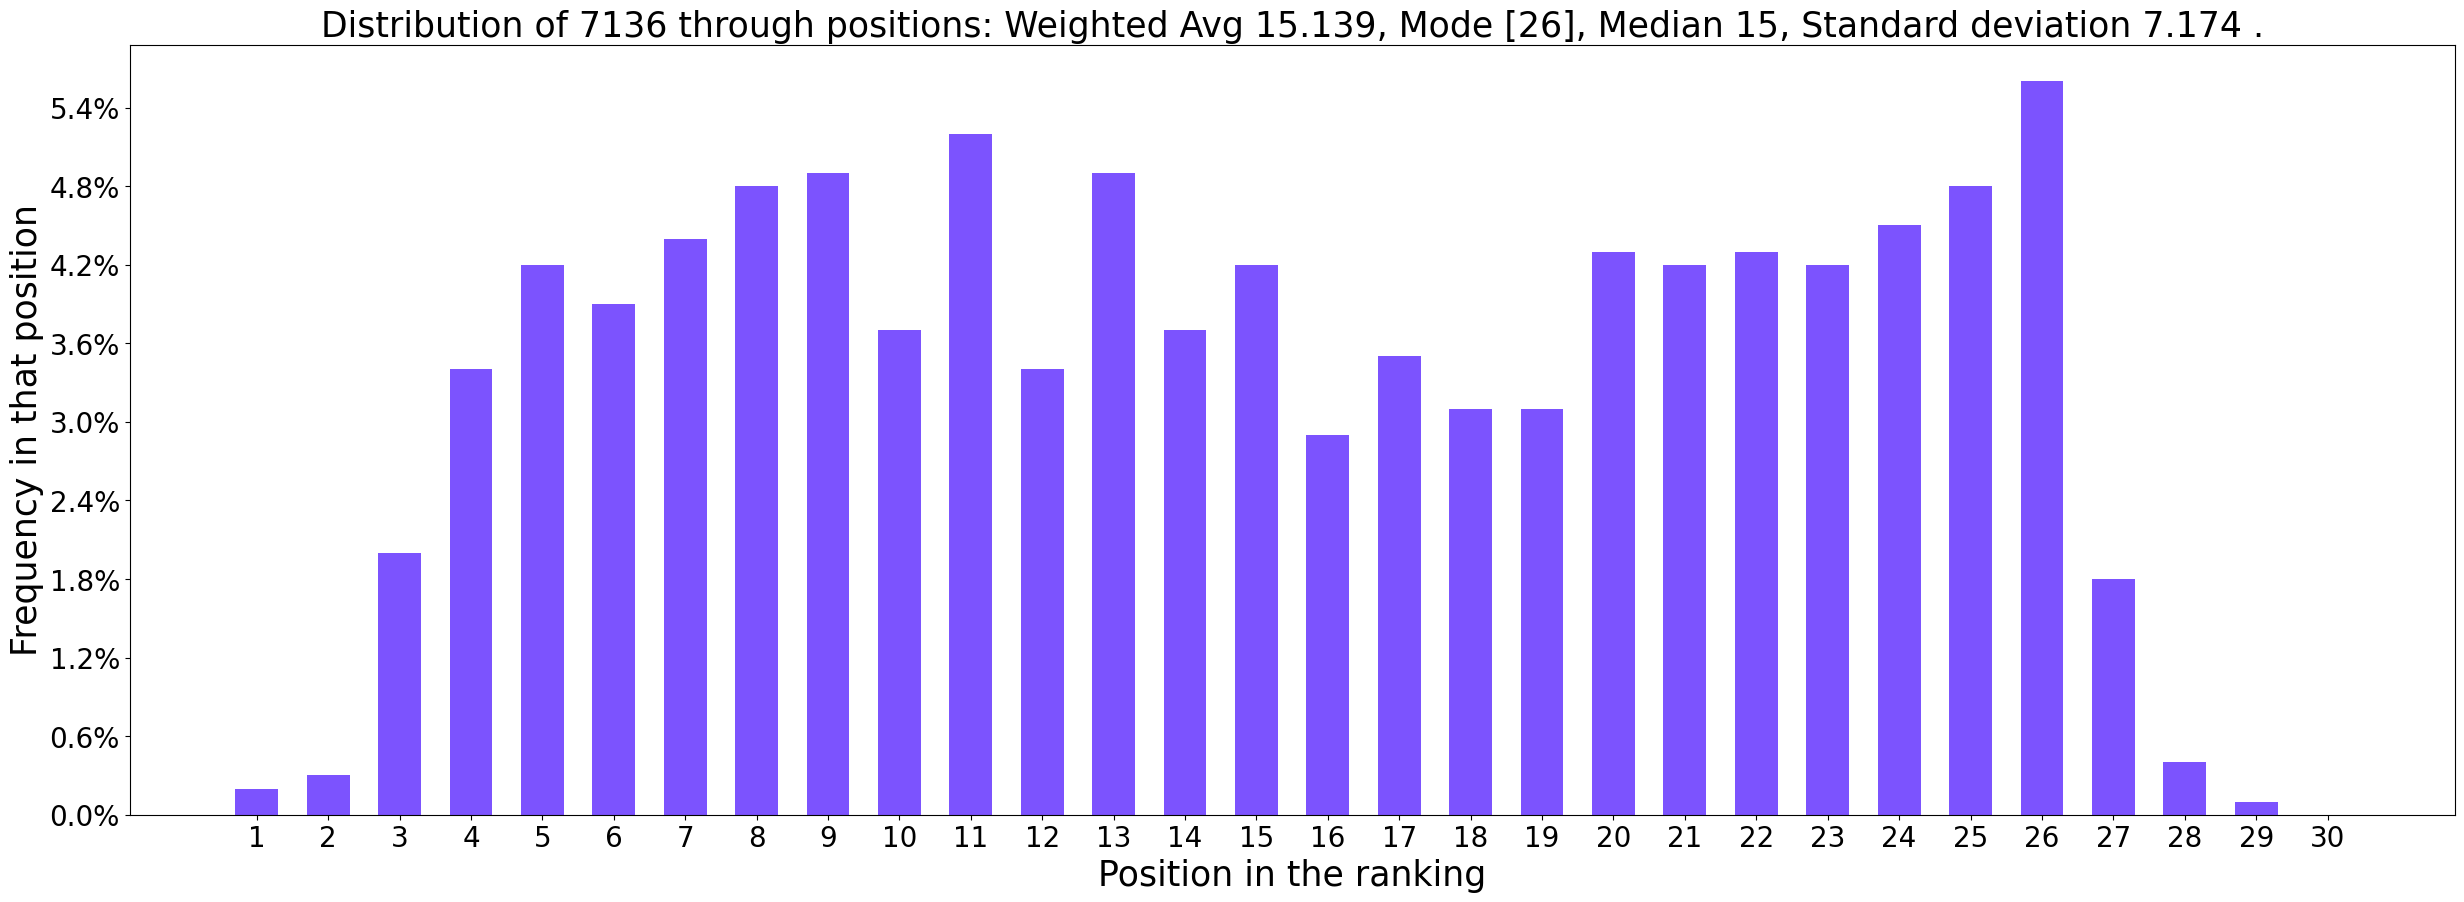

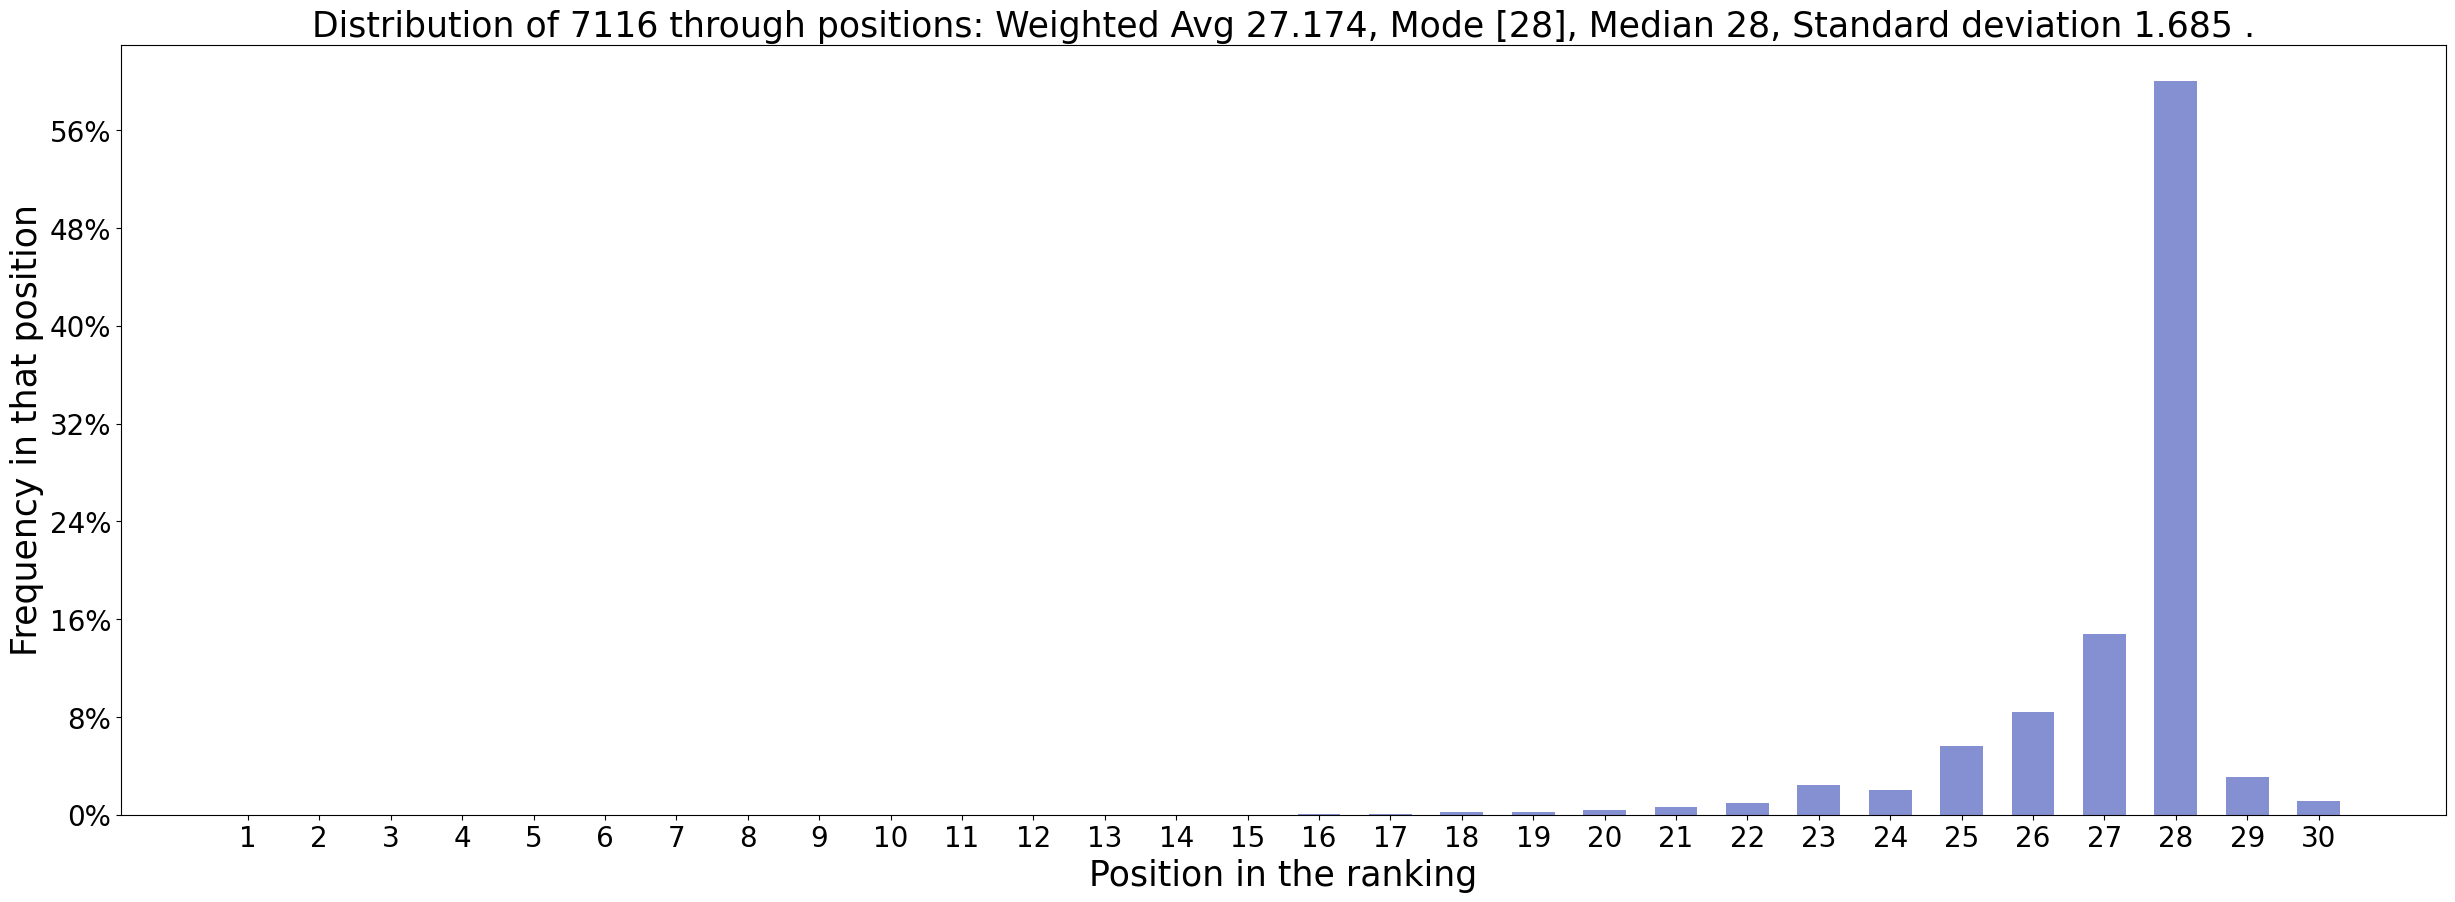

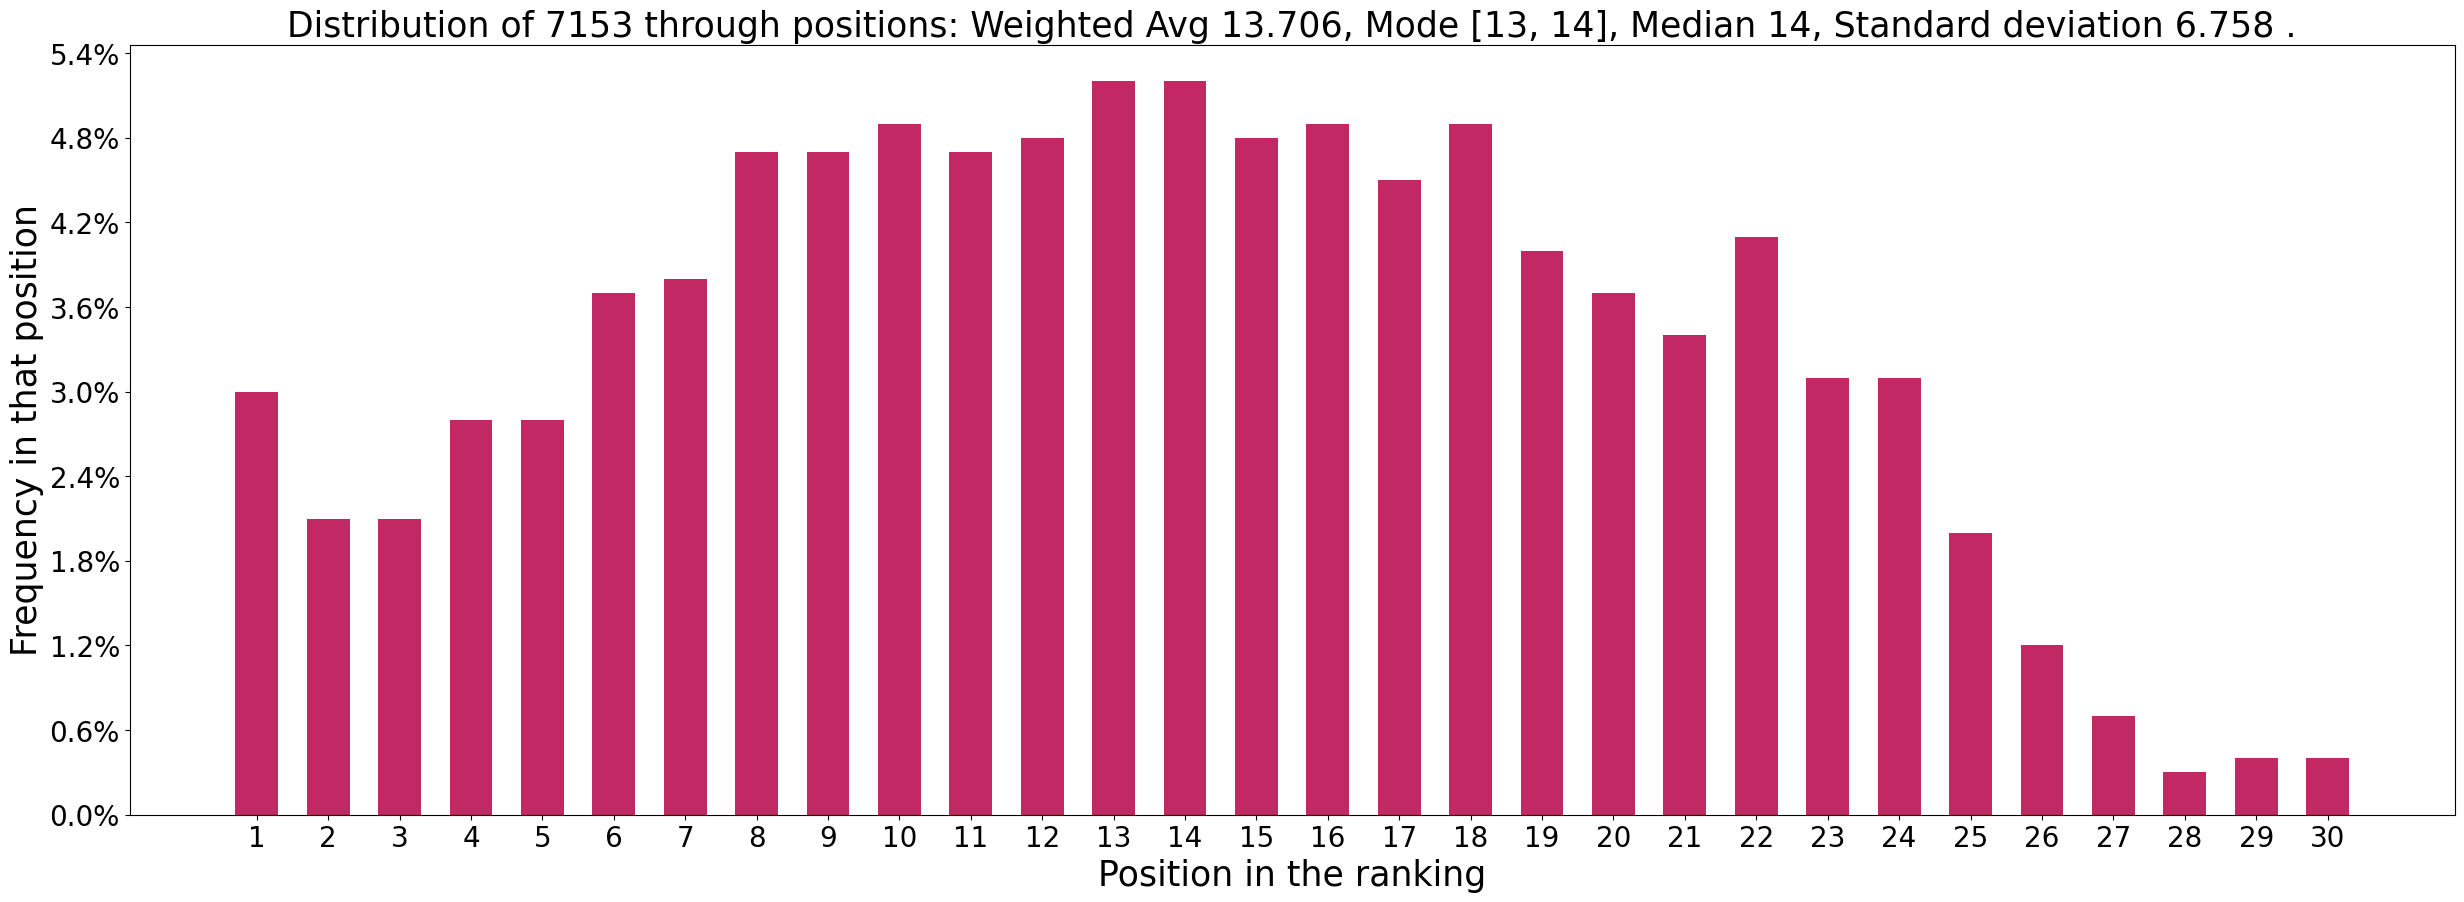

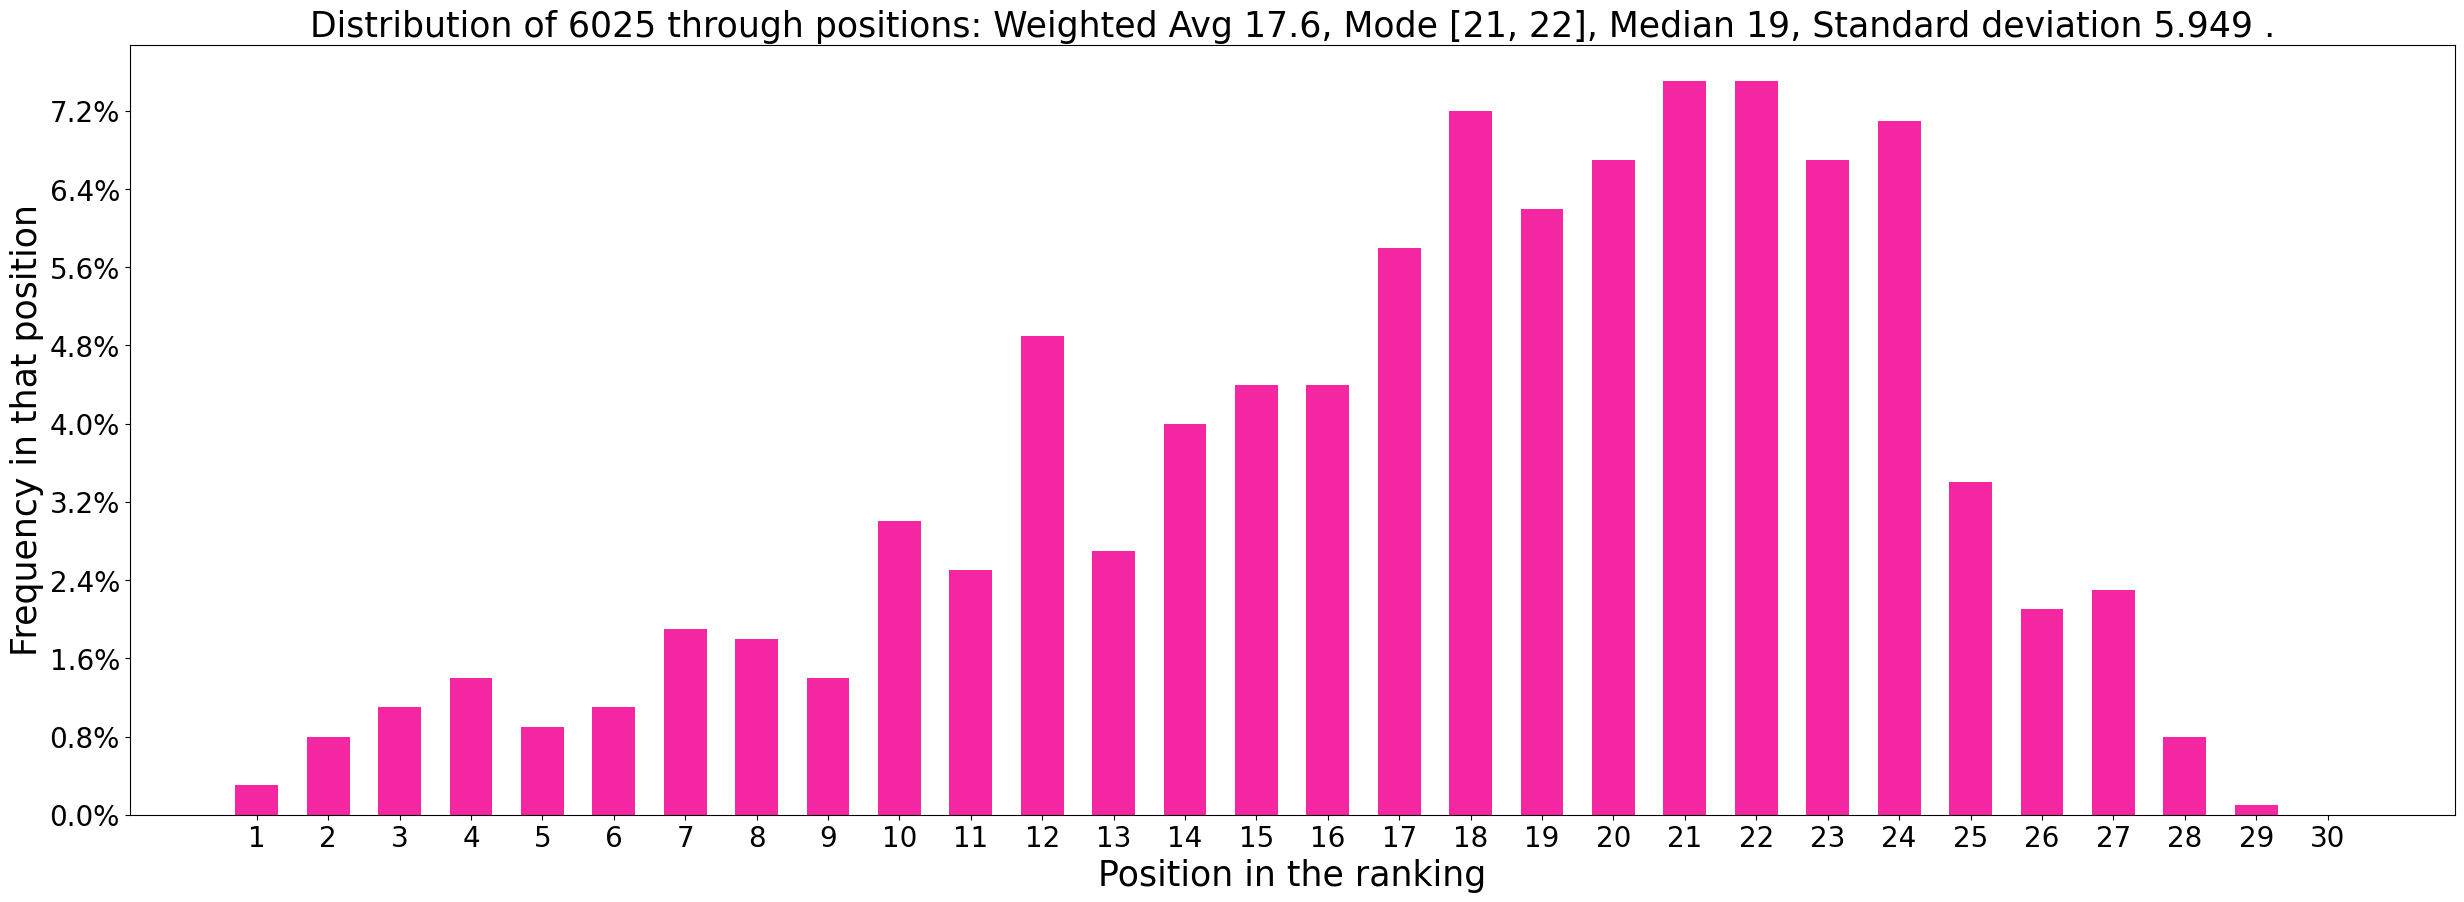

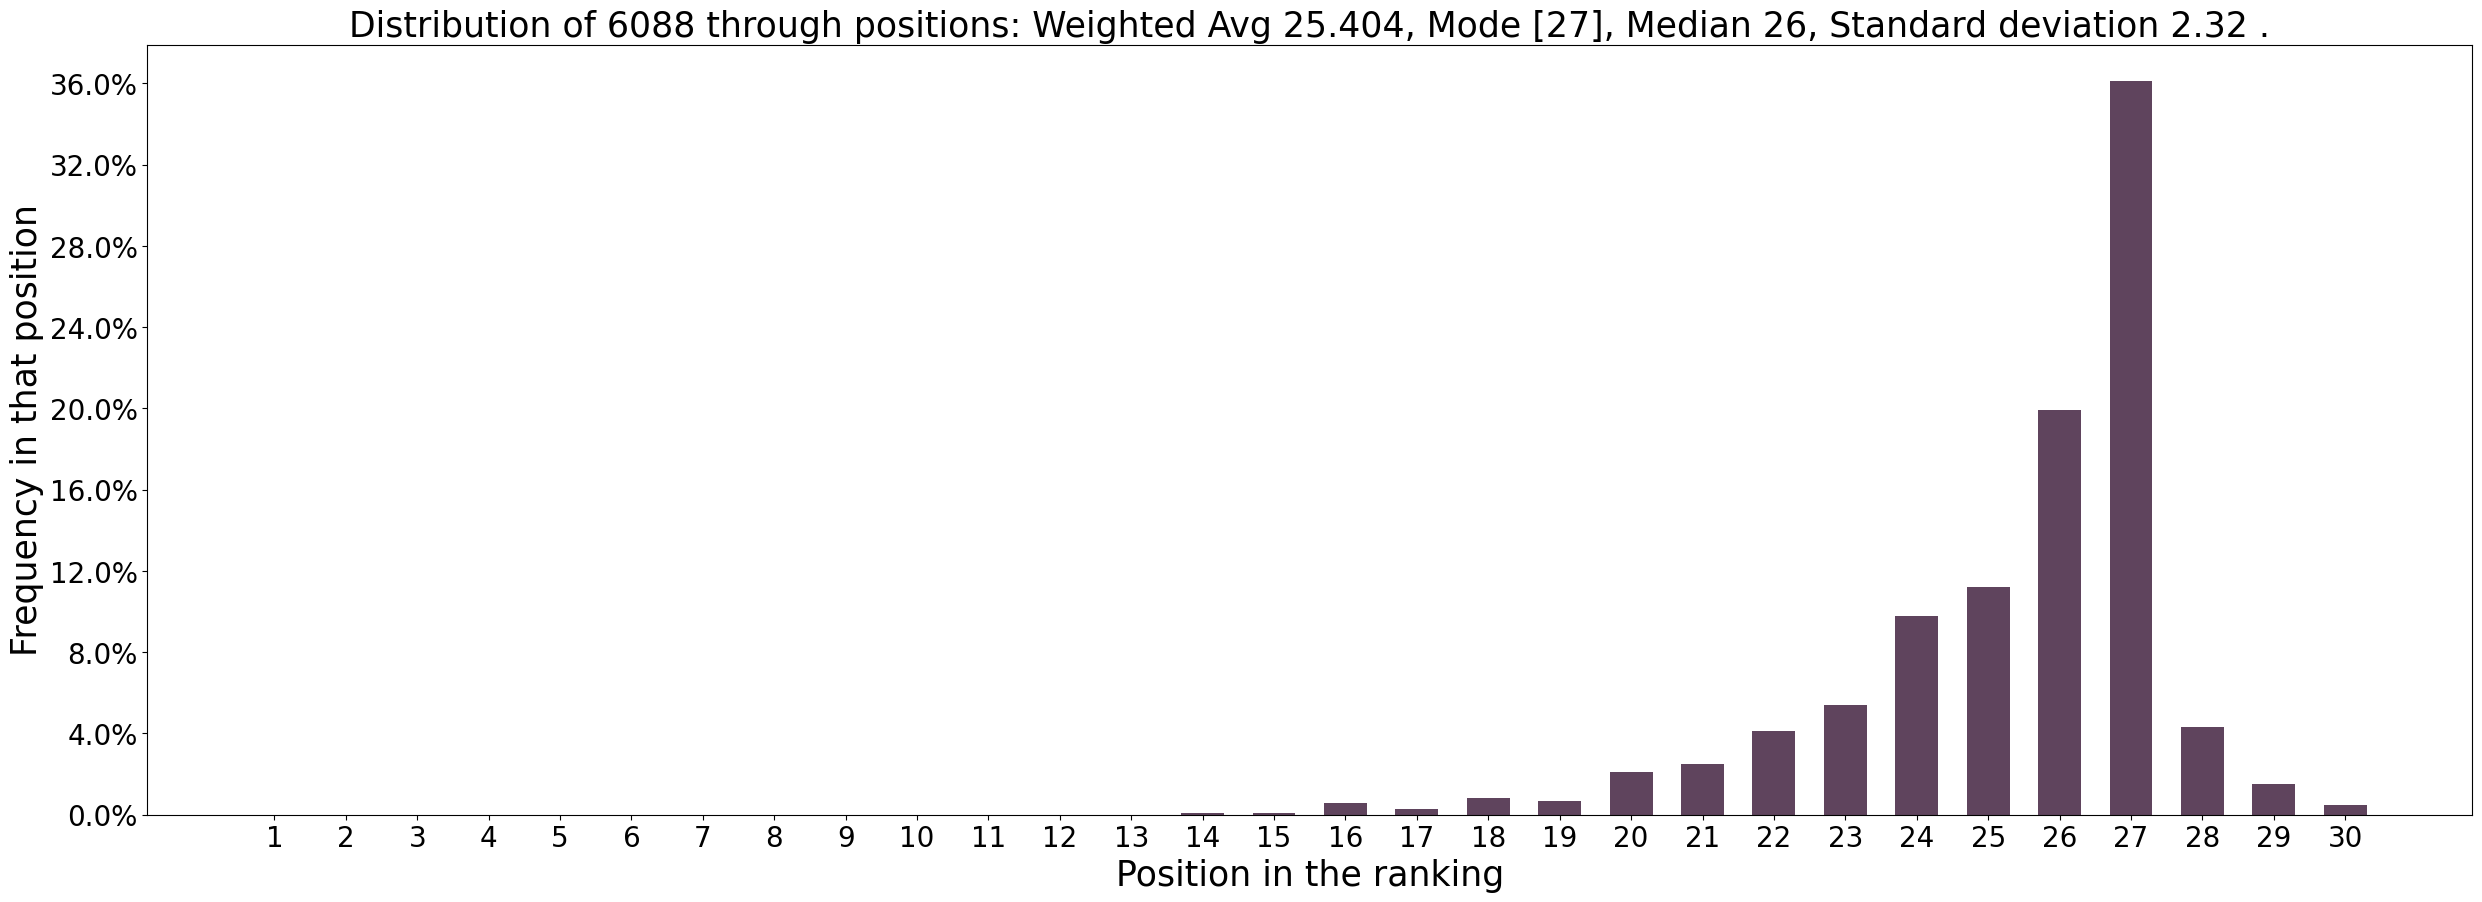

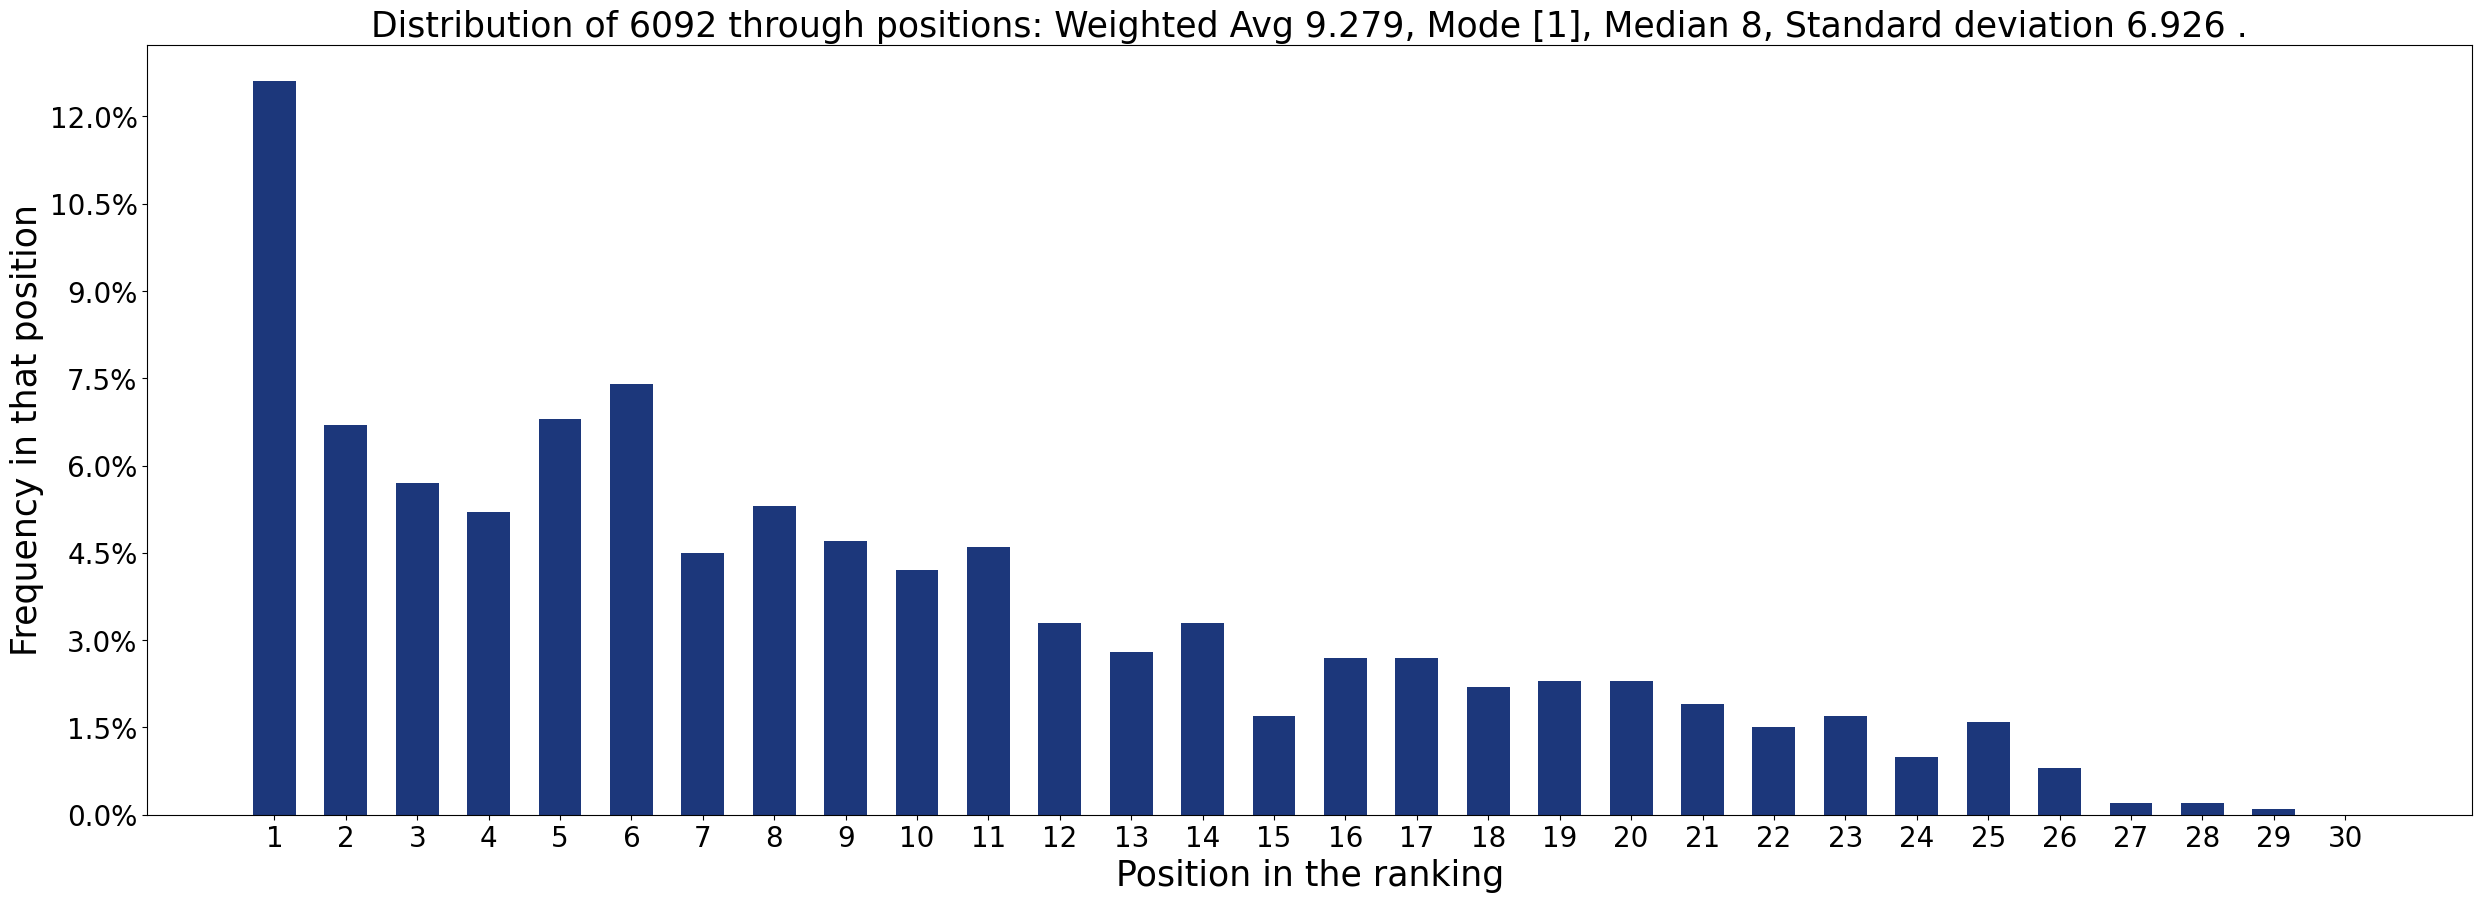

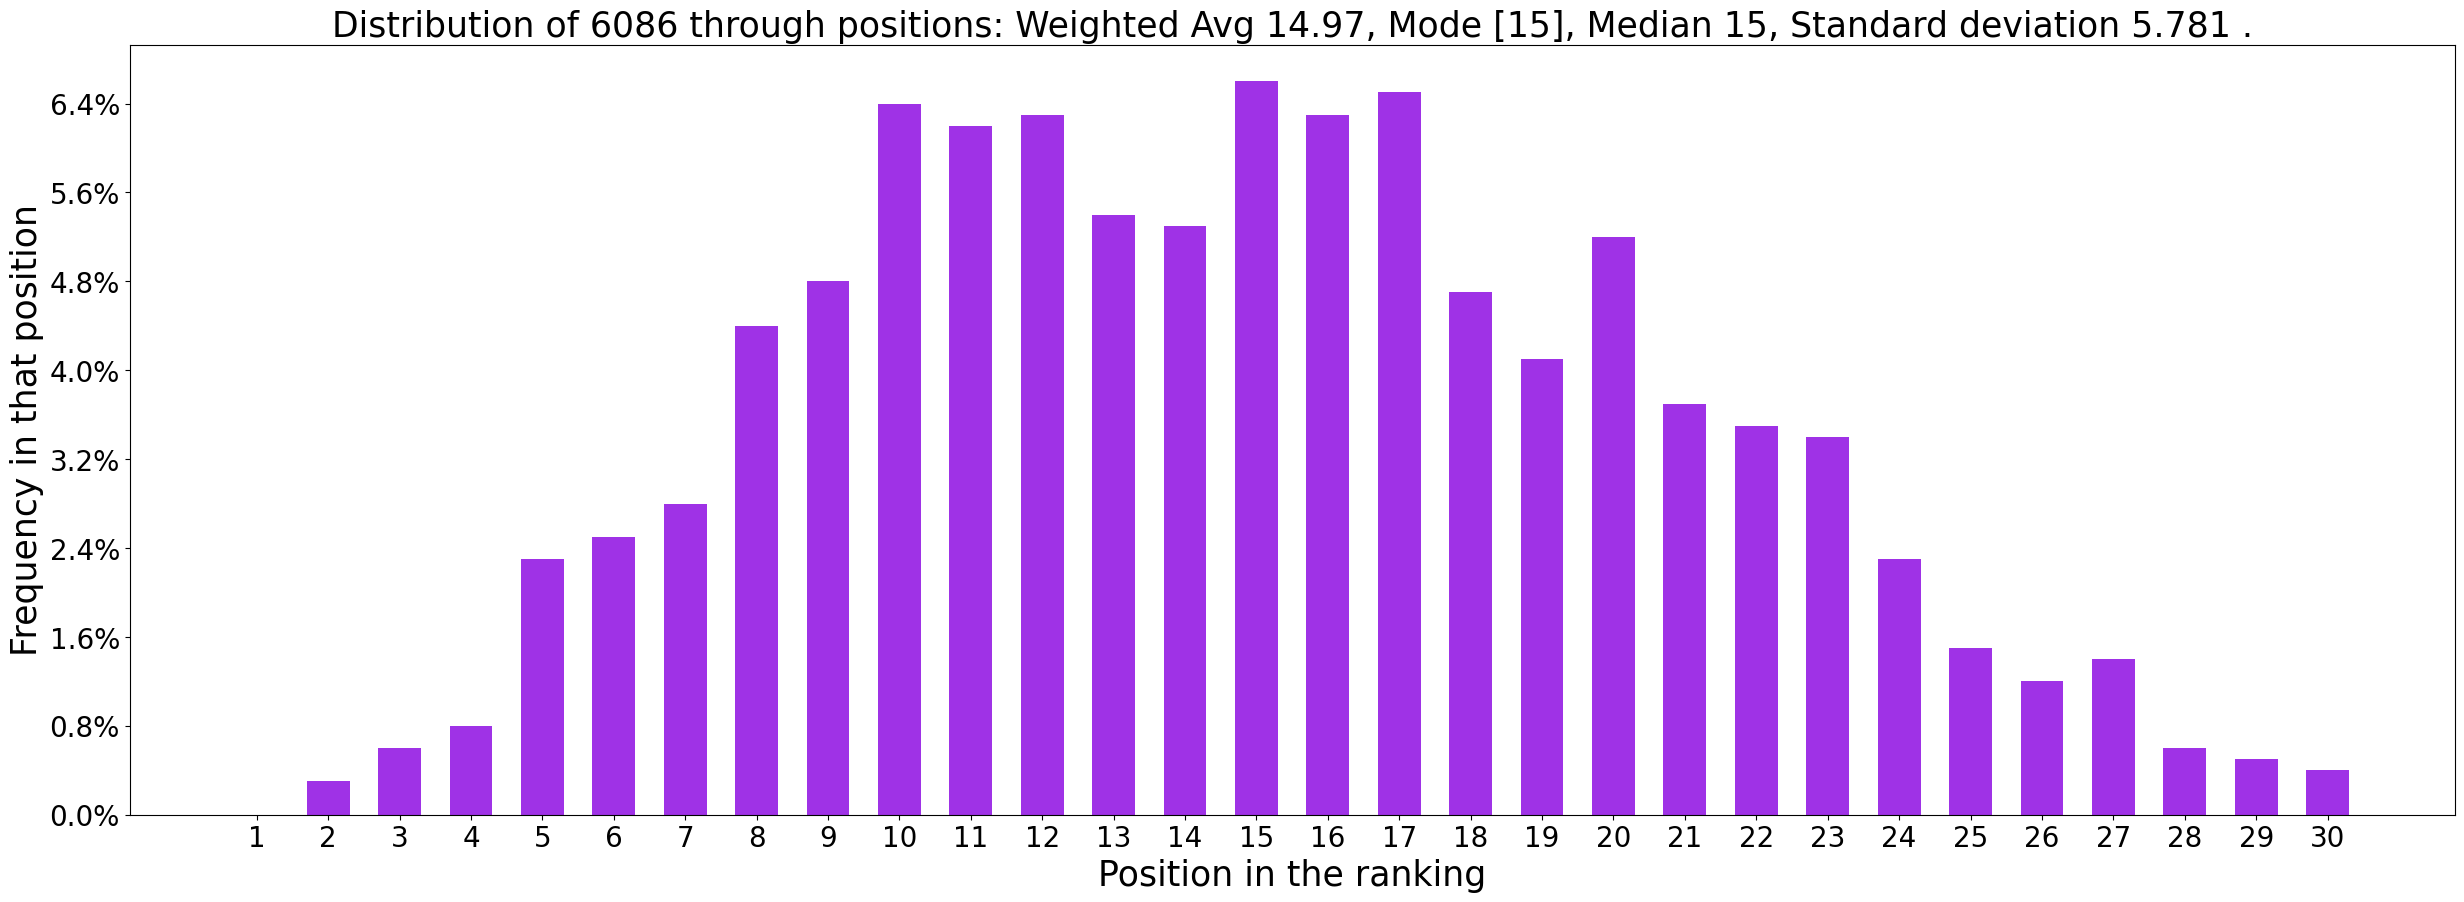

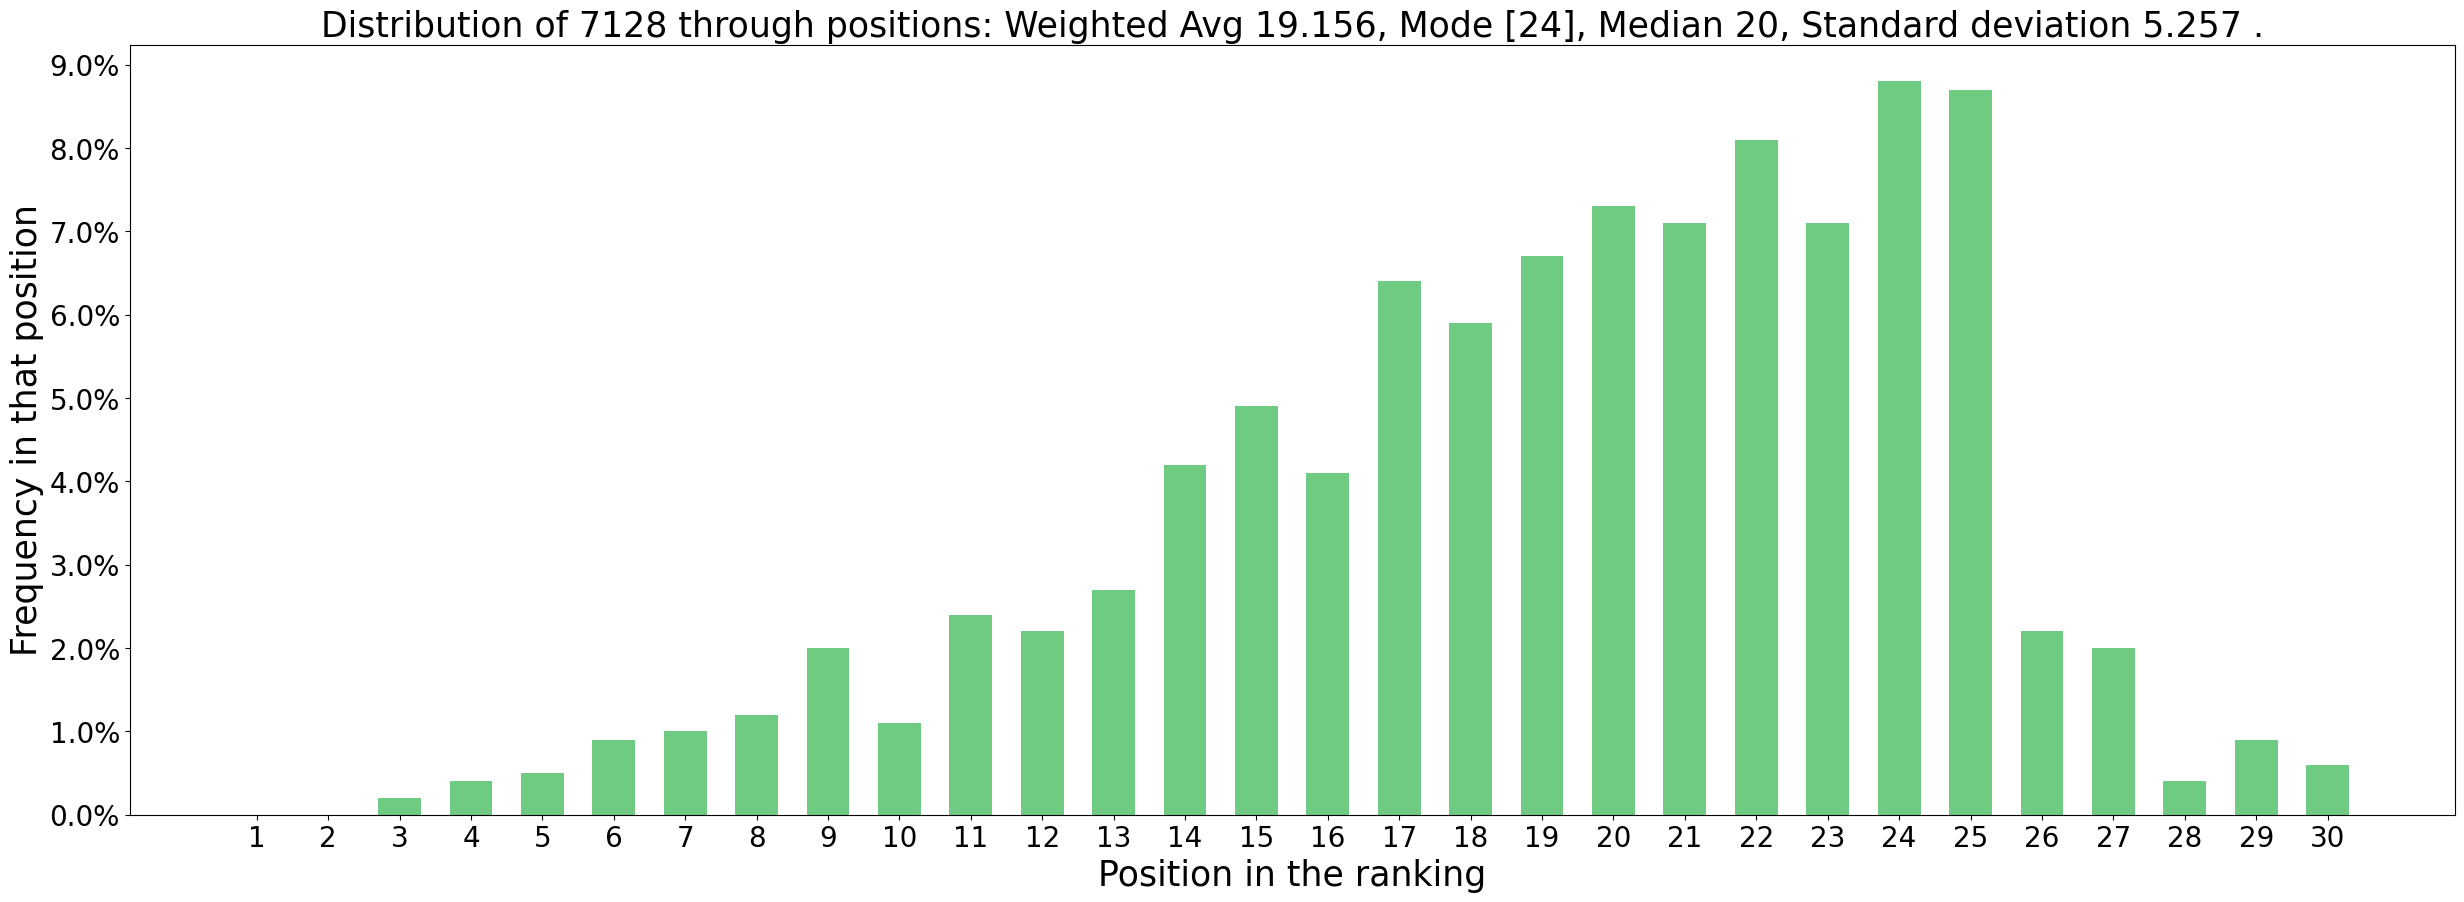

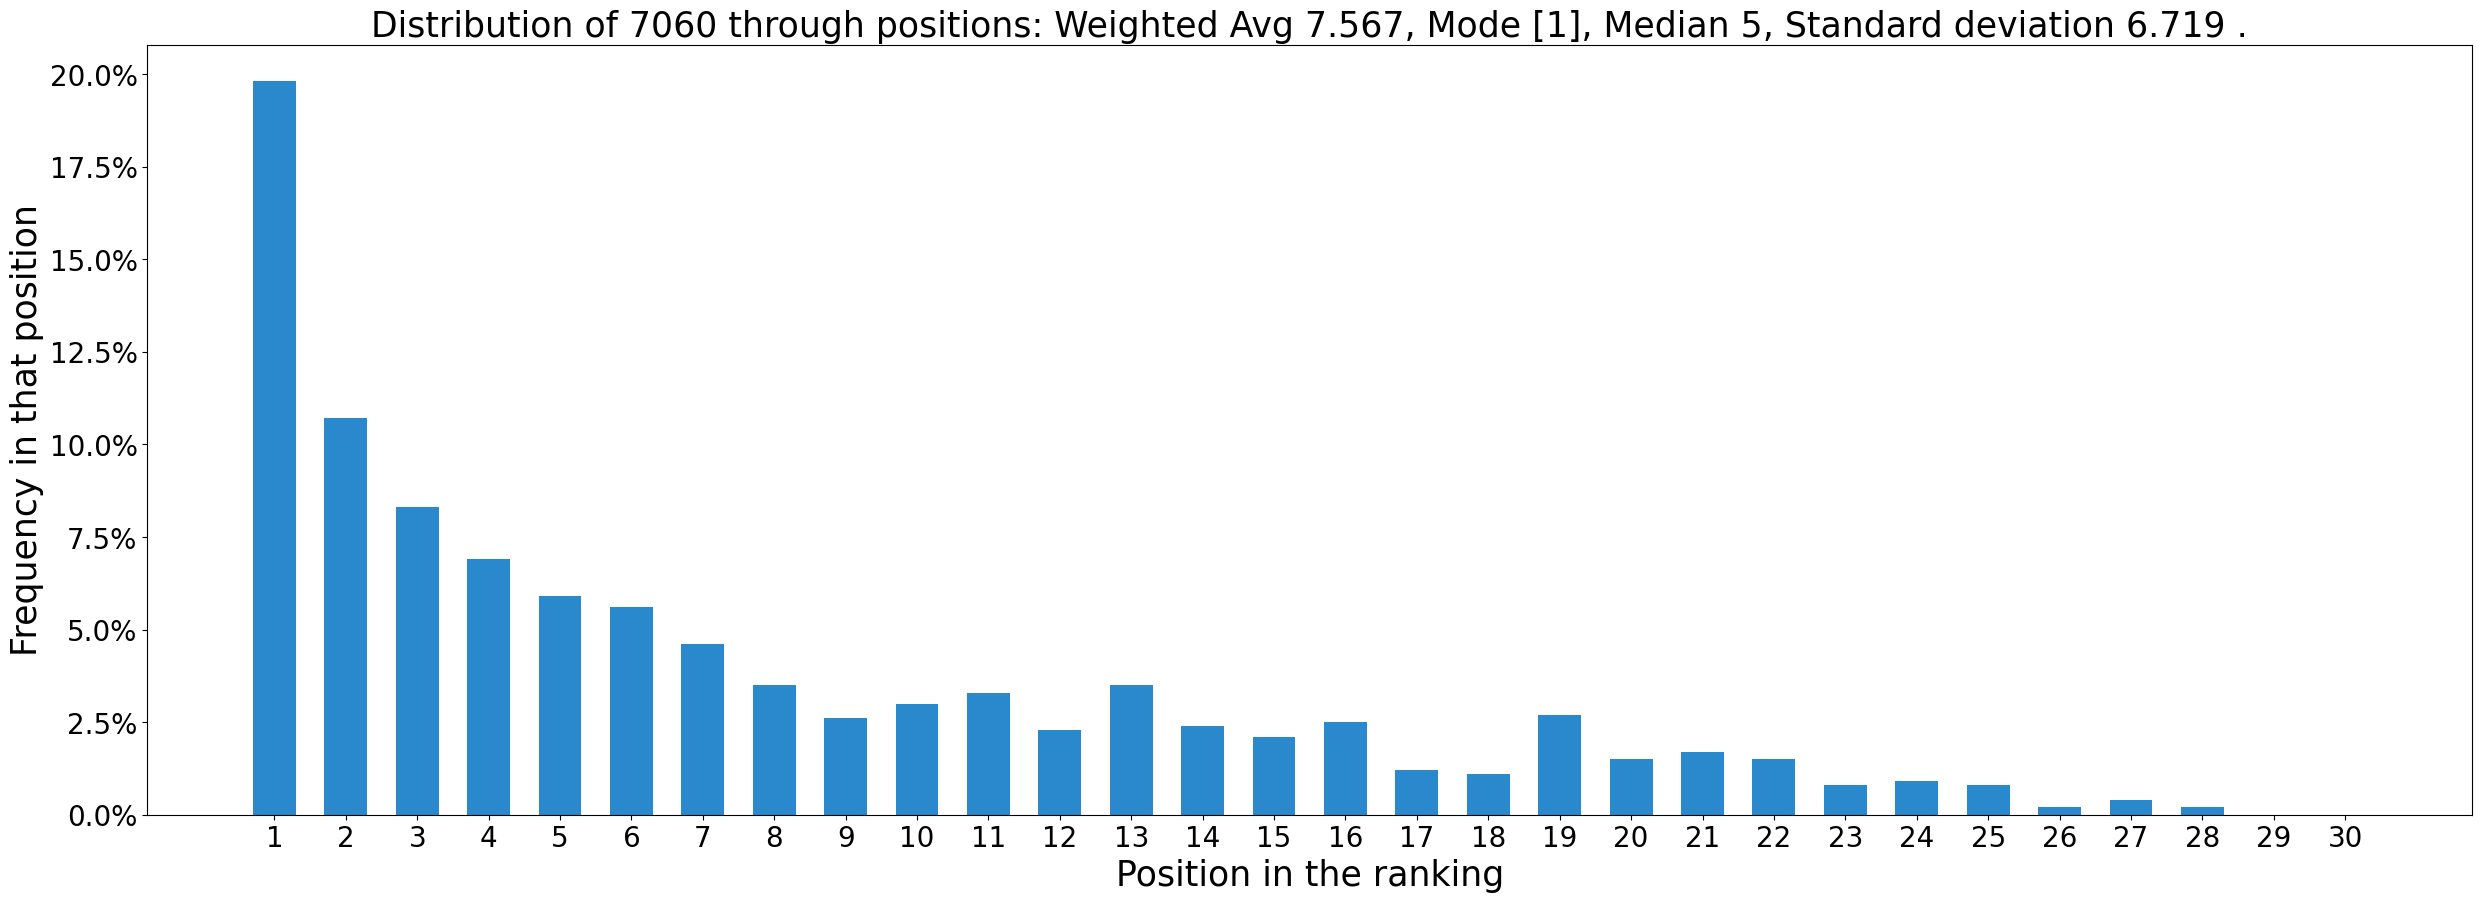

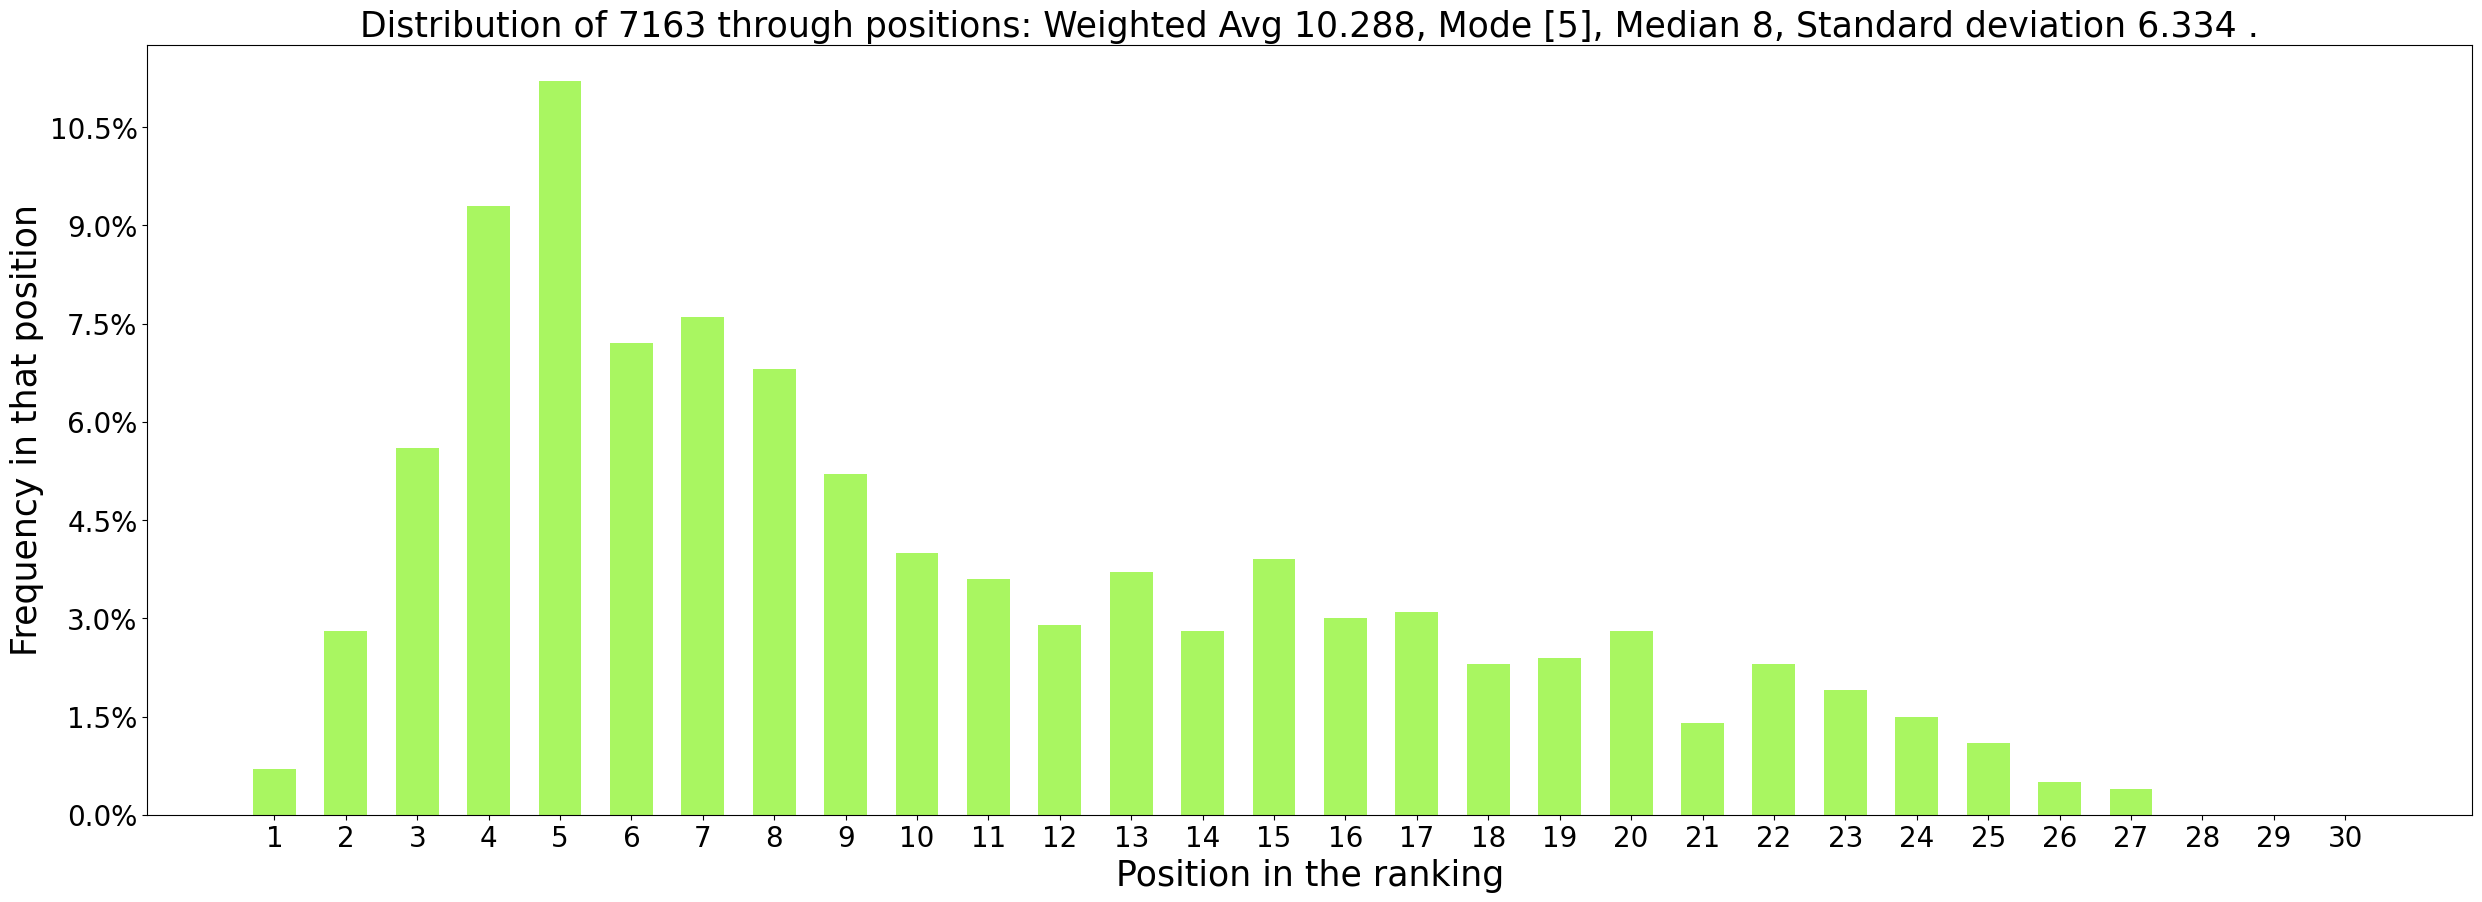

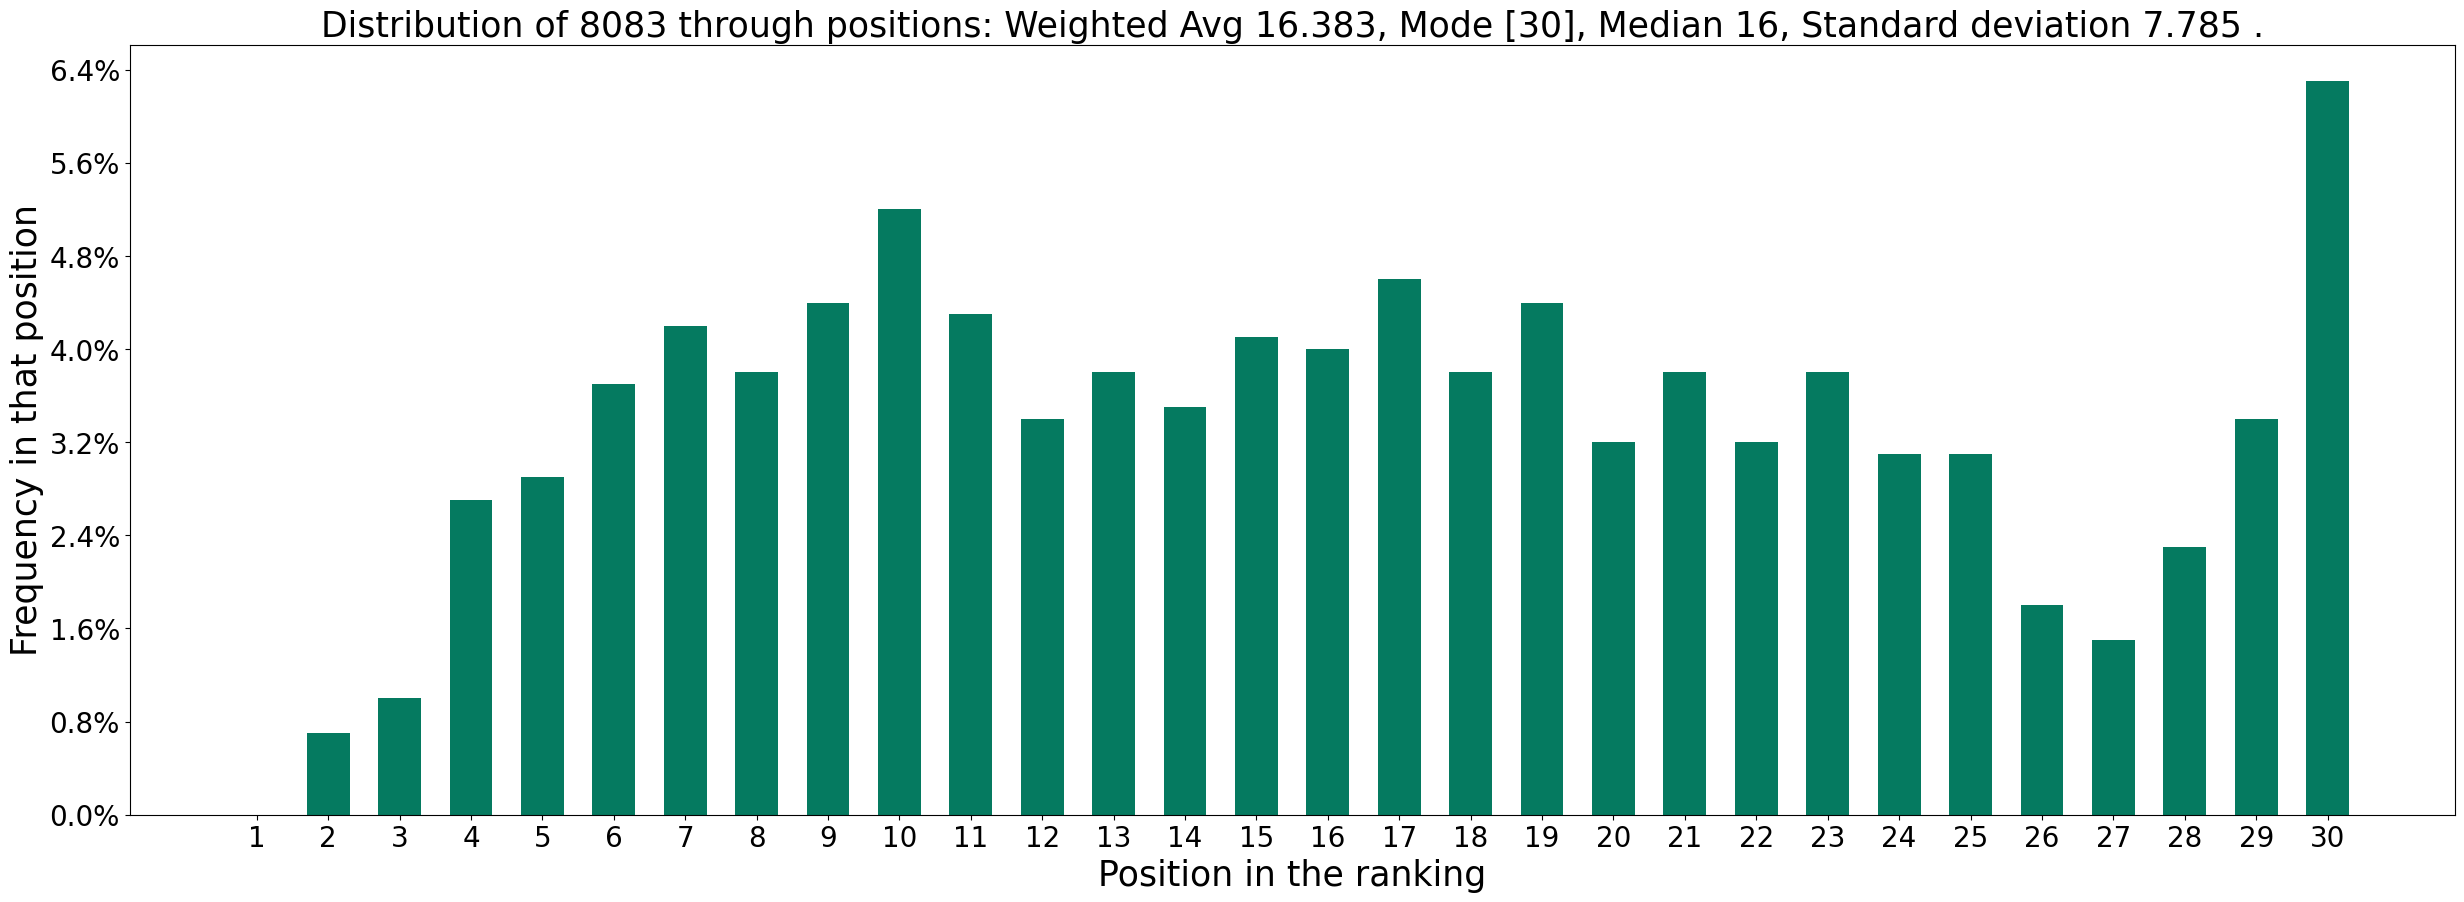

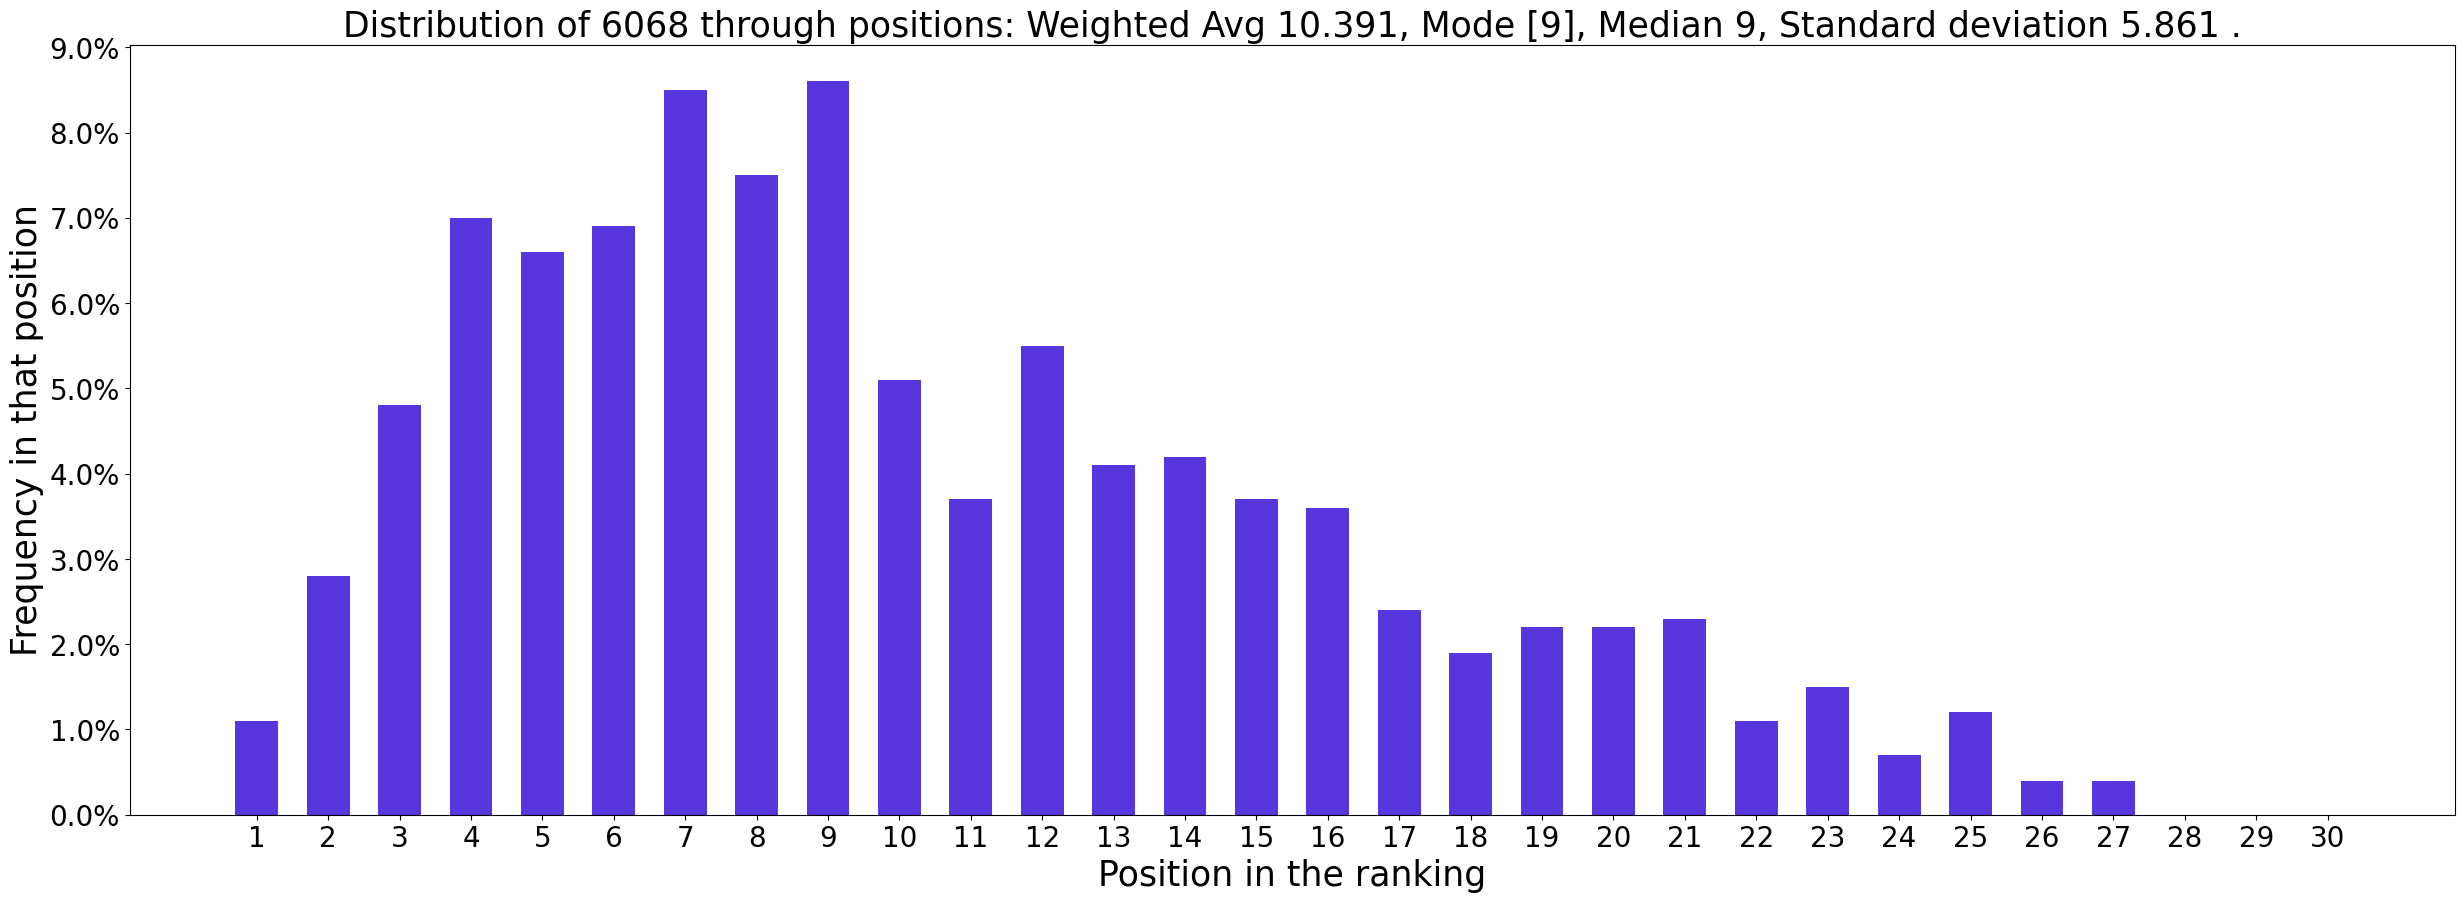

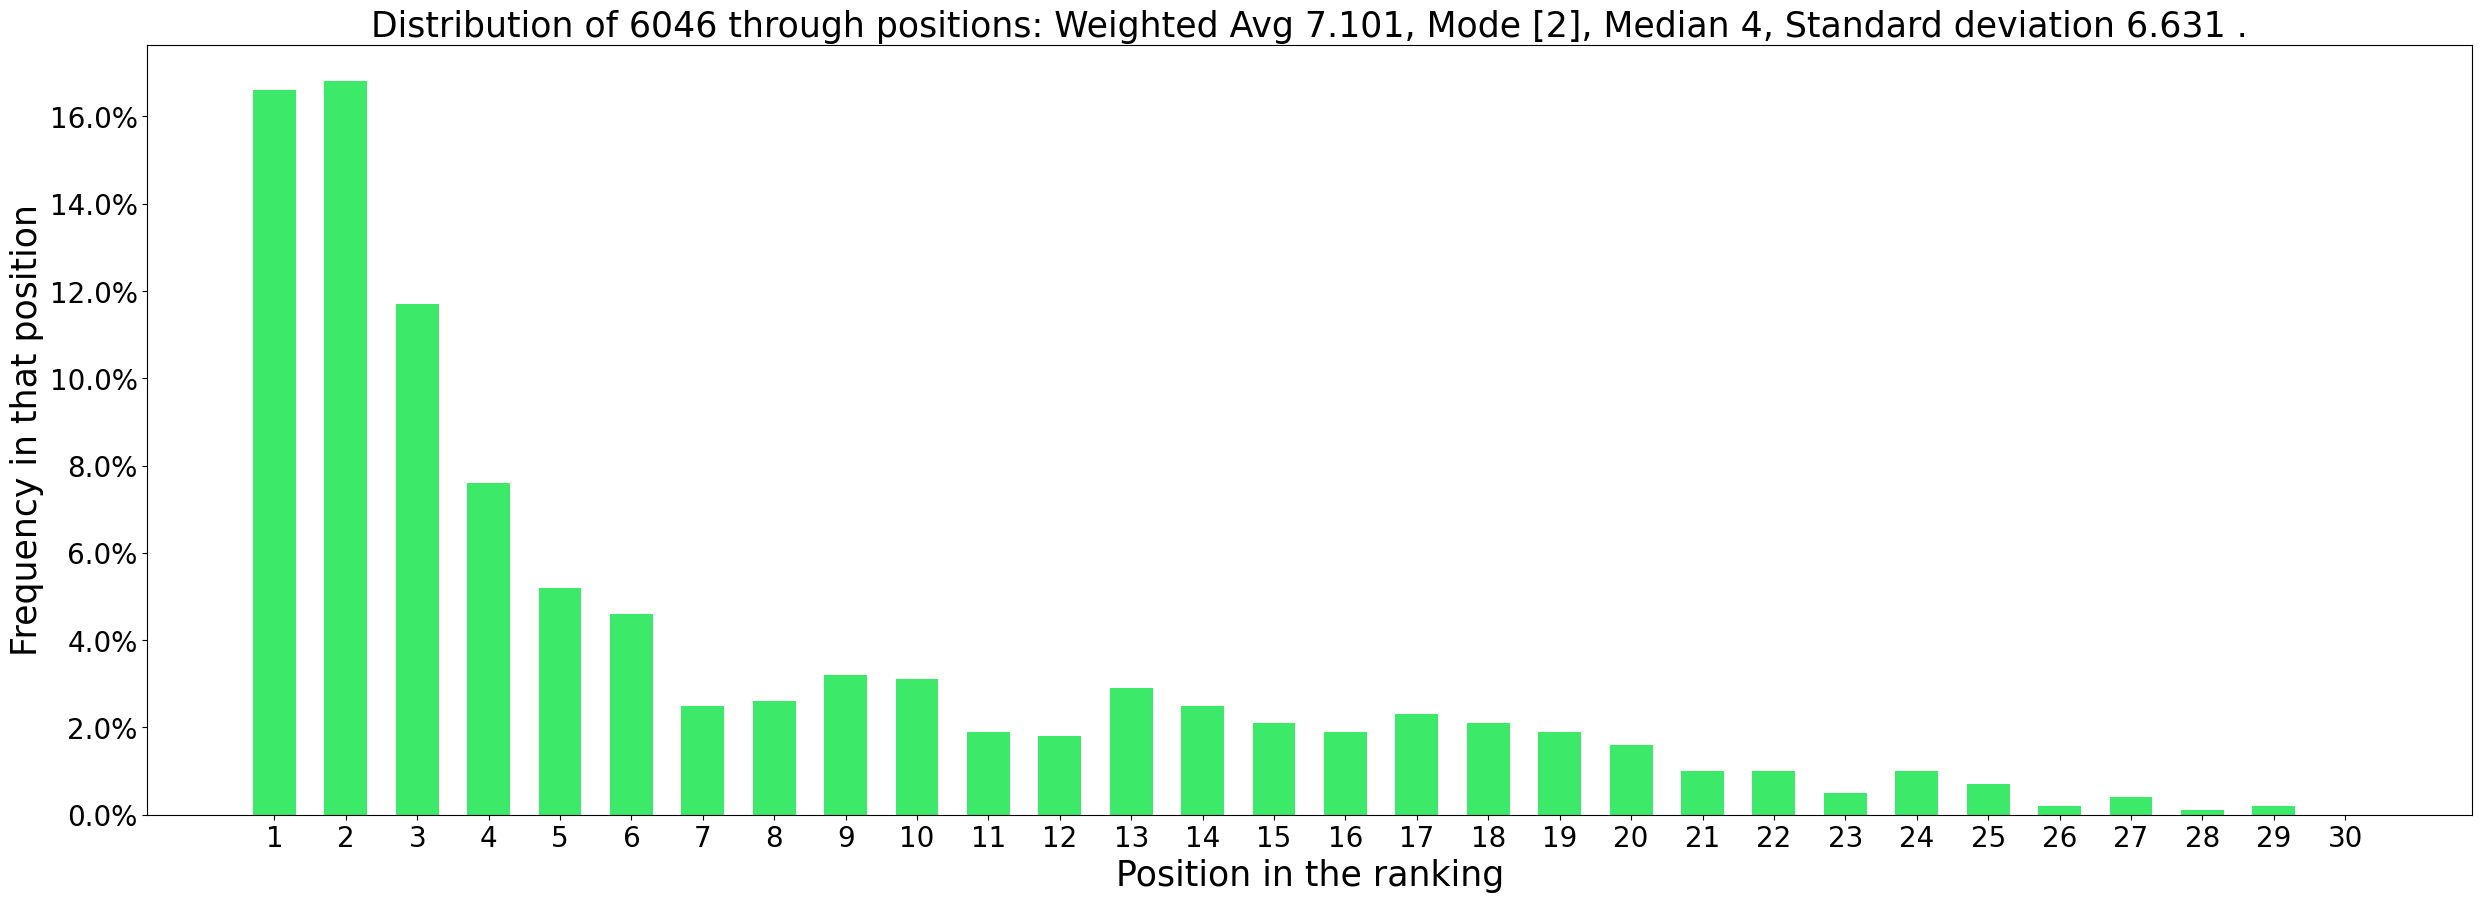

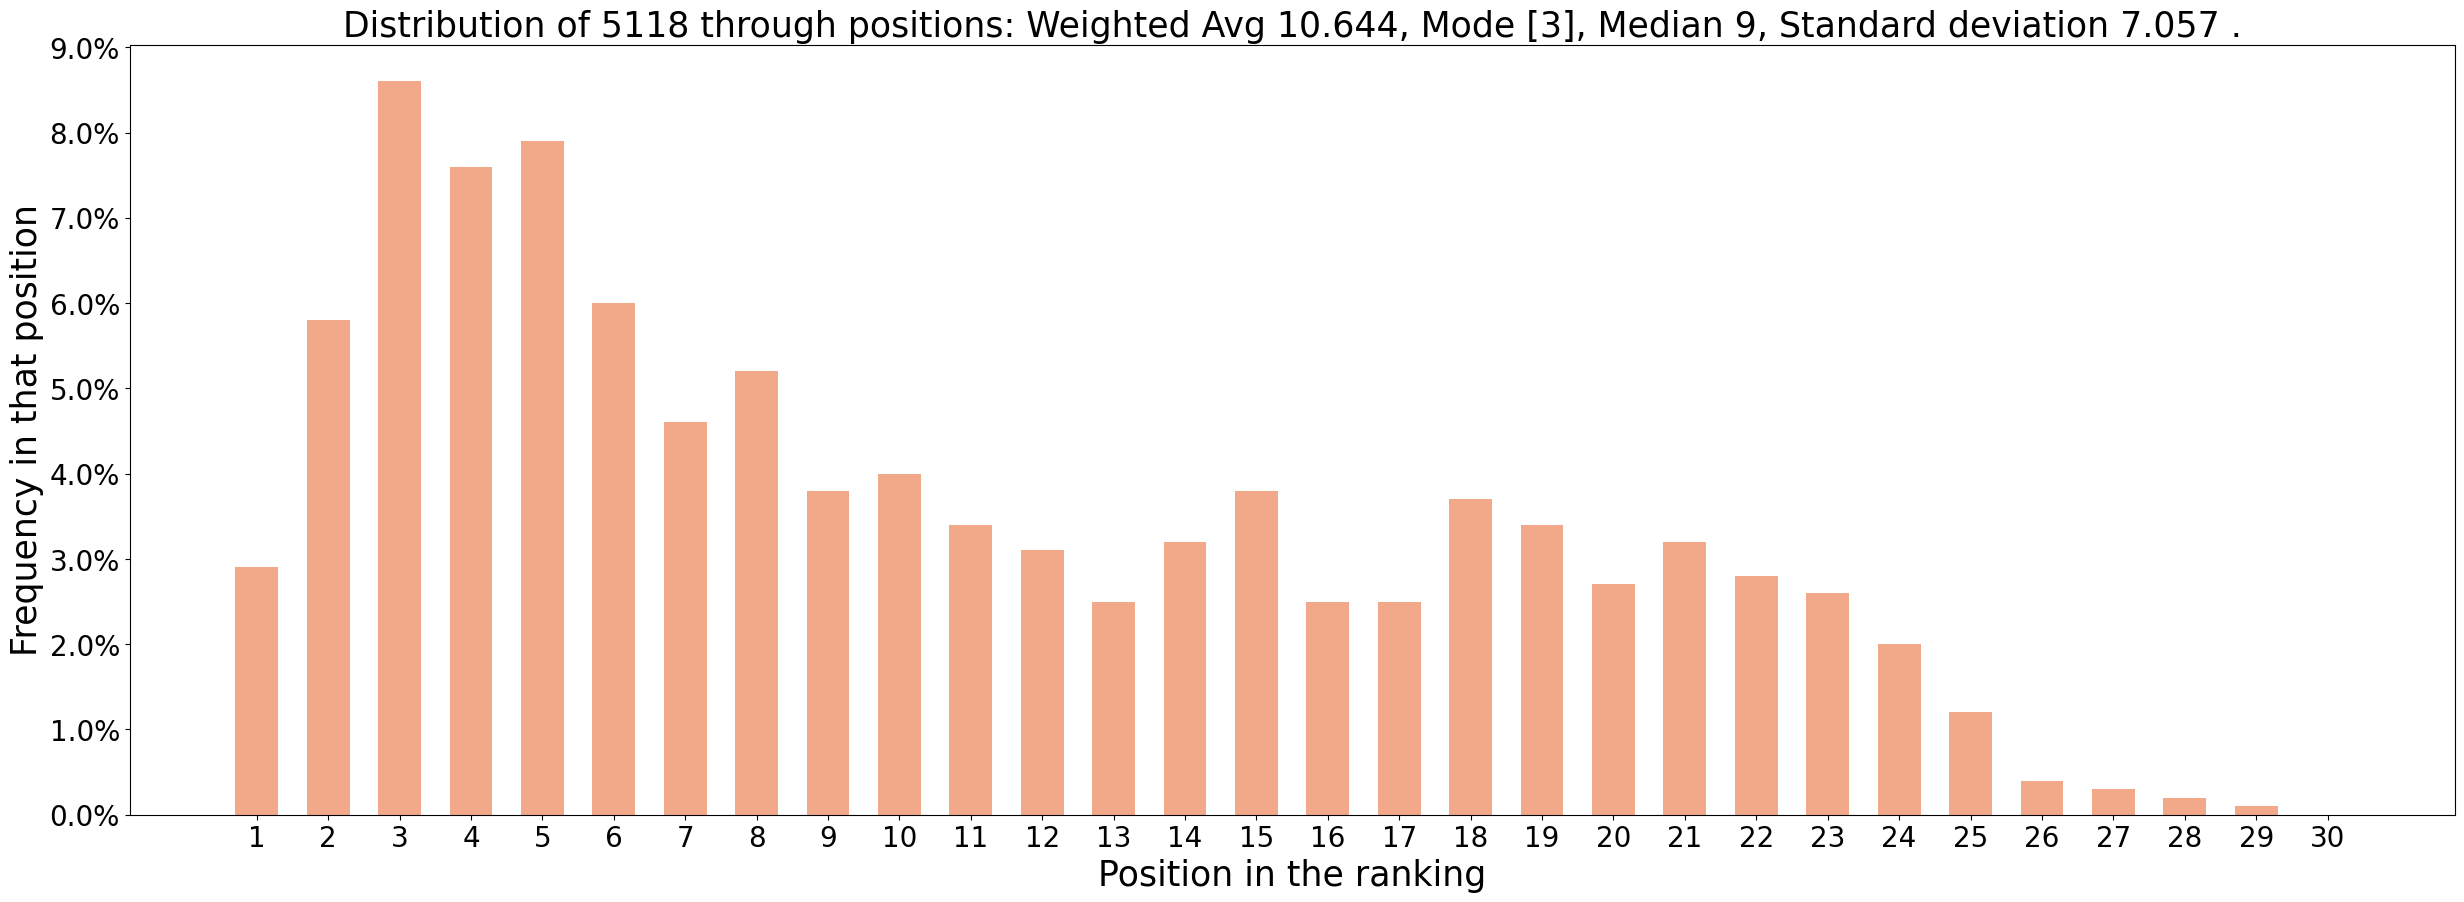

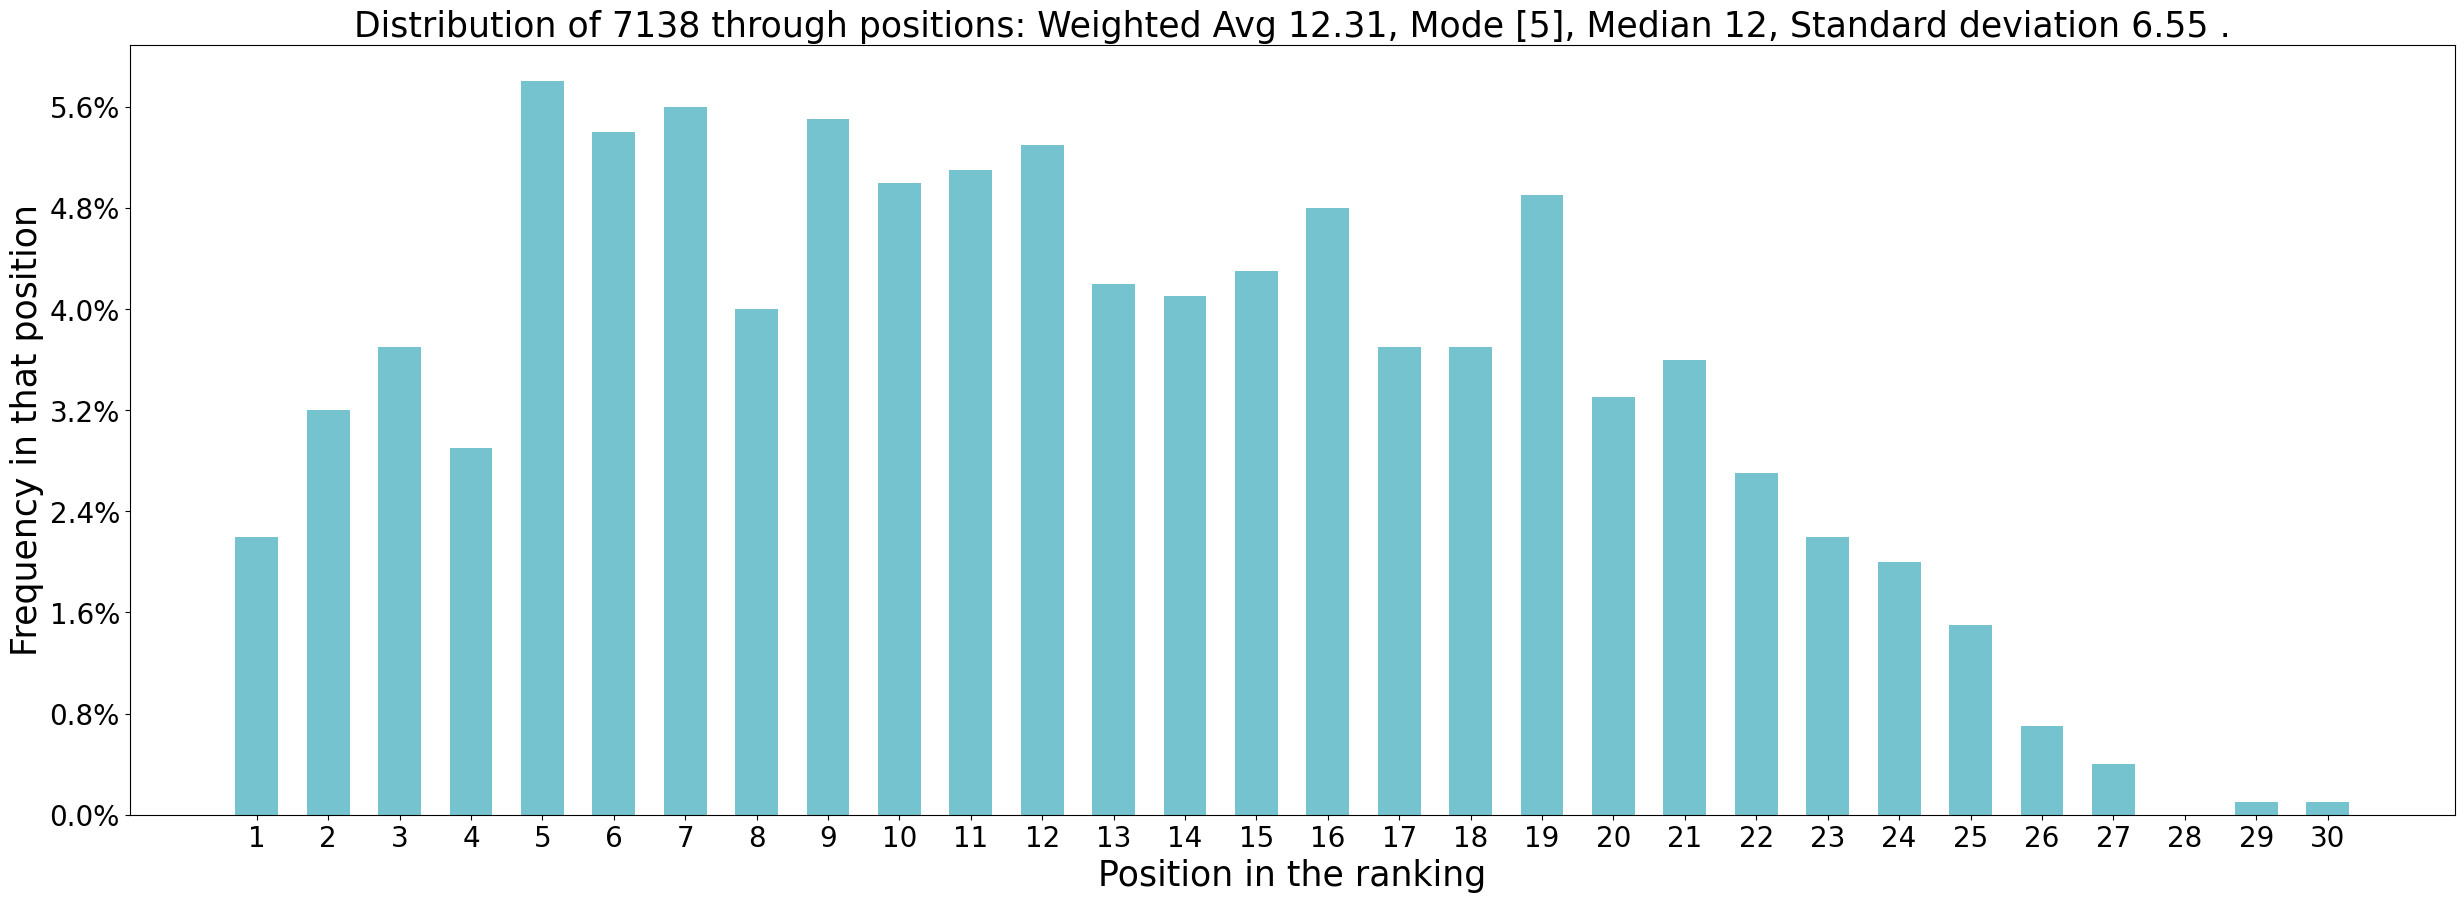

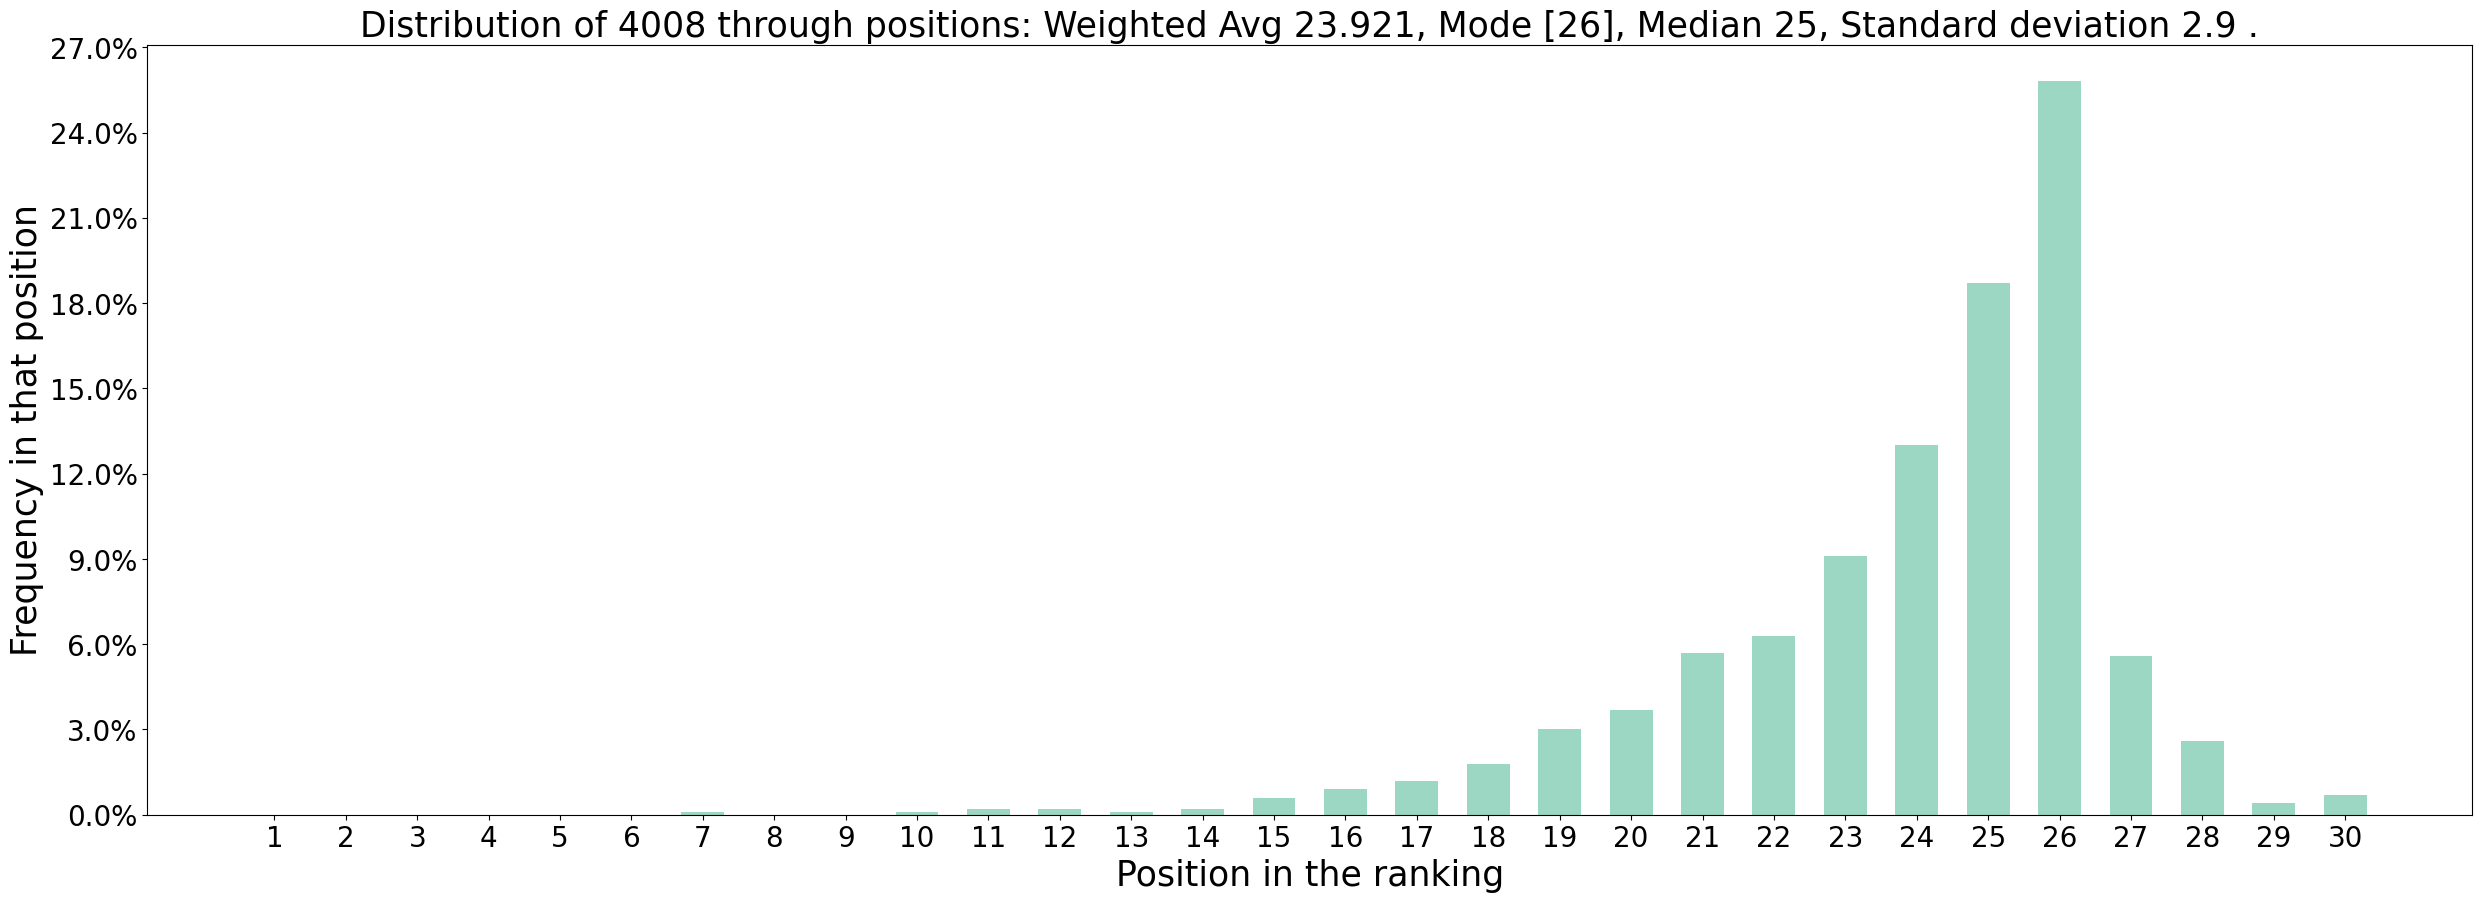

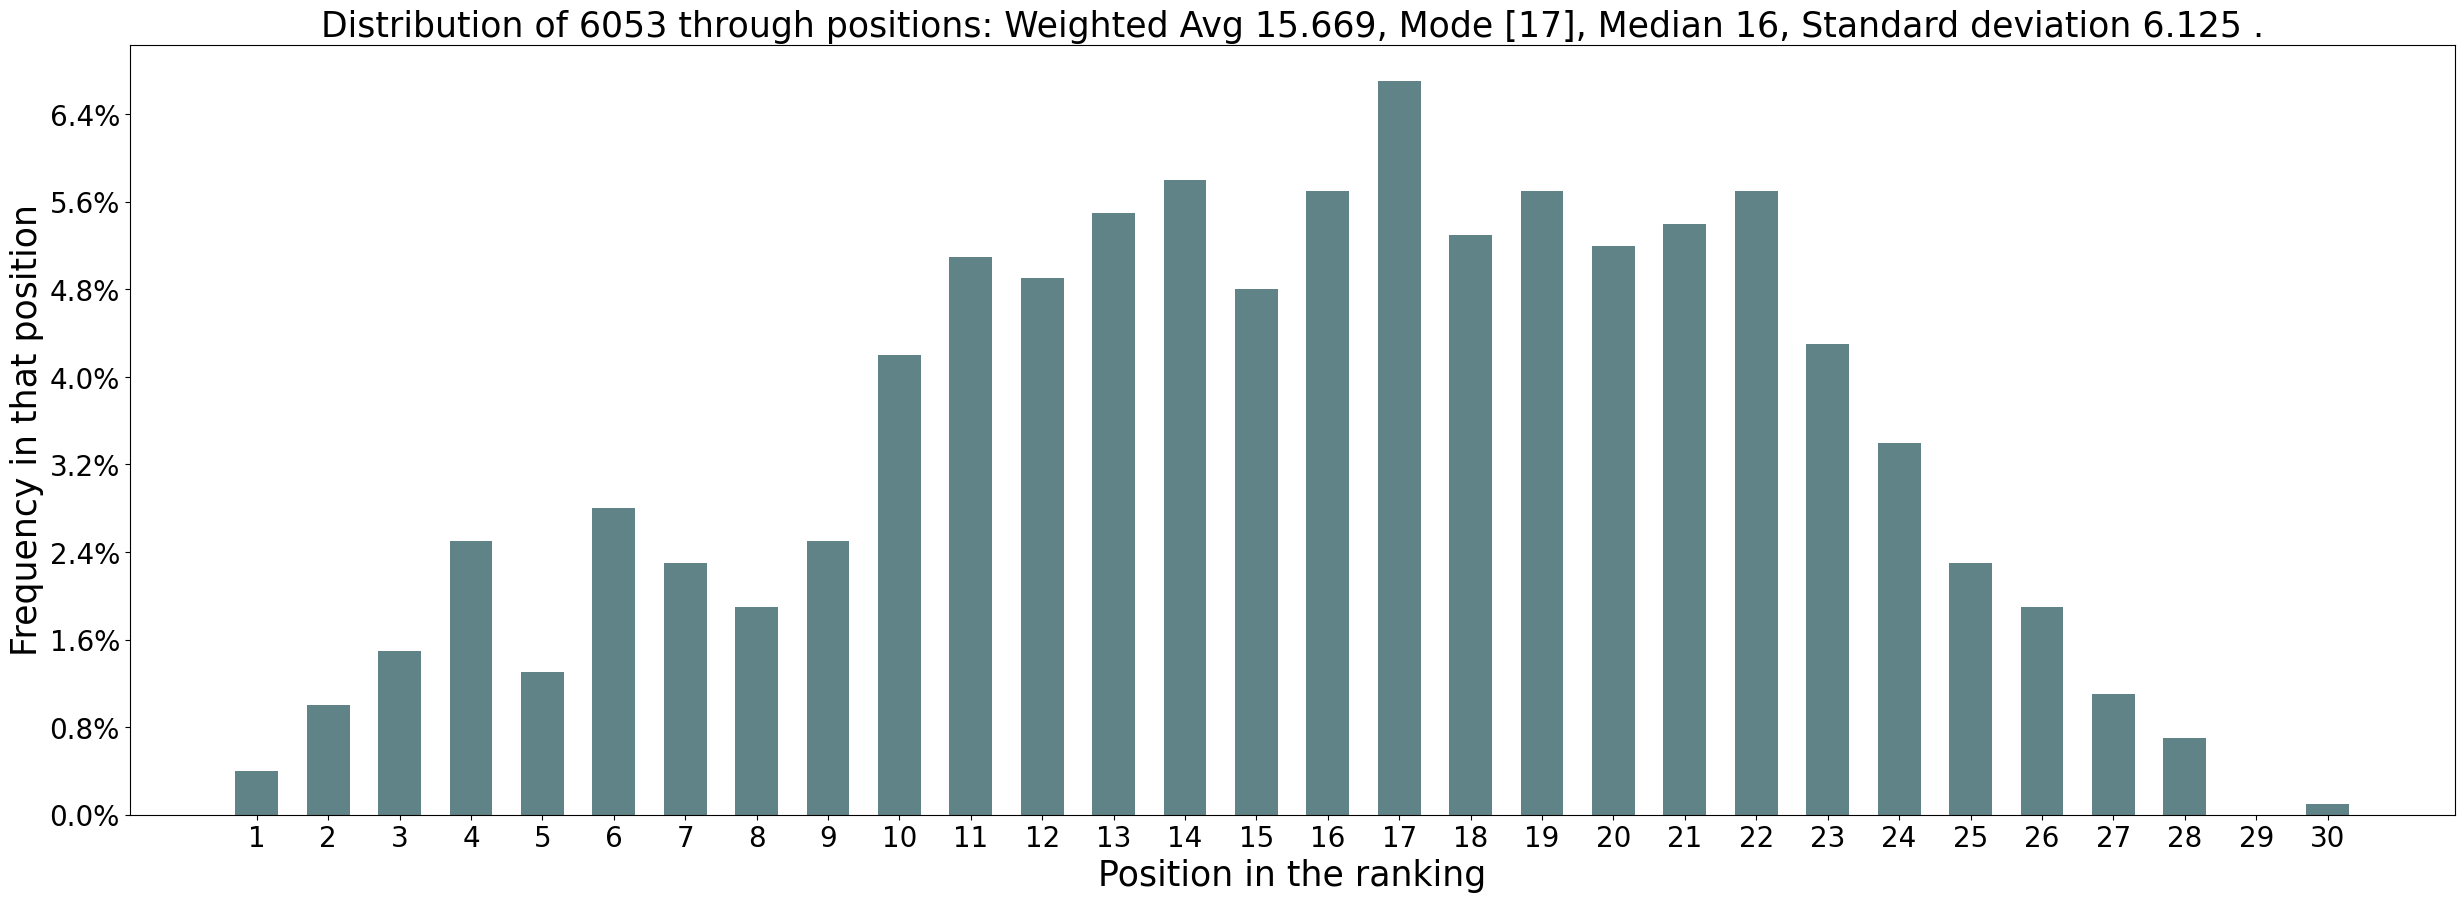

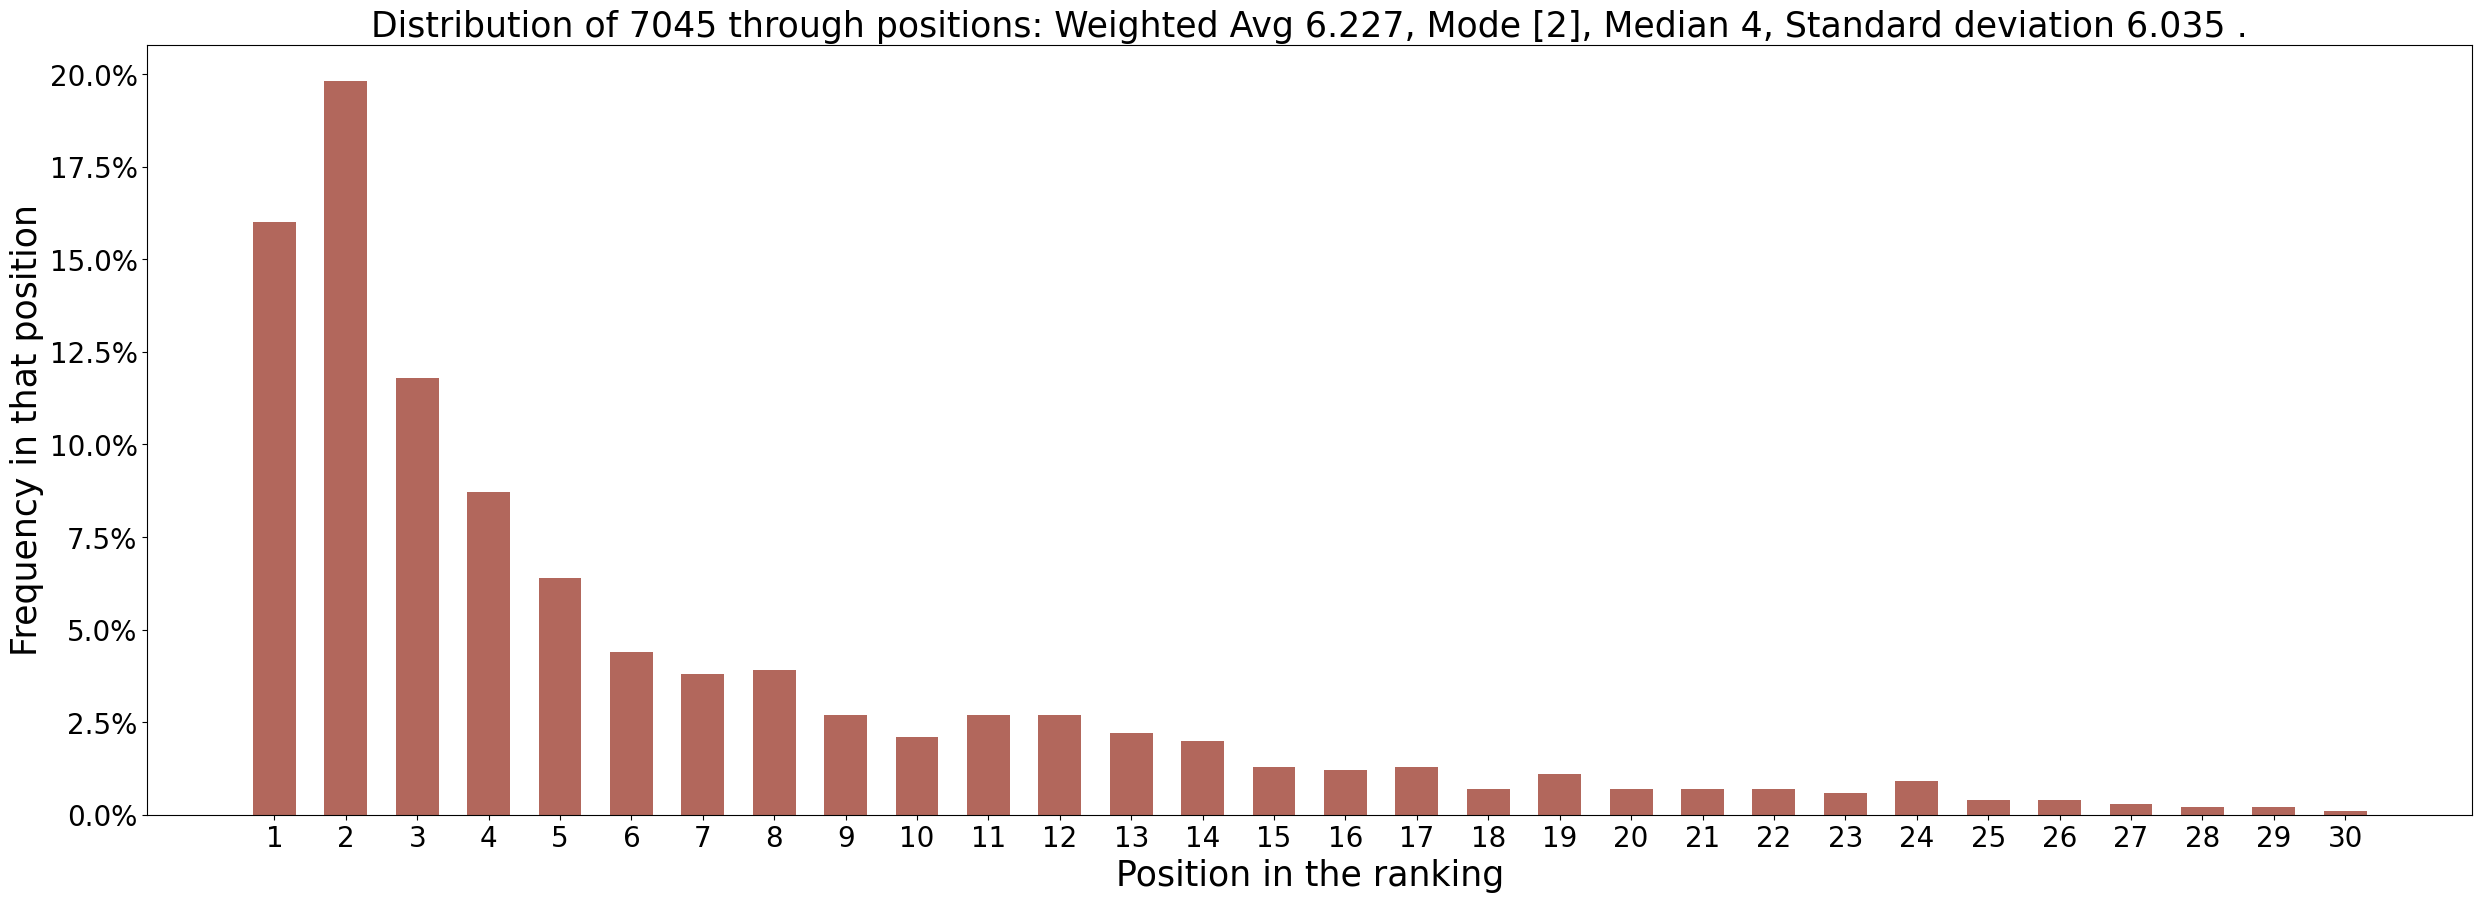

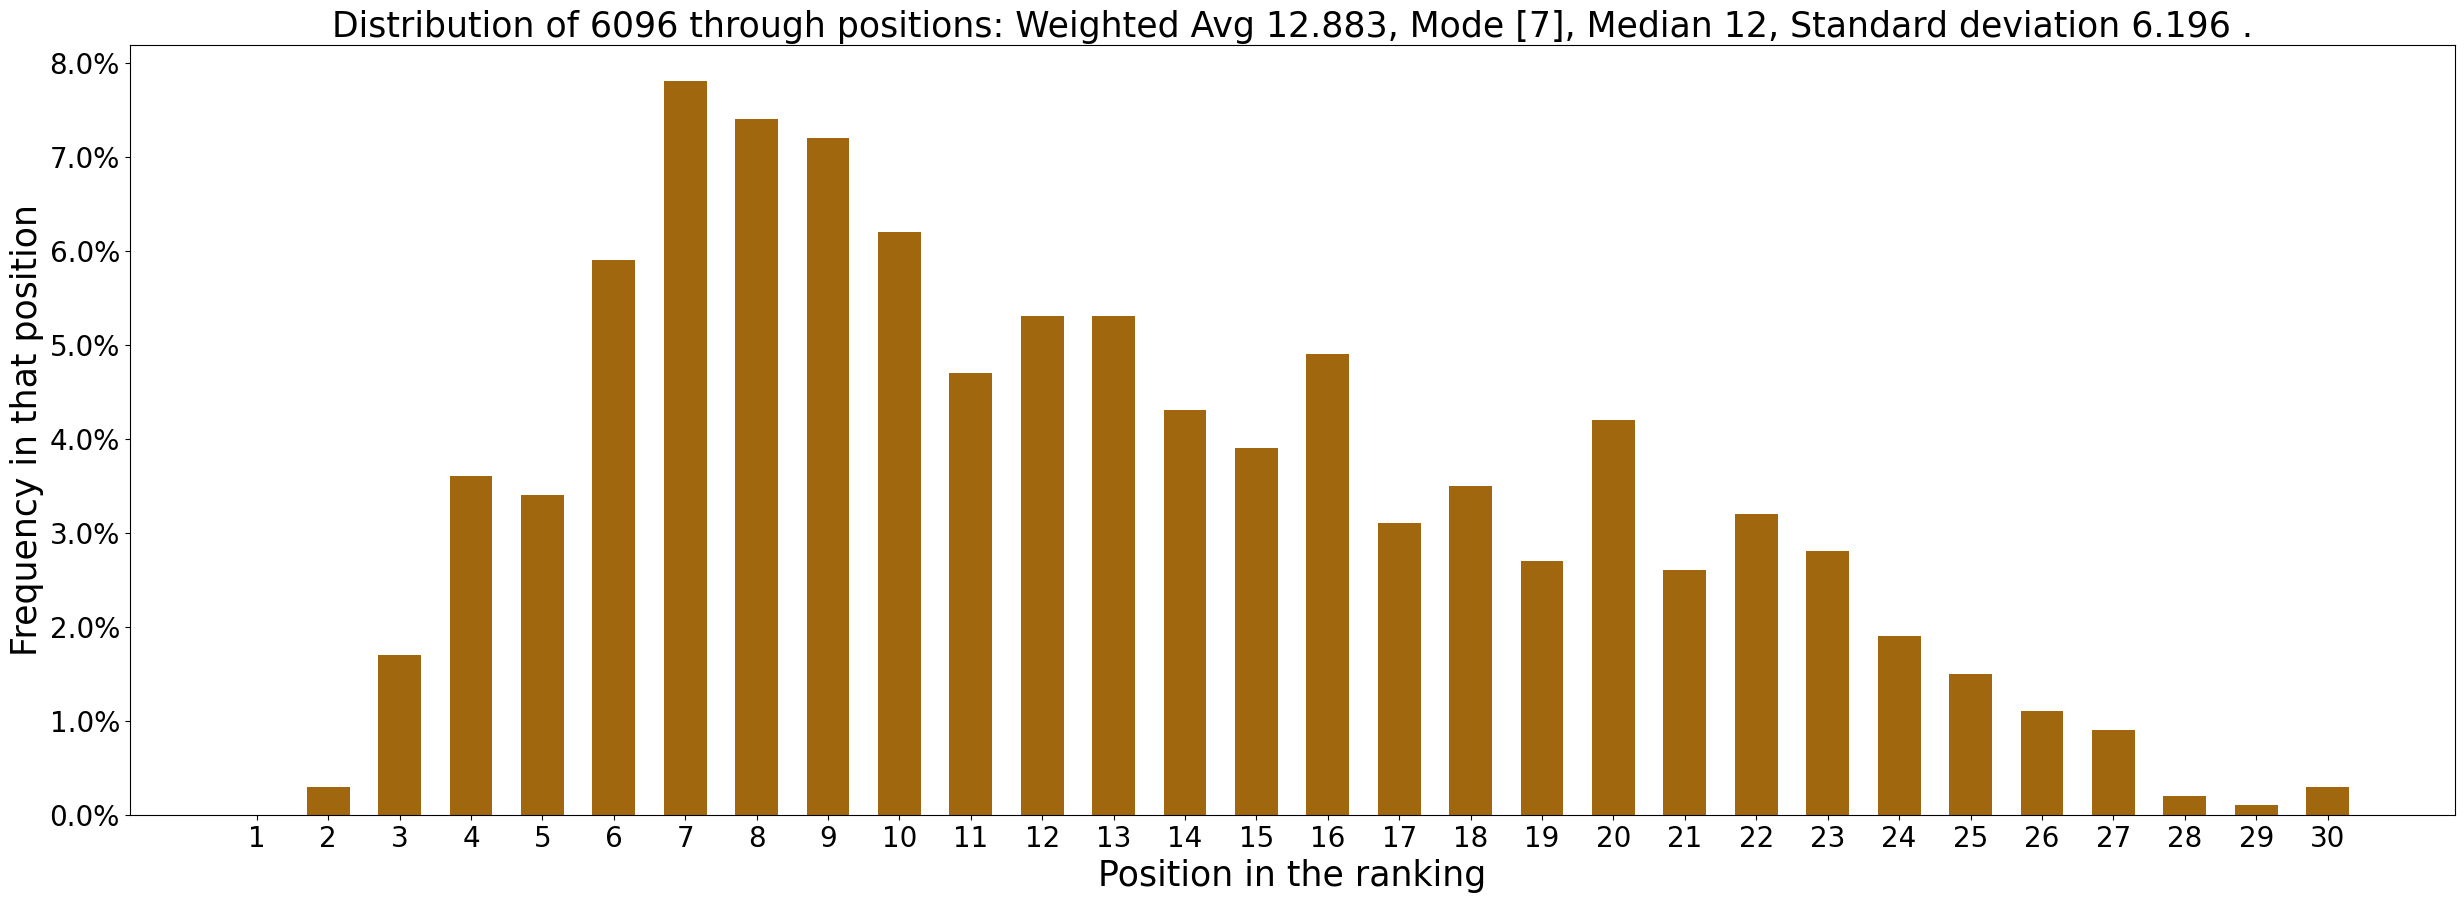

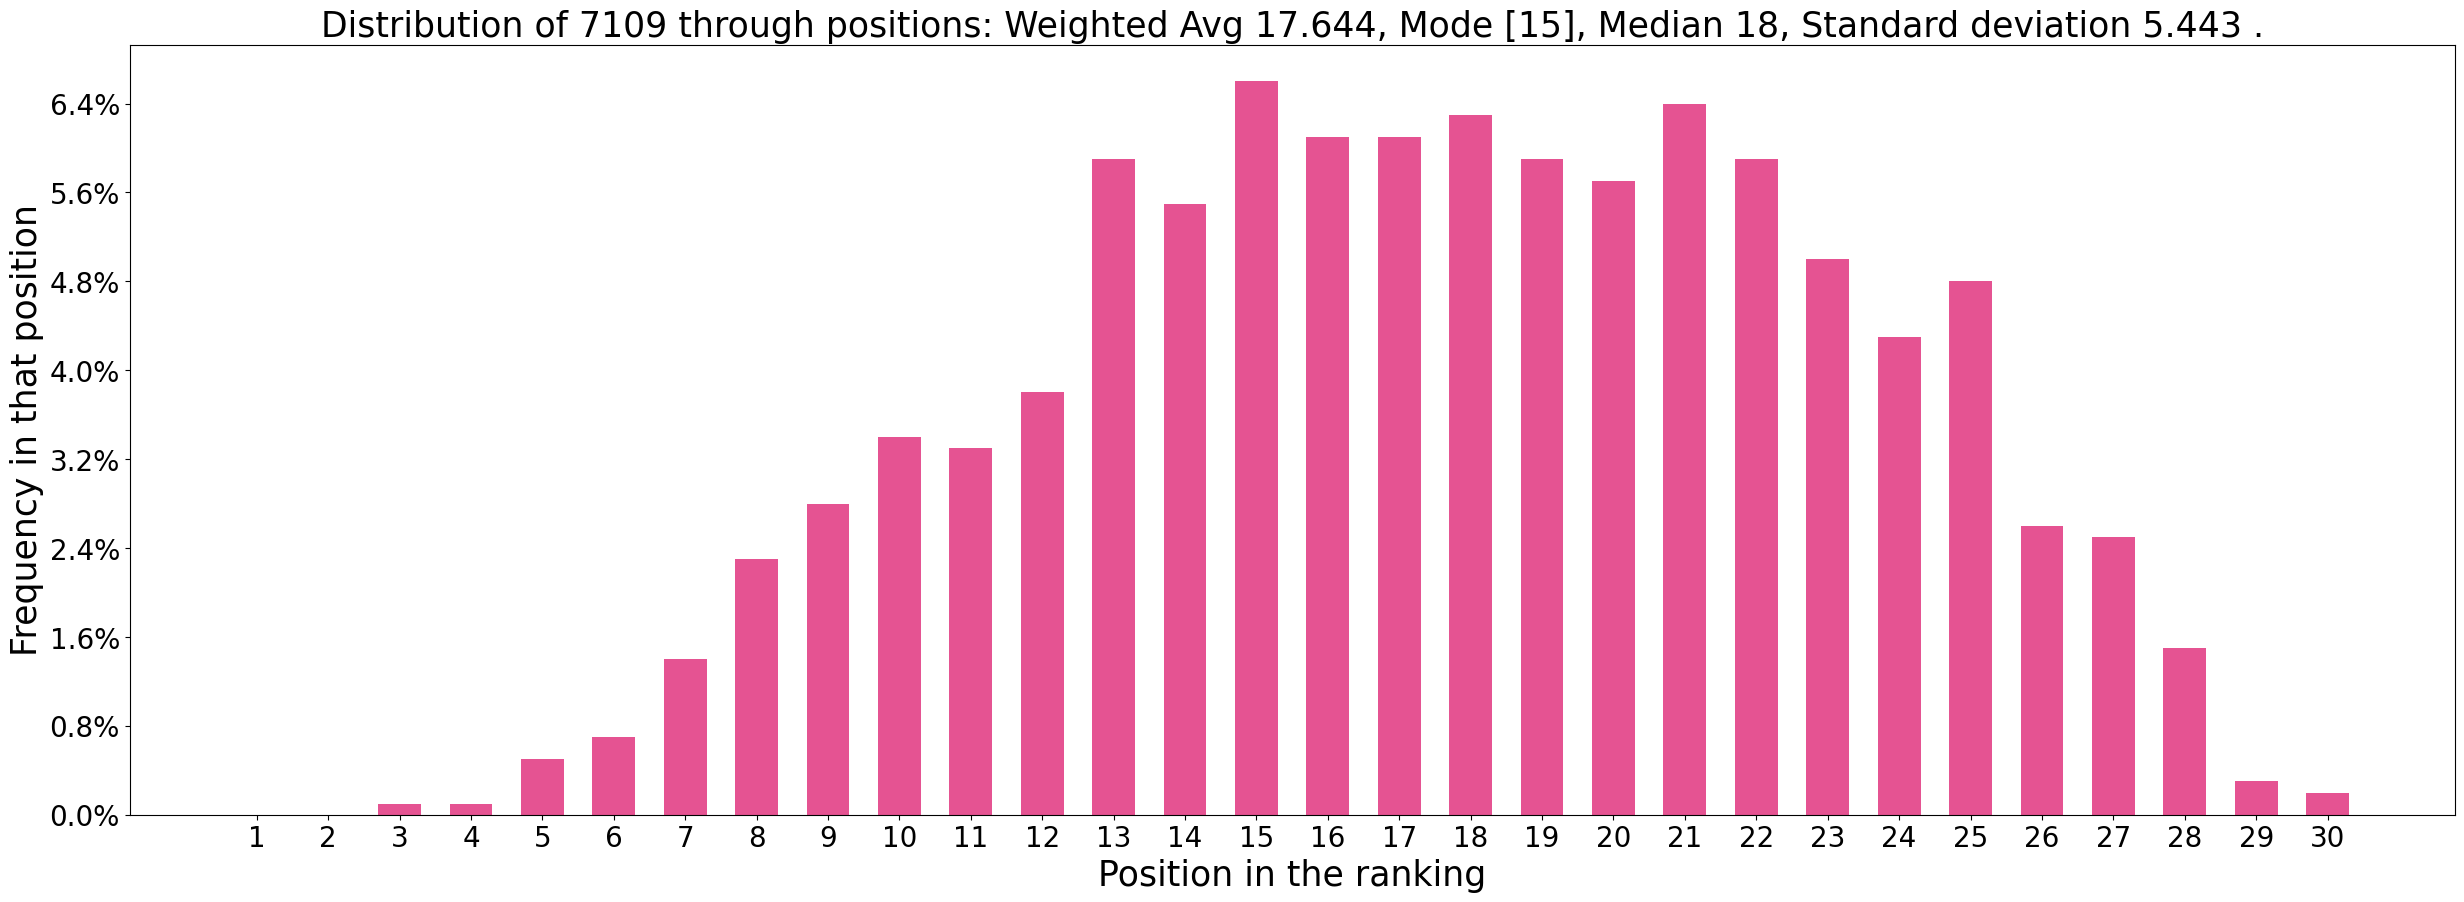

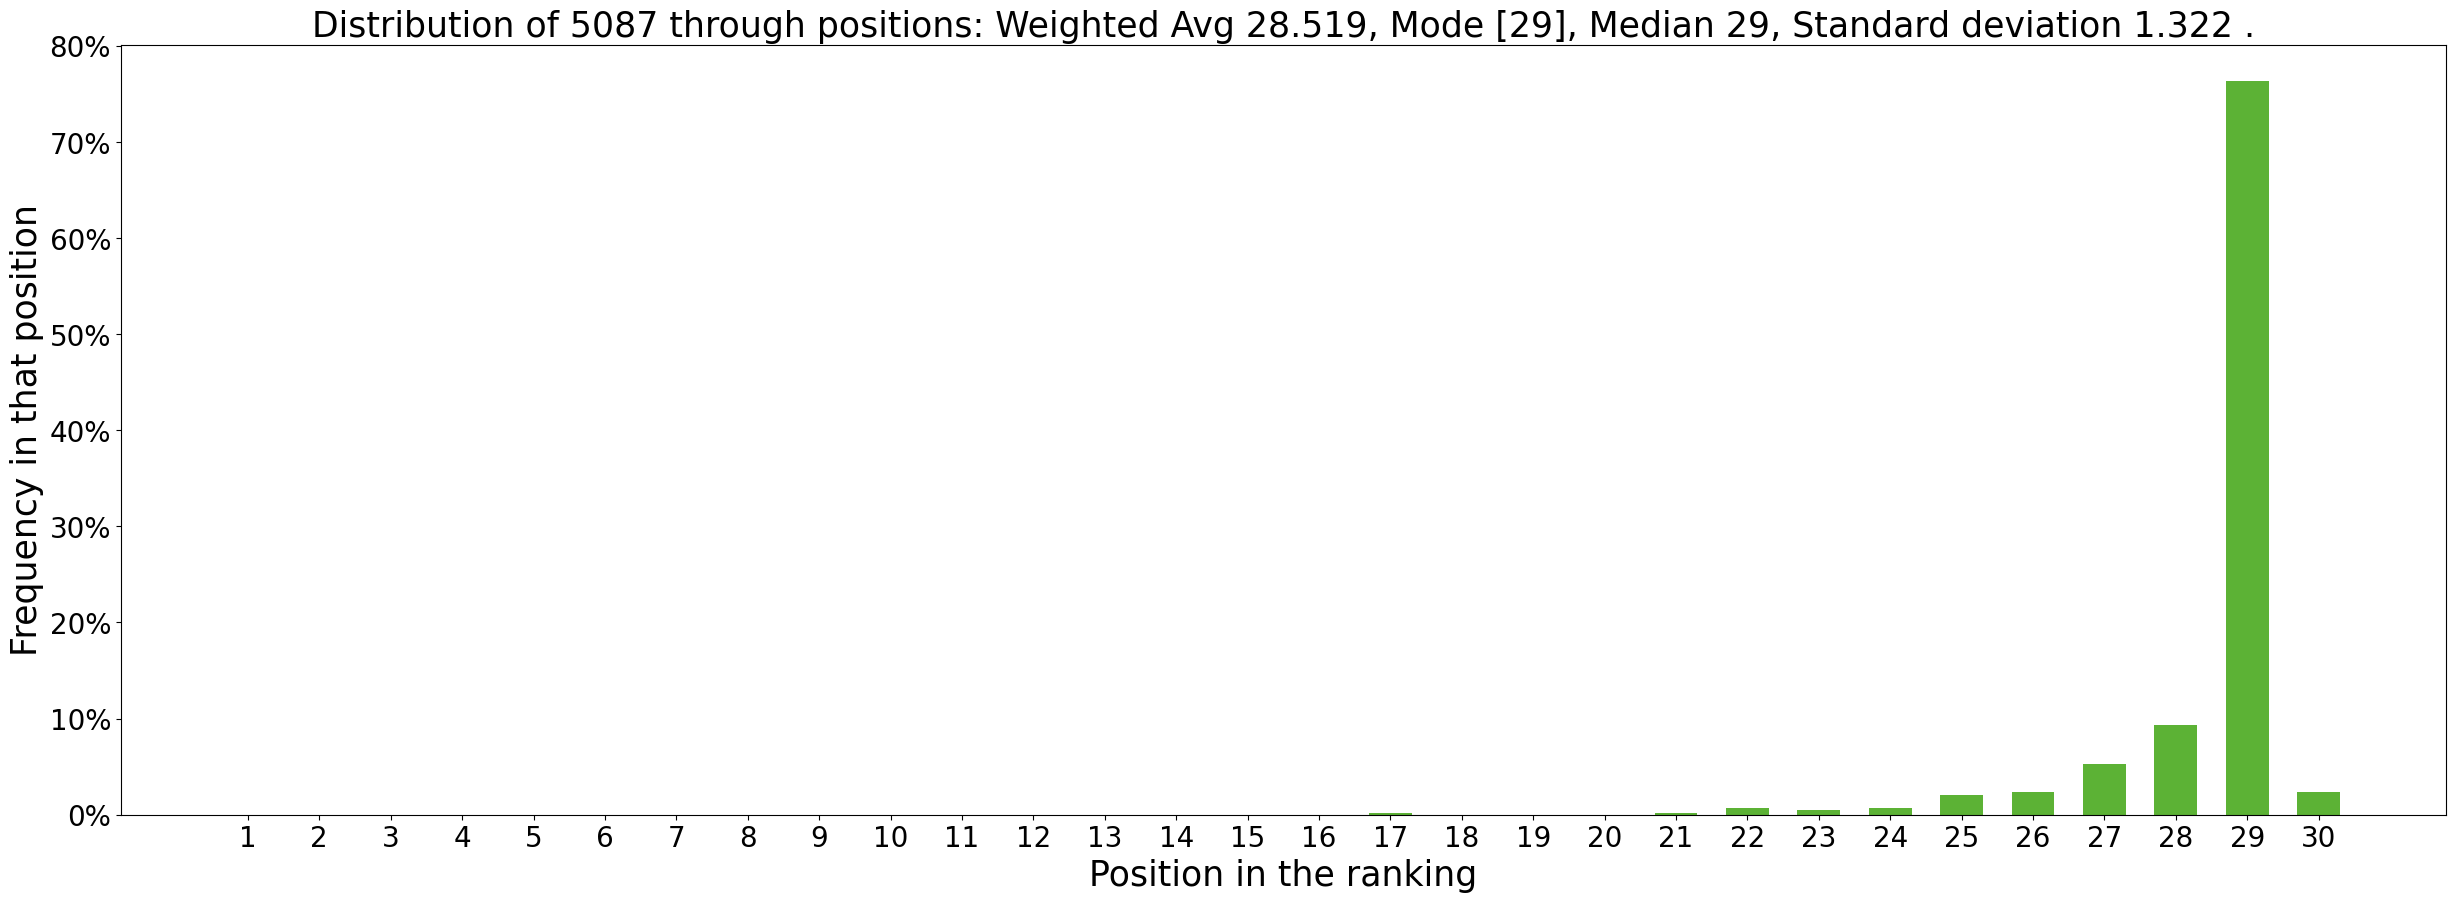

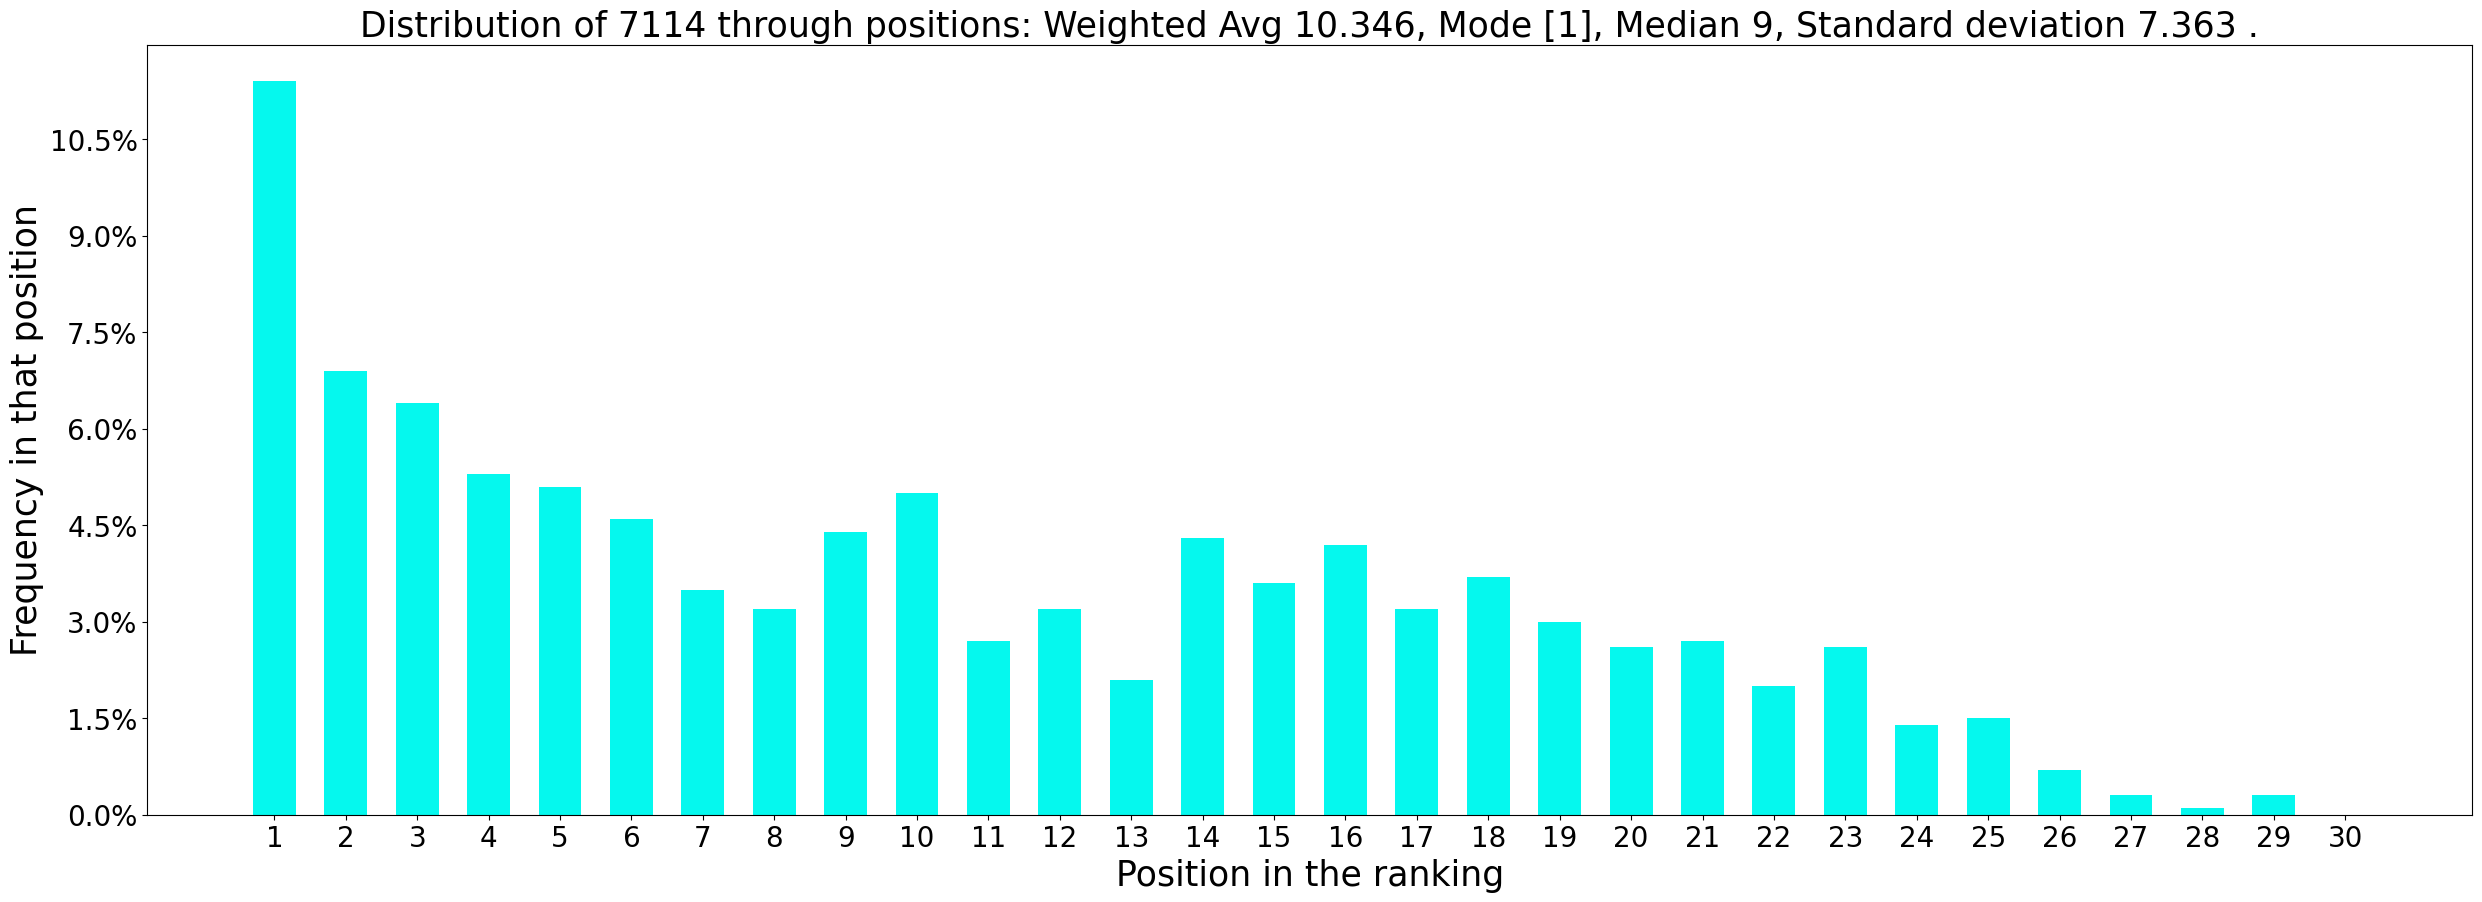

In [35]:
import os
import matplotlib.ticker as mtick
#Plotting results
output_directory = r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\rank_algorithm\Mergesort\Results'

x=list(range(1,num_cows+1))
avg=[]
median=[]
mode=[]
std_dev=[]
for i in range(num_cows):
    y=individual_counts[new_cow_order[i]]

    #Mean
    # Compute the weighted sum of positions
    weighted_sum = sum((i+1) * count for i, count in enumerate(y))
    # Compute the average position
    avg.append(weighted_sum / num_ranks)
    #Mode
    # Find the maximum occurrence count
    max_count = max(y)
    # Find all the positions with the maximum occurrence count
    mode.append([h+1 for h, count in enumerate(y) if count == max_count])
    #Median
    # Compute the cumulative counts
    cumulative_counts = [sum(y[:i+1]) for i in range(len(y))]
    # Find the position at which the cumulative count exceeds or reaches half of the total count
    median.append(next(i+1 for i, count in enumerate(cumulative_counts) if count>= num_ranks / 2))

    # Calculate the standard deviation
    differences = sum(y[j] * ((j + 1) - avg[i]) ** 2 for j in range(len(y)))
    std_deviation = math.sqrt(differences / (num_ranks))

    #Calculate the standard deviation
    std_dev.append(round(std_deviation, 3))

    plt.figure(figsize=(30, 10))
    color = (random.random(), random.random(), random.random())
    y_prob = [i / num_ranks for i in y]
    plt.bar(x, y_prob, color=color, width=0.6)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    # Limit the number of tick points on the y-axis

    plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=10))
    plt.xlabel('Position in the ranking', fontsize=25)
    plt.ylabel('Frequency in that position', fontsize=25)
    plt.title(f'Distribution of {new_cow_order[i]} through positions: Weighted Avg {avg[i]}, Mode {mode[i]}, Median {median[i]}, Standard deviation {std_dev[i]} .', fontsize=25)
    plt.xticks(x, fontsize=20)
    plt.yticks(fontsize=20)
    # Generate the complete file path
    filepath = os.path.join(output_directory, f'{new_cow_order[i]}.png')
    # Save the figure with dynamic filename and specified directory
    plt.savefig(filepath)
    plt.show()



In [36]:
# Combine the indicators into a single numpy array for clustering
indicators = np.column_stack((avg, median, std_dev))

# Number of clusters (you can adjust this based on your preference)
num_clusters = 4

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(indicators)

# Print the clustering results
for cow_index, cluster in enumerate(clusters):
    cow_id = new_cow_order[cow_index]
    print(f"Cow {cow_id} belongs to cluster {cluster + 1}")

C:\Users\varin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\varin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cow 4026 belongs to cluster 2
Cow 5064 belongs to cluster 2
Cow 4035 belongs to cluster 1
Cow 6095 belongs to cluster 2
Cow 6094 belongs to cluster 2
Cow 7064 belongs to cluster 3
Cow 6029 belongs to cluster 4
Cow 6062 belongs to cluster 3
Cow 7136 belongs to cluster 3
Cow 7116 belongs to cluster 1
Cow 7153 belongs to cluster 3
Cow 6025 belongs to cluster 2
Cow 6088 belongs to cluster 1
Cow 6092 belongs to cluster 4
Cow 6086 belongs to cluster 3
Cow 7128 belongs to cluster 2
Cow 7060 belongs to cluster 4
Cow 7163 belongs to cluster 4
Cow 8083 belongs to cluster 2
Cow 6068 belongs to cluster 4
Cow 6046 belongs to cluster 4
Cow 5118 belongs to cluster 4
Cow 7138 belongs to cluster 3
Cow 4008 belongs to cluster 1
Cow 6053 belongs to cluster 2
Cow 7045 belongs to cluster 4
Cow 6096 belongs to cluster 3
Cow 7109 belongs to cluster 2
Cow 5087 belongs to cluster 1
Cow 7114 belongs to cluster 4


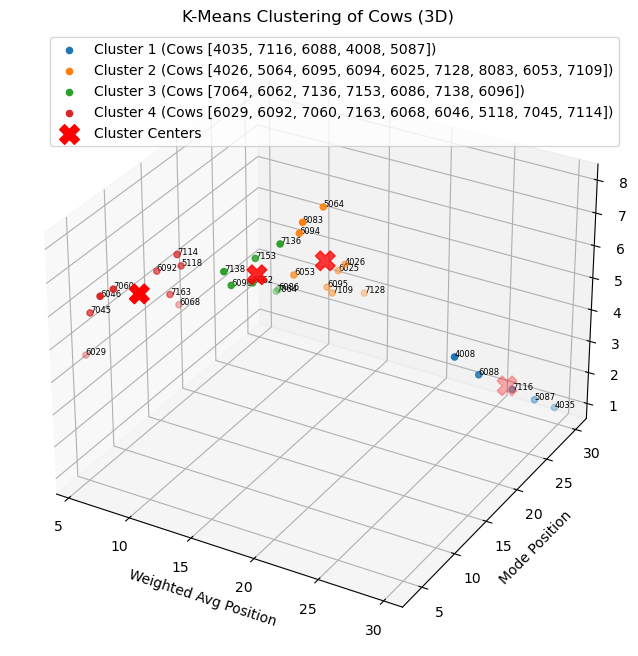

In [39]:
# 3D Plot the k-means result clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Separate data points based on their cluster assignments
for cluster_id in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_id)
    cluster_cow_ids = [new_cow_order[i] for i in cluster_indices[0]]
    ax.scatter(indicators[cluster_indices, 0], indicators[cluster_indices, 1], indicators[cluster_indices, 2], label=f'Cluster {cluster_id + 1} (Cows {cluster_cow_ids})')

    # Add text annotations for cow IDs
    for i, cow_id in zip(cluster_indices[0], cluster_cow_ids):
        ax.text(indicators[i, 0], indicators[i, 1], indicators[i, 2], str(cow_id), fontsize=6, color='black')

# Plot the cluster centers
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=200, c='red', marker='X', label='Cluster Centers')

ax.set_xlabel('Weighted Avg Position')
ax.set_ylabel('Mode Position')
ax.set_zlabel('Median Position')
ax.set_title('K-Means Clustering of Cows (3D)')
ax.legend()
plt.show()





In [42]:
# Function to compare cows based on custom condition to break ties
def comparison(cow1, cow2):
    index_cow1 = new_cow_order.index(cow1)
    index_cow2 = new_cow_order.index(cow2)
    return data_comparison[index_cow1][index_cow2]

# Create a list of tuples with cow name and corresponding median position
cow_data = list(zip(new_cow_order, median))

# Sort cows based on their median positions
sorted_cows = sorted(cow_data, key=lambda x: x[1])
# Separate into two lists
cow_id= [item[0] for item in sorted_cows]
ranked_median = [item[1] for item in sorted_cows]
for i in range (len(cow_id)-1):
    if ranked_median[i]== ranked_median[i+1]:
        if comparison(cow_id[i], cow_id[i+1])==1:
            aux=cow_id[i]
            cow_id[i]=cow_id[i+1]
            cow_id[i+1]=aux
cow_data = list(zip(cow_id, ranked_median))
print(cow_data)

[(6029, 4), (7045, 4), (6046, 4), (7060, 5), (6092, 8), (7163, 8), (6068, 9), (7114, 9), (5118, 9), (6096, 12), (7138, 12), (6062, 13), (7153, 14), (7136, 15), (7064, 15), (6086, 15), (8083, 16), (6053, 16), (6094, 16), (6095, 18), (7109, 18), (5064, 18), (4026, 19), (6025, 19), (7128, 20), (4008, 25), (6088, 26), (7116, 28), (5087, 29), (4035, 30)]
